In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import numpy as np
from torcheval.metrics.functional import r2_score
import os
import sys
sys.path.insert(0,'../code/data_utils/SampleClass/')
from Coordinates import Coordinates
from Distances import Distances
sys.path.insert(1,'../code/data_utils/')
from HiCMap import HiCMap
from HiCDataset import HiCDataset
plt.style.use('/home/gridsan/gschuette/universal/matplotlib/plot_style_2.txt')

In [2]:
resolution = 20_000
data_dir = '../data/samples/origami_64_no_embed_reduction/eval_mode/'
cond_scale=5.
rescaled_phi=8.
milestone=120
save_folder = './HiCCorrelationR2/'

The following are parameters for the distance -> contact probability conversion, i.e.
$$
p_{ij}(r_{ij}) = 
\begin{cases}
    \frac{\left[ 1 + \tanh\left( \sigma\left( r_c - r_{ij} \right) \right) \right]}{2} & r_{ij} < r_c \\
    \left( \frac{r_c}{r_{ij}} \right)^4 & \text{otherwise}
\end{cases}
$$
where $p_{ij}$ and $r_{ij}$ are the contact probability and spatial separation between monomers $i$ and $j$, respectively, $r_c$ is the cutoff distance, and $\sigma$ determines the relative sharpness of the probability decay at short distances

In [3]:
r_c = 2. 
sigma = 2.

In [4]:
gm_directories = [
    '../data/samples/origami_64_no_embed_reduction/eval_mode/',
    '../data/samples/origami_64_no_embed_reduction/cross_validation/GM/',
    '../data/samples/origami_64_no_embed_reduction/active_inactive_repressed/'
]
imr_directories = [
    '../data/samples/origami_64_no_embed_reduction/cross_validation/IMR/',
]

In [5]:
gm_hic = HiCDataset('../data/outside/GM12878_hg19.mcool')
imr_hic = HiCDataset('../data/outside/IMR90_hg19.mcool')

In [6]:
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

Support functions

In [7]:
def get_genomic_index(chrom,region_idx,rosetta=pd.read_pickle('../data/embeddings_64_after_transformer/rosetta_stone.pkl')):
    return rosetta[chrom][region_idx][-1]

In [8]:
def parse_filename(f):
    f = f.split('/')[-1]
    f = f.split('_')
    if f[0] == 'sample':
        chrom = f[-1].split('.')[0]
        region_idx = int(f[1])
    elif f[0] == 'chr':
        chrom = f[1]
        region_idx = int(f[2])
    else:
        raise Exception(f"File {'_'.join(f)} cannot be interpreted")
    genomic_index = get_genomic_index(chrom,region_idx)
    return chrom, region_idx, genomic_index

In [9]:
def conformations_to_probs(conformations,sigma=sigma,r_c=r_c):
    p = conformations.distances.values.clone()
    mask = p < r_c
    p[mask] = ( (sigma*(r_c-p[mask])).tanh() + 1 )/2
    mask^= True
    p[mask] = (r_c/p[mask])**4 / 2
    p = p.mean(0)
    return HiCMap(p)

In [10]:
def batch_corrcoef(vals1,vals2):
    n = len(vals1)
    assert n == len(vals2), 'vals1 and vals2 have a different number of traces'
    return torch.stack([
        torch.corrcoef(
            torch.stack(
                [vals1[i],vals2[i]],
                dim=0
            )
        )[0,1]
    for i in range(n)
    ])
    

In [11]:
def batch_r2(input,target):
    n = len(input)
    assert n == len(target), 'vals1 and vals2 have a different number of traces'
    return torch.stack([r2_score(input[i],target[i]) for i in range(n)])
    

In [12]:
def plot_region(
    coord_fp,
    exp_hic,
    r_c=r_c,#1.5, # CUTOFF 2 because https://doi.org/10.1038/nature21429
    sigma=sigma,
    resolution=resolution,
    data_dir=data_dir,
    cond_scale=cond_scale,
    rescaled_phi=rescaled_phi,
    milestone=milestone,
    fig=None,
    ax=None,
    choose_exp_vmin=False
):

    # Get the chromosome, region index, and genomic index
    chrom, region_idx, genomic_index = parse_filename(coord_fp)

    # Load the generated coordinates
    coords = Coordinates(coord_fp)
    
    # Convert generated coordinates into Hi-C interaction frequencies
    gen_map = conformations_to_probs(coords)
    
    # Get experimental Hi-C
    start = genomic_index
    stop = start + resolution * coords.num_beads
    exp_map = exp_hic.fetch(chrom,start,stop)

    # Normalize the experimental Hi-C to nearest neighbor contact probabilities
    n = exp_map.prob_map.shape[-1]
    exp_map.prob_map/= torch.nanmean(exp_map.prob_map[range(n-1),range(1,n)])

    vmin = exp_map.prob_map[exp_map.prob_map.isfinite()].min() if choose_exp_vmin else None
    fig,ax,im,cbar = exp_map.plot_with(gen_map,fig=fig,ax=ax,vmin=vmin)
    ax.set_xlabel('Genomic index')
    ax.set_ylabel('Genomic index')
    start_Mb = round(start/1e6,3)
    stop_Mb = round(stop/1e6,3)
    ax.set_title(f'Chromosome {chrom}:' + '\n' + f'{start_Mb}-{stop_Mb} Mb')
    cbar.set_label('Interaction frequency')

    return fig, ax, im, cbar


In [13]:
all_gm_coord_files = []
[all_gm_coord_files.extend([ d + f for f in os.listdir(d) if 'sample_' in f or 'chr_' in f ]) for d in gm_directories]
all_imr_coord_files = []
[all_imr_coord_files.extend([ d + f for f in os.listdir(d) if 'sample_' in f or 'chr_' in f ]) for d in imr_directories];

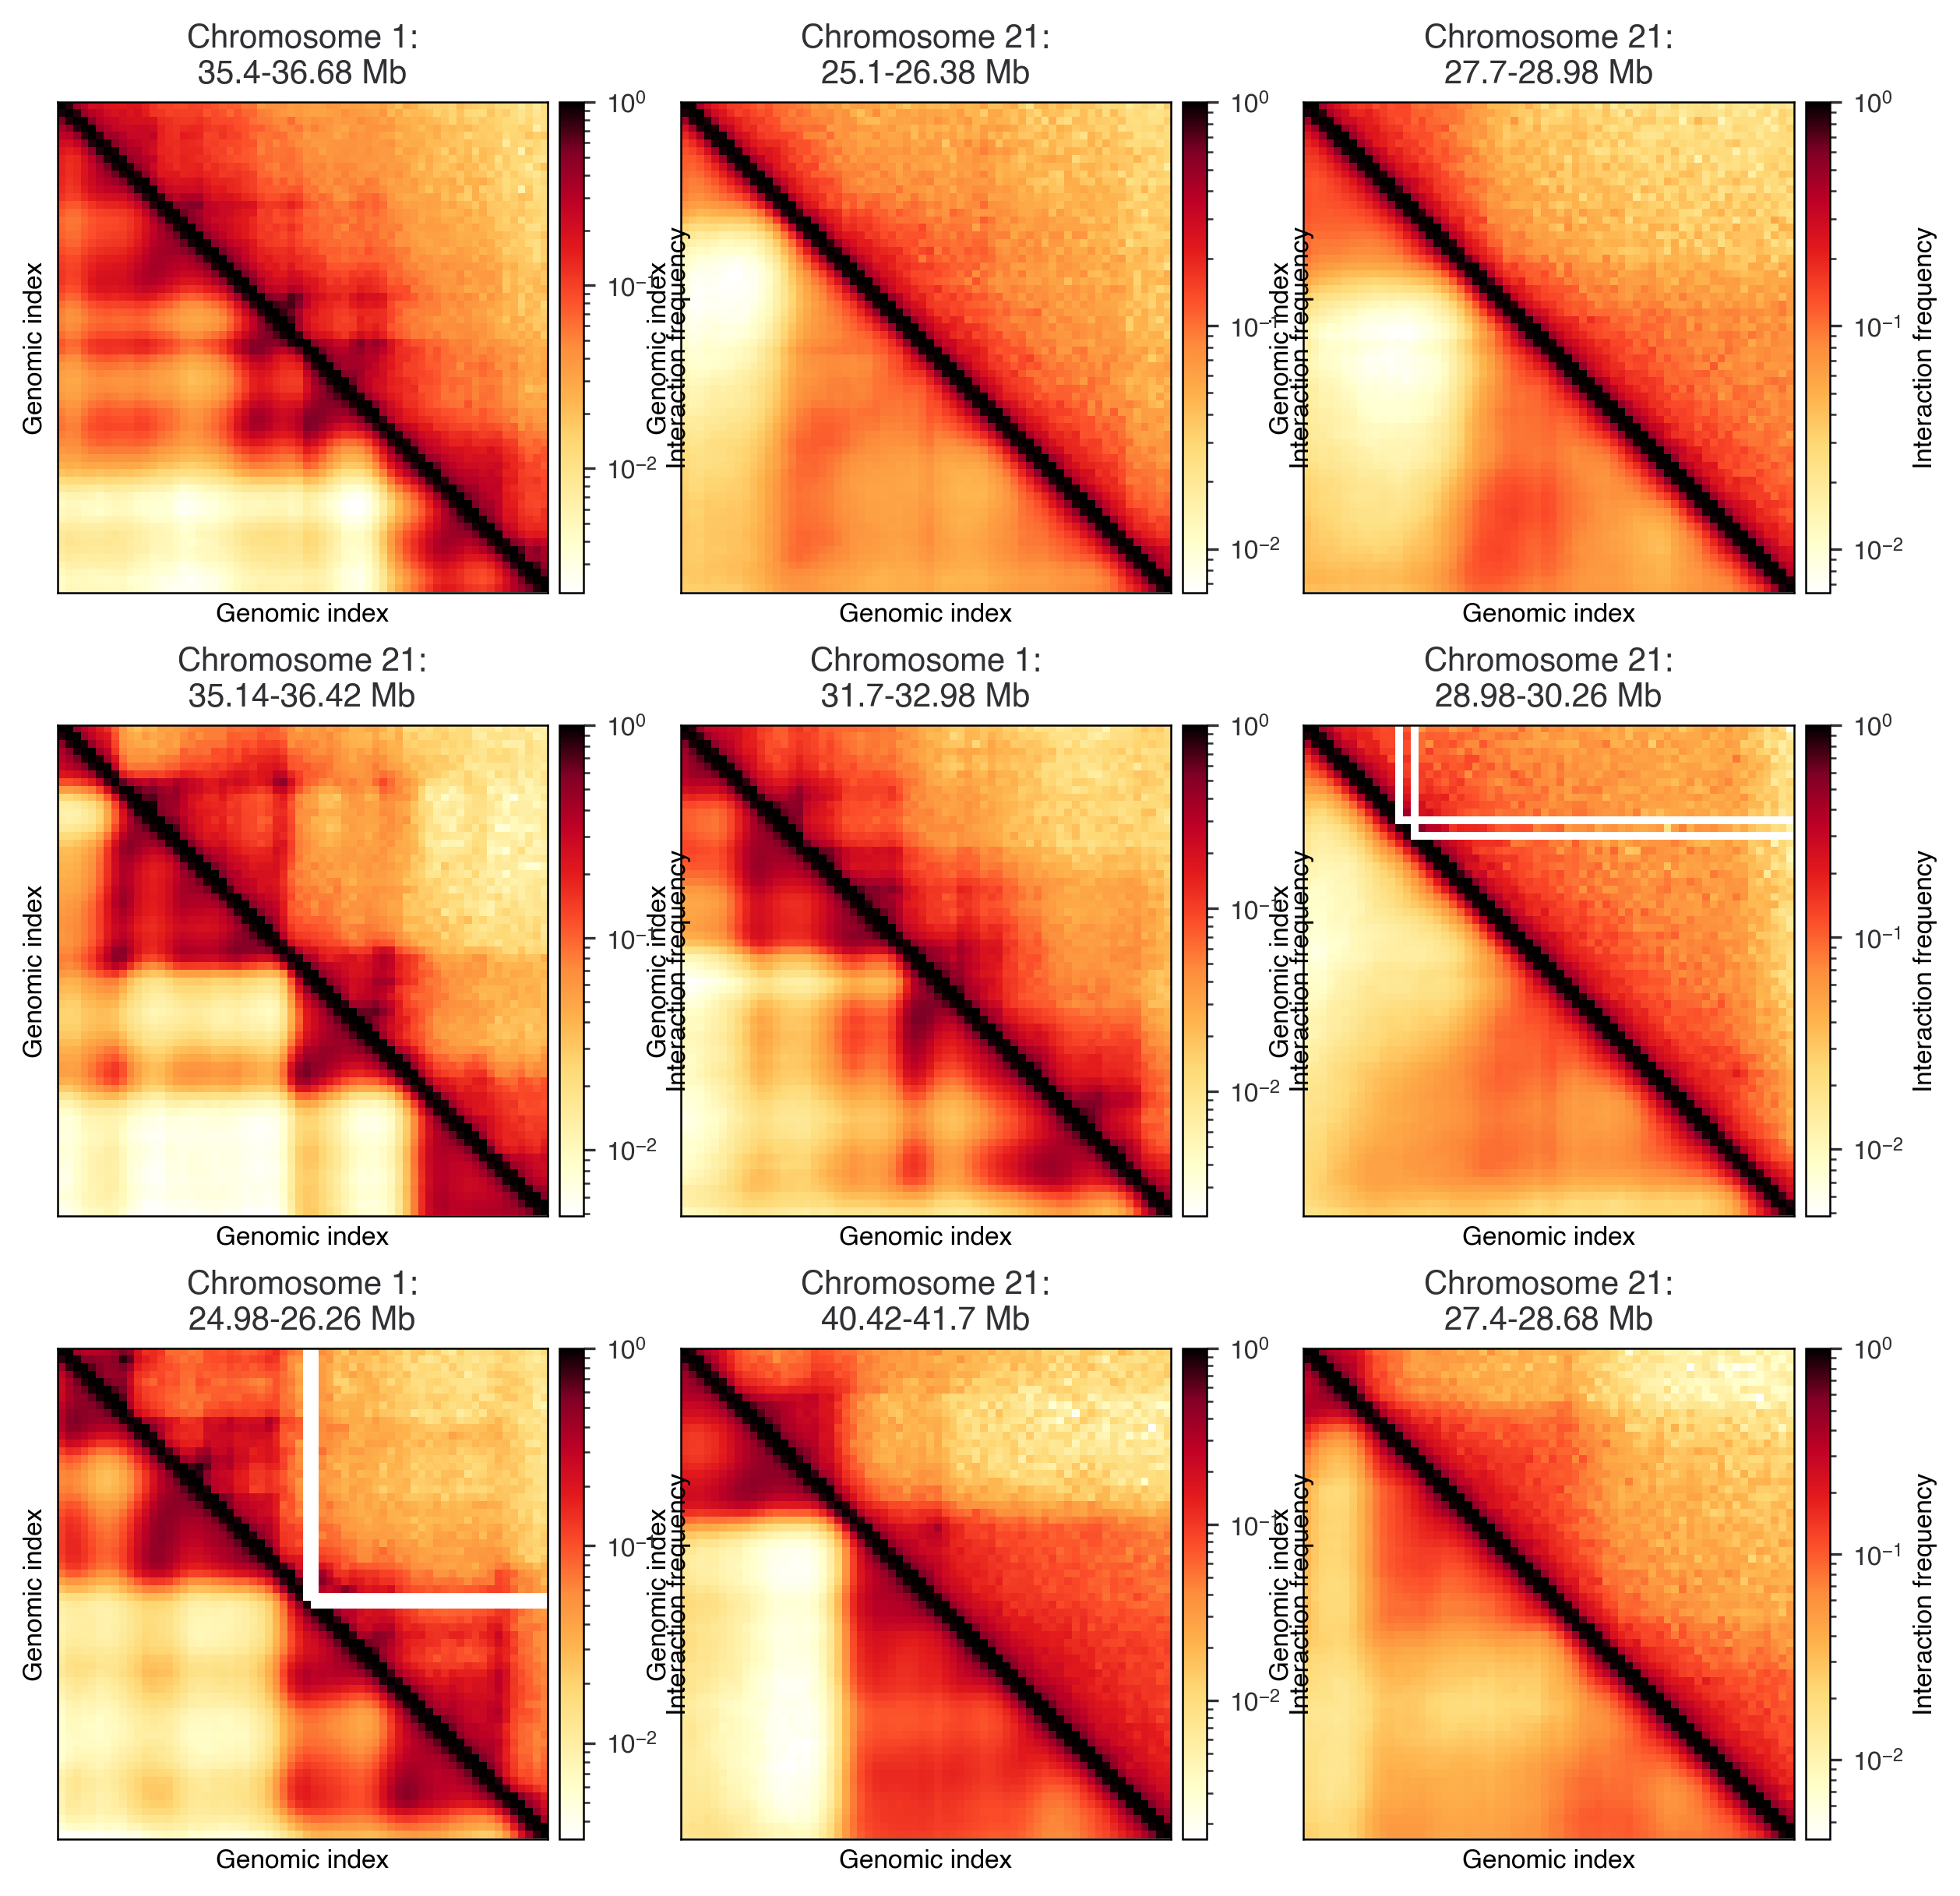

In [14]:
fig,axes = plt.subplots(ncols=3,nrows=3,layout='constrained',figsize=(8,8))
k=0
while k < 9:
    ax = axes[k//3,k%3]
    fig, ax, im, cbar = plot_region(all_gm_coord_files[-k-1],gm_hic,fig=fig,ax=ax)
    k+=1
    

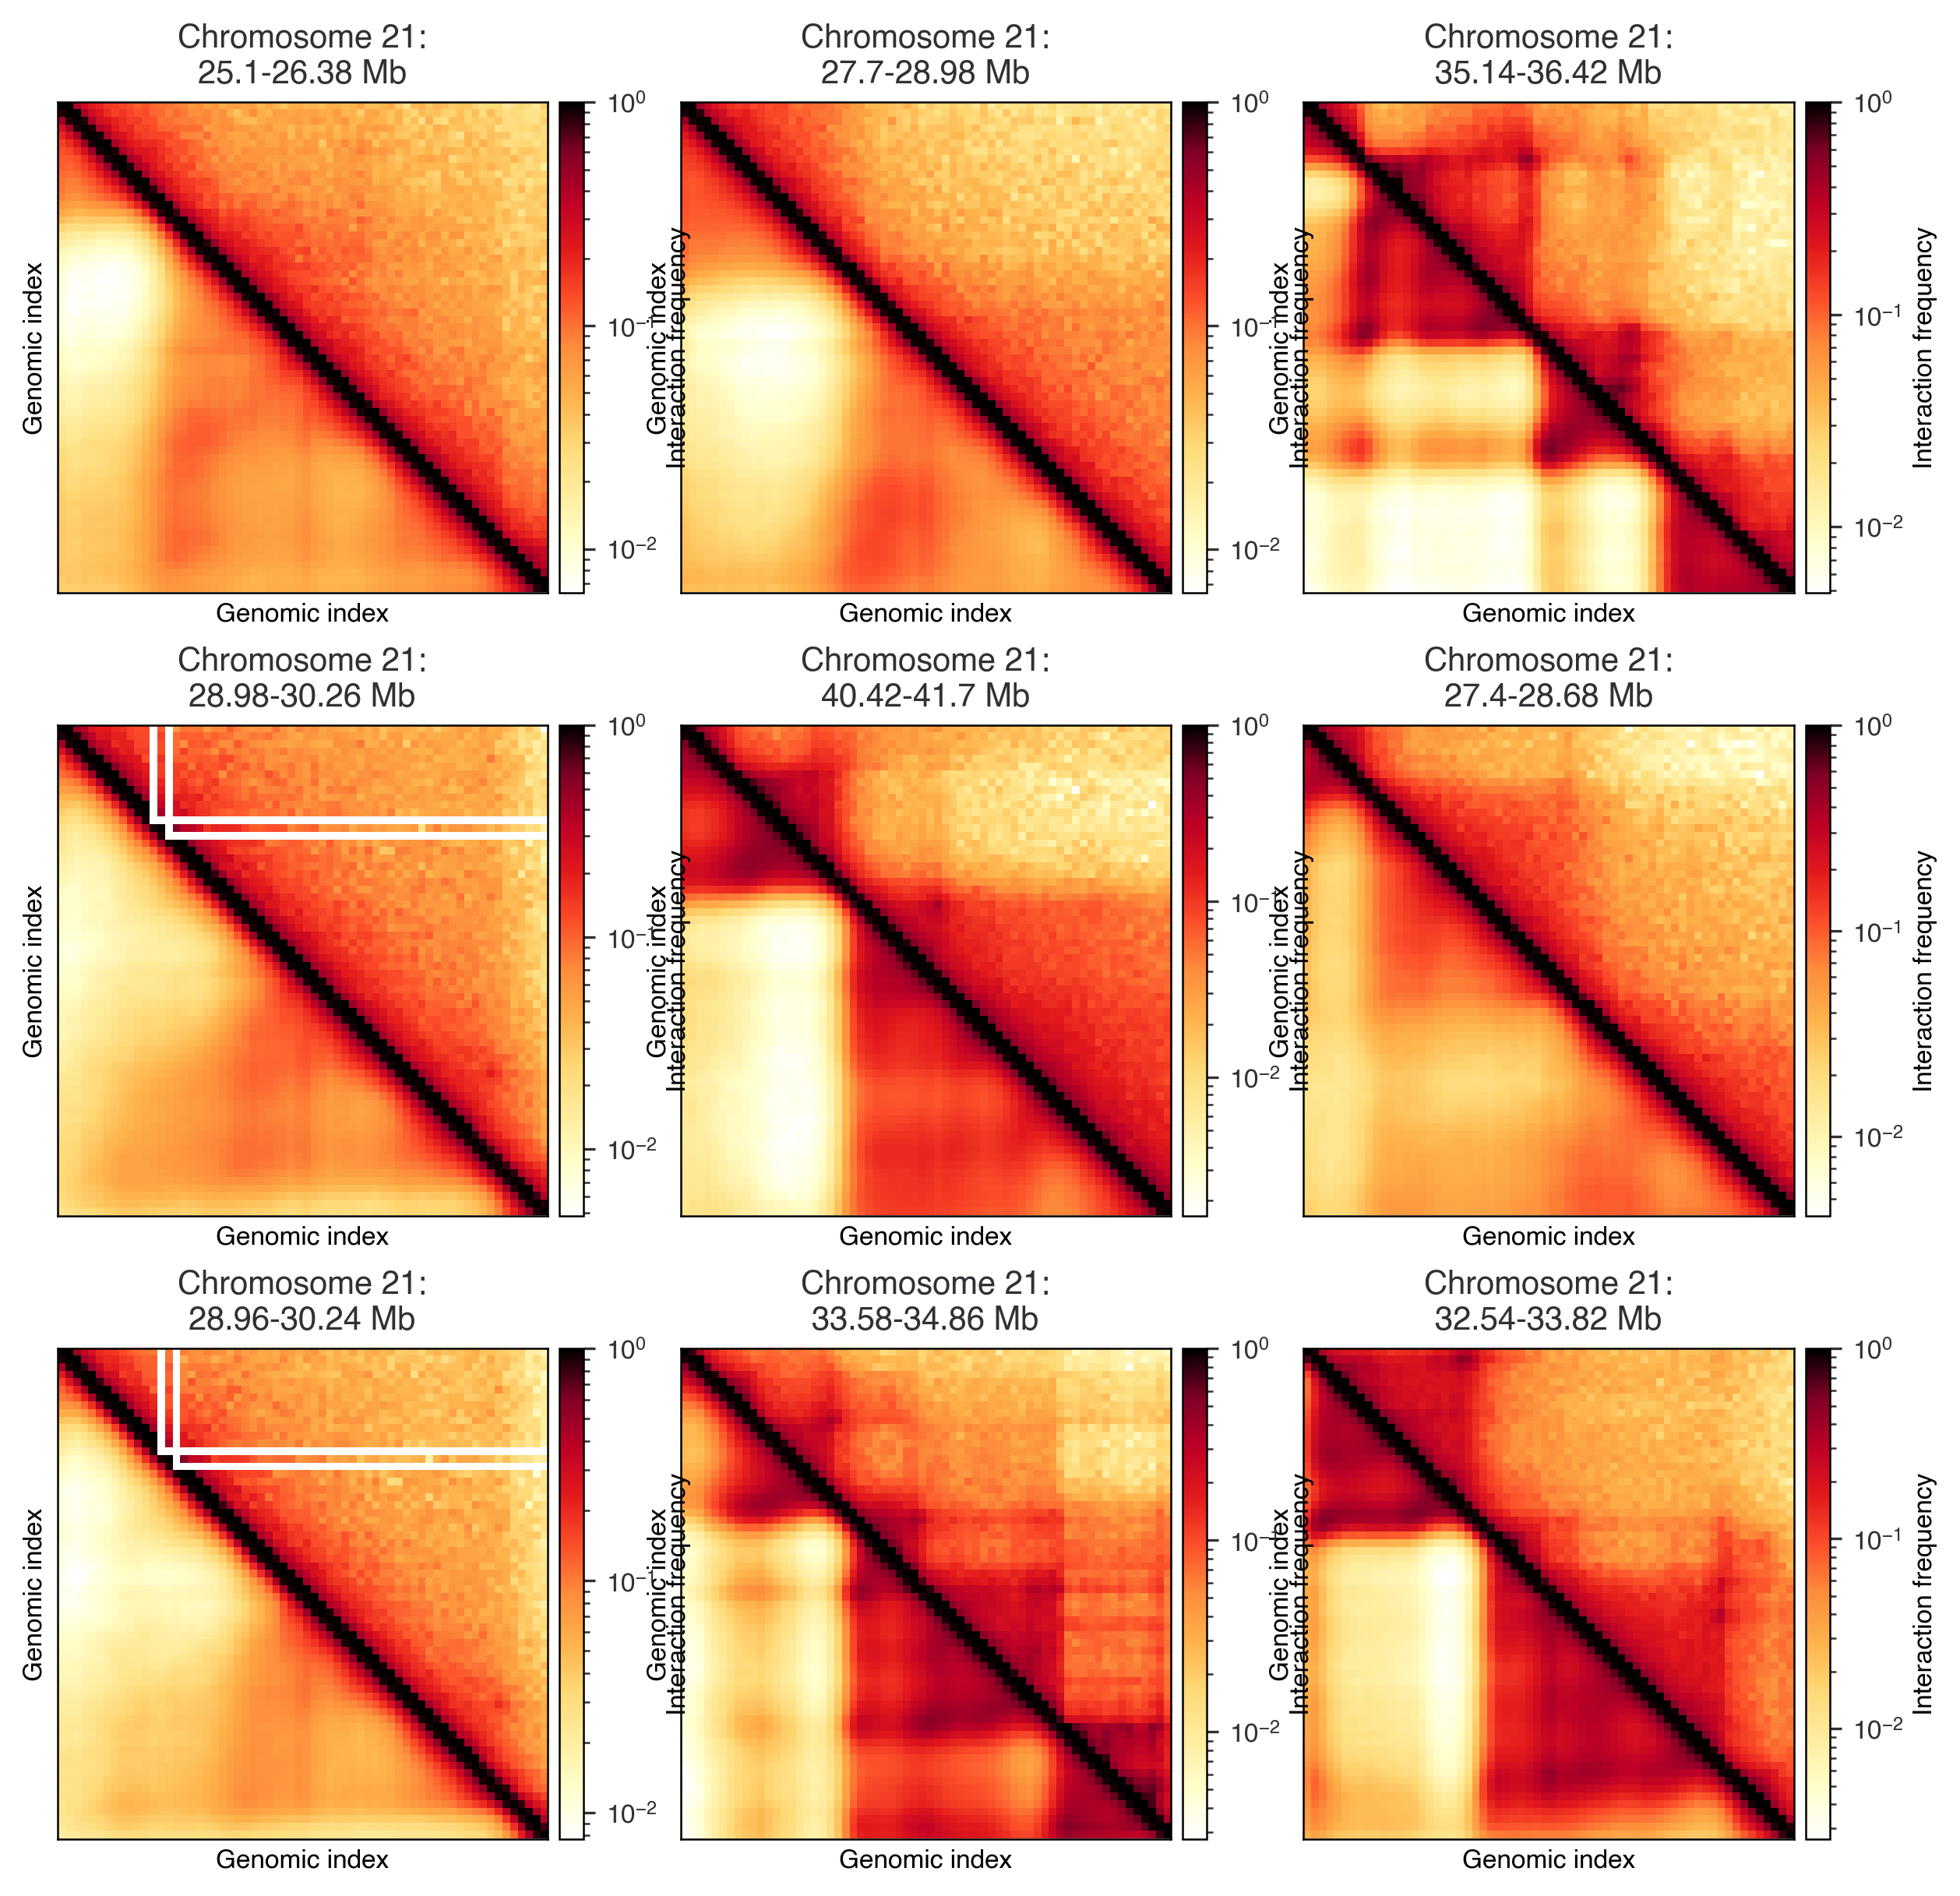

In [15]:
fig,axes = plt.subplots(ncols=3,nrows=3,layout='constrained',figsize=(8,8))
k=0
n=0
while k < 9:
    n+=1
    if not '_2' in all_gm_coord_files[-n]:
        continue
    ax = axes[k//3,k%3]
    fig, ax, im, cbar = plot_region(all_gm_coord_files[-n],gm_hic,fig=fig,ax=ax)
    k+=1
    

#### Compute all R-squared, correlation values

In [16]:
r2_dist = {}
corr_dist = {}
r2_prob = {}
corr_prob = {}
for cell_type,files,exp_hic in [('GM',all_gm_coord_files,gm_hic),('IMR',all_imr_coord_files,imr_hic)]:

    gen_median_dists = []
    gen_probs = []
    exp_probs = []
    exp_log_probs = []
    
    for f in files:
        
        # Determine the chromosome, region index, and genomic index
        chrom, region_idx, genomic_index = parse_filename(f)

        # Load the generated coordinates
        coords = Coordinates(f)

        # Convert coordinates to distances and obtain the average contact probabilities
        dists = coords.distances
        gen_prob_map = conformations_to_probs(dists)

        # Load the experimental Hi-C interaction frequencies
        start = genomic_index
        stop = start + resolution * coords.num_beads
        exp_prob_map = exp_hic.fetch(chrom,start,stop)

        # Get the indices for the upper triangle of each set of data, excluding the diagonal
        n = coords.num_beads
        i,j = torch.triu_indices(n,n,1)

        #####
        # Place data into the respective lists

        # Interaction frequency
        exp_probs.append(exp_prob_map.prob_map[i,j])
        
        # Remove values associated with NaN Hi-C data
        valid_idx = torch.where(exp_probs[-1].isfinite())[0]
        exp_probs[-1] = exp_probs[-1][valid_idx]
        i,j = i[valid_idx], j[valid_idx]

        # Normalize the experimental interaction frequencies to nearest neighbors to
        # obtain contact probabilities consistent with our distance-to-probability 
        # conversion
        exp_probs[-1]/=  torch.nanmean(exp_prob_map.prob_map[range(n-1),range(1,n)])
        
        # Log probability
        exp_log_probs.append(exp_probs[-1].log10())
        
        # Generated probabilities
        gen_probs.append(gen_prob_map.prob_map[i,j])
        
        # Interactions with recorded probability 0 become undefined, so remove those points
        valid_idx = torch.where(exp_log_probs[-1].isfinite())[0]
        exp_log_probs[-1] = exp_log_probs[-1][valid_idx]
        i,j = i[valid_idx], j[valid_idx]

        # Generated distances
        gen_median_dists.append(dists.median.values[0,i,j])

    # Compute the desired statistics
    r2_dist[cell_type] = batch_r2(gen_median_dists,exp_log_probs)
    corr_dist[cell_type] = batch_corrcoef(gen_median_dists,exp_log_probs)
    r2_prob[cell_type] = batch_r2(gen_probs,exp_probs)
    corr_prob[cell_type] = batch_corrcoef(gen_probs,exp_probs)

    

#### Make the plots

In [17]:
def plot_hist(gm_data,imr_data,nbins=25,fig=None,ax=None,alpha=0.5):

    # Convert to numpy to improve speed in plt 
    gm_data = gm_data.cpu().numpy()
    imr_data = imr_data.cpu().numpy()

    # Create consistent bins for eaach data type
    minn = min(gm_data.min(),imr_data.min())
    maxx = max(gm_data.max(),imr_data.max())
    delta = (maxx-minn)/nbins
    bins = np.arange(minn,maxx+delta/2,delta)

    # Create the figure, if necessary
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        
    # Create the histogram
    ax.hist(gm_data,alpha=alpha,bins=bins,label='GM12878',edgecolor='none')
    ax.hist(imr_data,alpha=alpha,bins=bins,label='IMR-90',edgecolor='none')

    return fig, ax
    

    
    
    
    

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 40 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'G', 'I', 'M', 'N', 'R', 'a', 'b', 'c', 'd', 'e', 'eight', 'f', 'five', 'g', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'two', 'u', 'v', 'x', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 24, 25, 26, 27, 28, 42, 44, 48, 49, 53, 68, 69, 70, 71, 72, 73, 74, 76, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 91, 92, 1894]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 42 glyphs after
INFO:fontTools.subset:Glyp

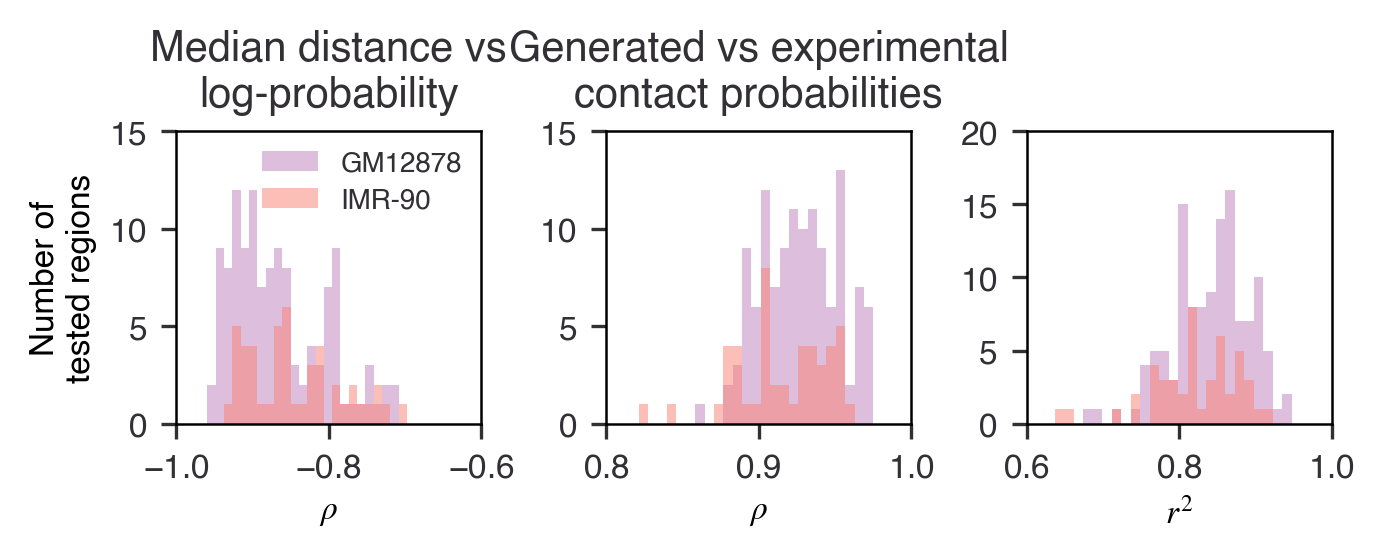

In [18]:
fig,axes = plt.subplots(ncols=3,nrows=1,layout='constrained',figsize=(4.5,1.75))

xlabels = [
    '$\\rho$',
    '$\\rho$',
    '$r^2$'
]
titles = [
    'Median distance vs\nlog-probability',
    'Generated vs experimental\ncontact probabilities',
    ''
]

# R2-scores
for i,(r2_IMR,r2_GM) in enumerate([ (corr_dist['IMR'],corr_dist['GM']), (corr_prob['IMR'],corr_prob['GM']), (r2_prob['IMR'],r2_prob['GM']) ]):
    ax = axes[i]
    fig,ax = plot_hist(r2_GM,r2_IMR,fig=fig,ax=ax)
    ax.set_xlabel(xlabels[i])
    ax.set_title(titles[i])
    if i == 0:
        ax.set_ylabel('Number of\ntested regions')
        ax.legend(framealpha=0,loc='upper right',fontsize='small')

fig.savefig(save_folder+'HiCCorrelationR2.pdf',transparent=True)
    

In [25]:
#for i,
#r2_dist['GM']
(corr_dist['IMR'],corr_dist['GM']), (corr_prob['IMR'],corr_prob['GM']), (r2_prob['IMR'],r2_prob['GM']) 
for i,f in enumerate(all_gm_coord_files):

    if 'sample_395_5.0_8.0_120_1.pt' in f:
        print(corr_dist['GM'][i],corr_prob['GM'][i], r2_prob['GM'][i])
    

tensor(-0.9383, dtype=torch.float64) tensor(0.9359, dtype=torch.float64) tensor(0.8676, dtype=torch.float64)


In [19]:
for i,(r2_IMR,r2_GM) in enumerate([ (corr_dist['IMR'],corr_dist['GM']), (corr_prob['IMR'],corr_prob['GM']), (r2_prob['IMR'],r2_prob['GM']) ]):

    print(r2_GM.median())
    

tensor(-0.8821, dtype=torch.float64)
tensor(0.9268, dtype=torch.float64)
tensor(0.8487, dtype=torch.float64)


In [179]:
torch.corrcoef(
    torch.stack([gen_median_dists[0],exp_log_probs[0]],dim=0)
)

tensor([[ 1.0000, -0.8542],
        [-0.8542,  1.0000]], dtype=torch.float64)

(<Figure size 1920x1440 with 2 Axes>,
 <Axes: xlabel='Genomic index', ylabel='Genomic index'>,
 <matplotlib.colorbar.Colorbar at 0x7f90550d5f60>)

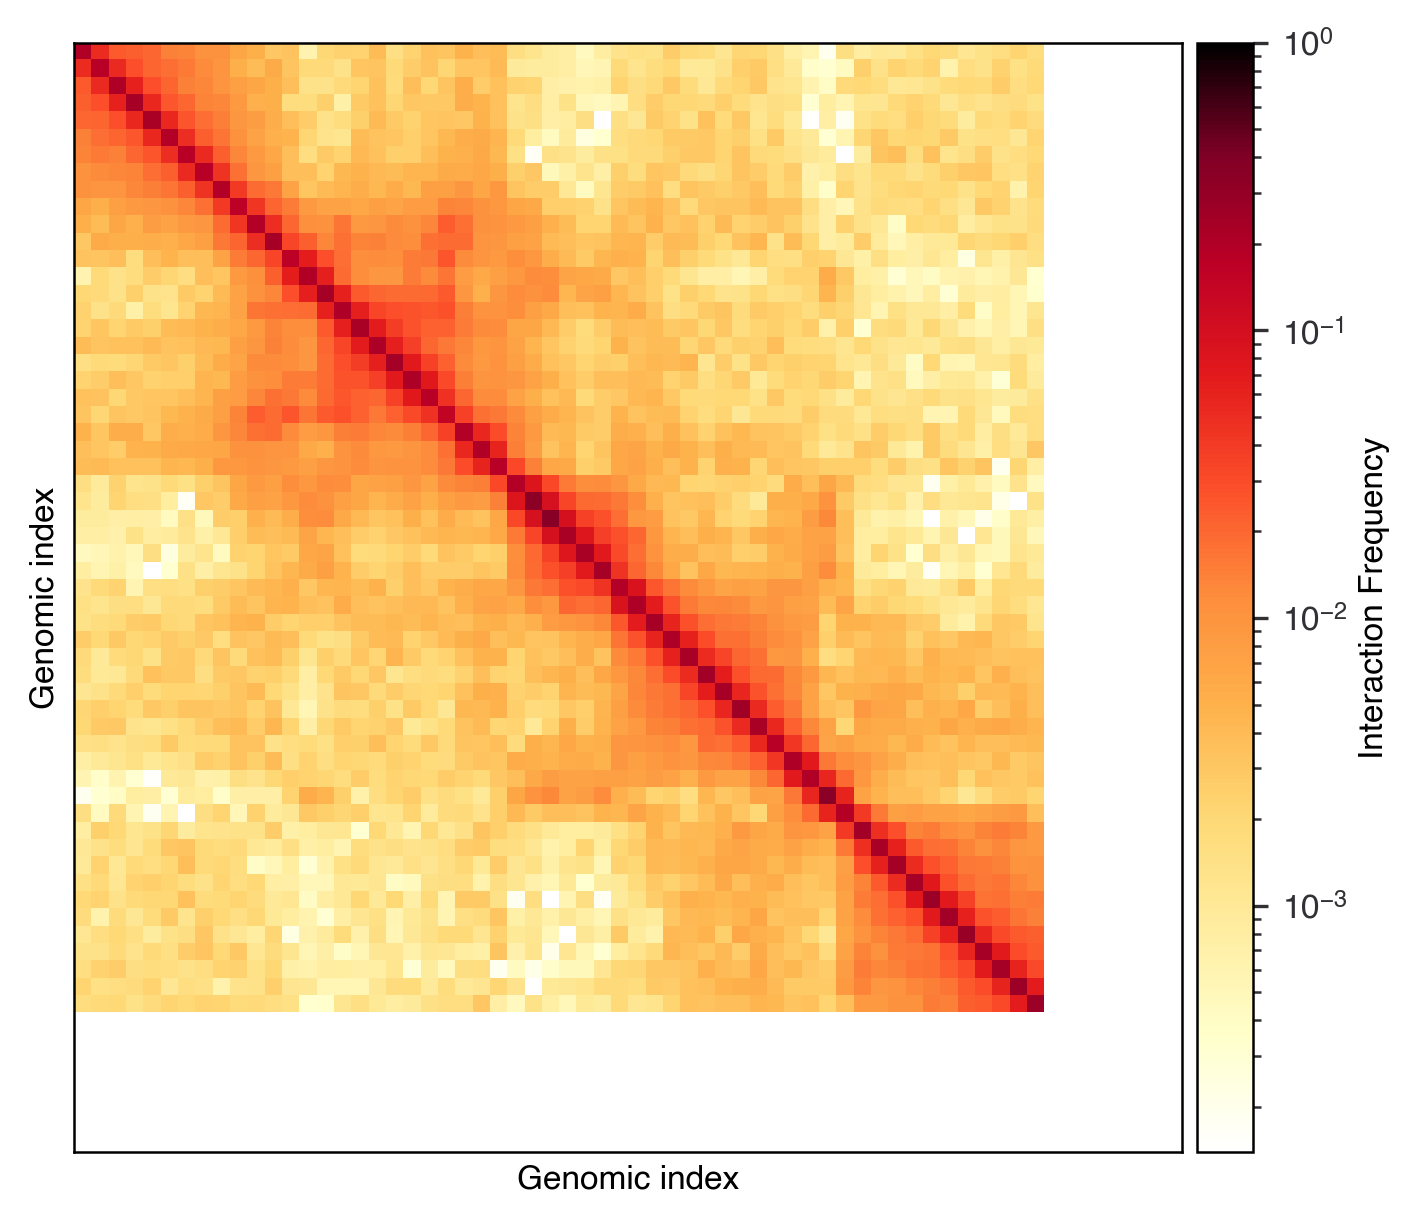

In [180]:
exp_prob_map.plot()

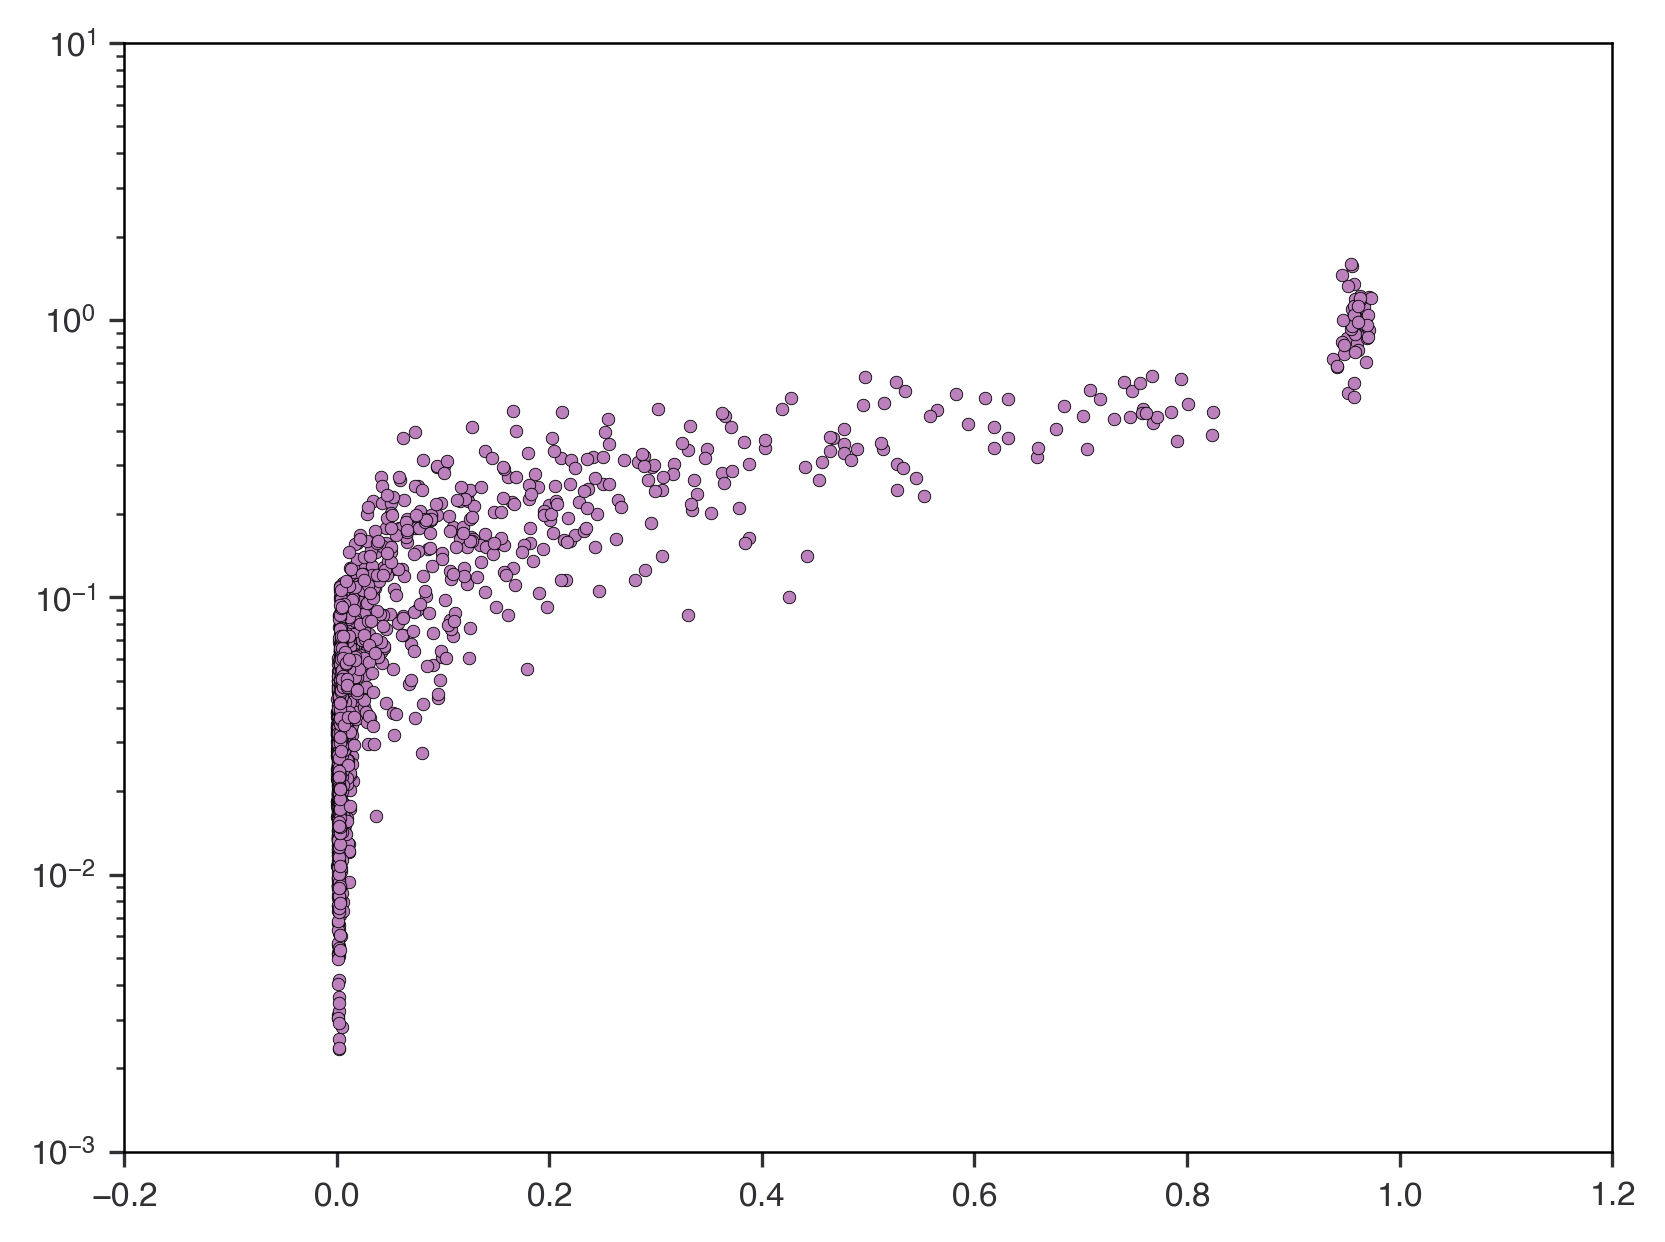

In [165]:
plt.plot(gen_median_dists[-1],exp_probs[-1][valid_idx],'.')#10**exp_log_probs[0],'.')
plt.yscale('log')

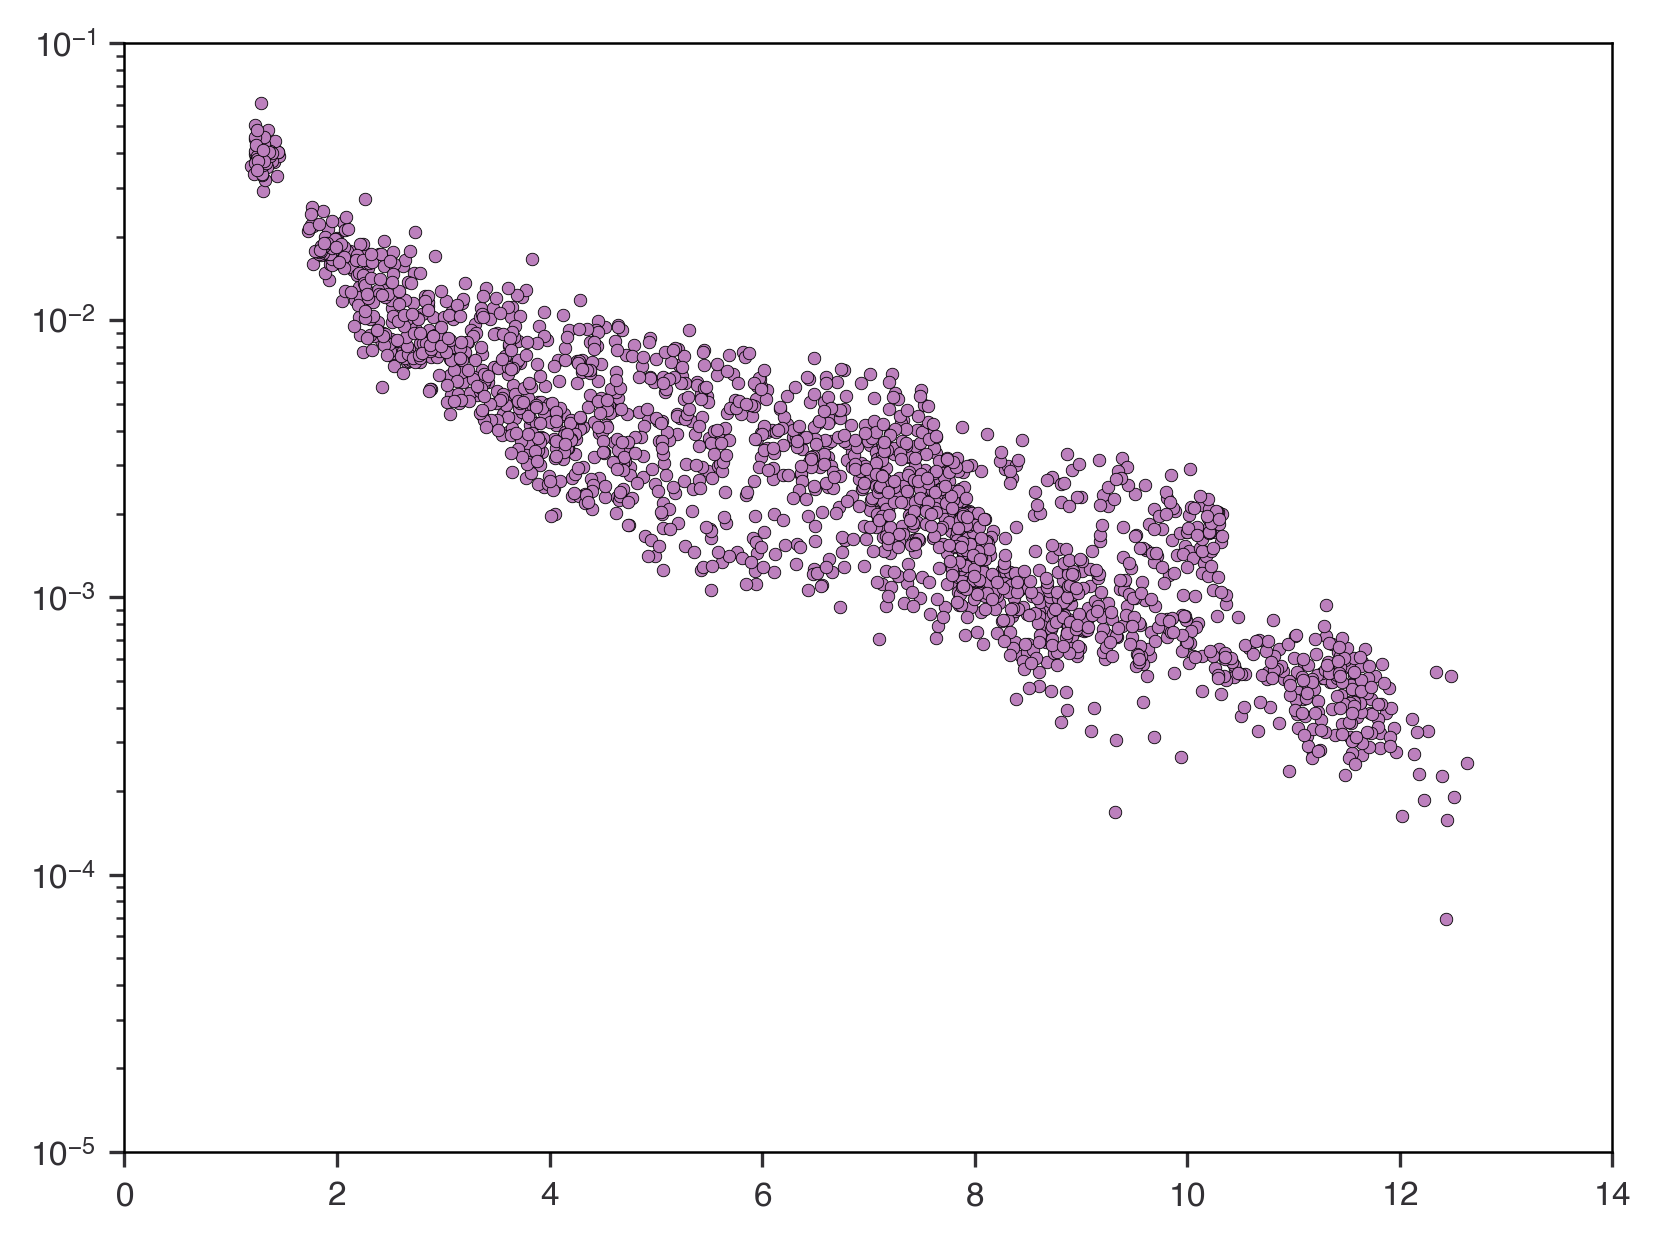

In [160]:
n = 54

f = all_gm_coord_files[n]
chrom, region_idx, genomic_index = parse_filename(f)
start = genomic_index
stop = start + resolution * 64

i,j = torch.triu_indices(64,64,1)

plt.plot(
    Coordinates(f).distances.median.values[0,i,j],
    gm_hic.fetch(chrom,start,stop).prob_map[i,j],
    '.'
)
plt.yscale('log')

In [161]:
y = gm_hic.fetch(chrom,start,stop).prob_map[i,j].log10()
x = Coordinates(f).distances.median.values[0,i,j][y.isfinite()]
y = y[y.isfinite()]


torch.corrcoef( 
    torch.stack(
        [
            x,
            y
        ],
        dim=0
    )
)

tensor([[ 1.0000, -0.9081],
        [-0.9081,  1.0000]], dtype=torch.float64)

(<Figure size 1920x1440 with 2 Axes>,
 <Axes: title={'center': 'Chromosome 7:\n19.1-20.38 Mb'}, xlabel='Genomic index', ylabel='Genomic index'>,
 <matplotlib.colorbar.Colorbar at 0x7f9119f1f460>)

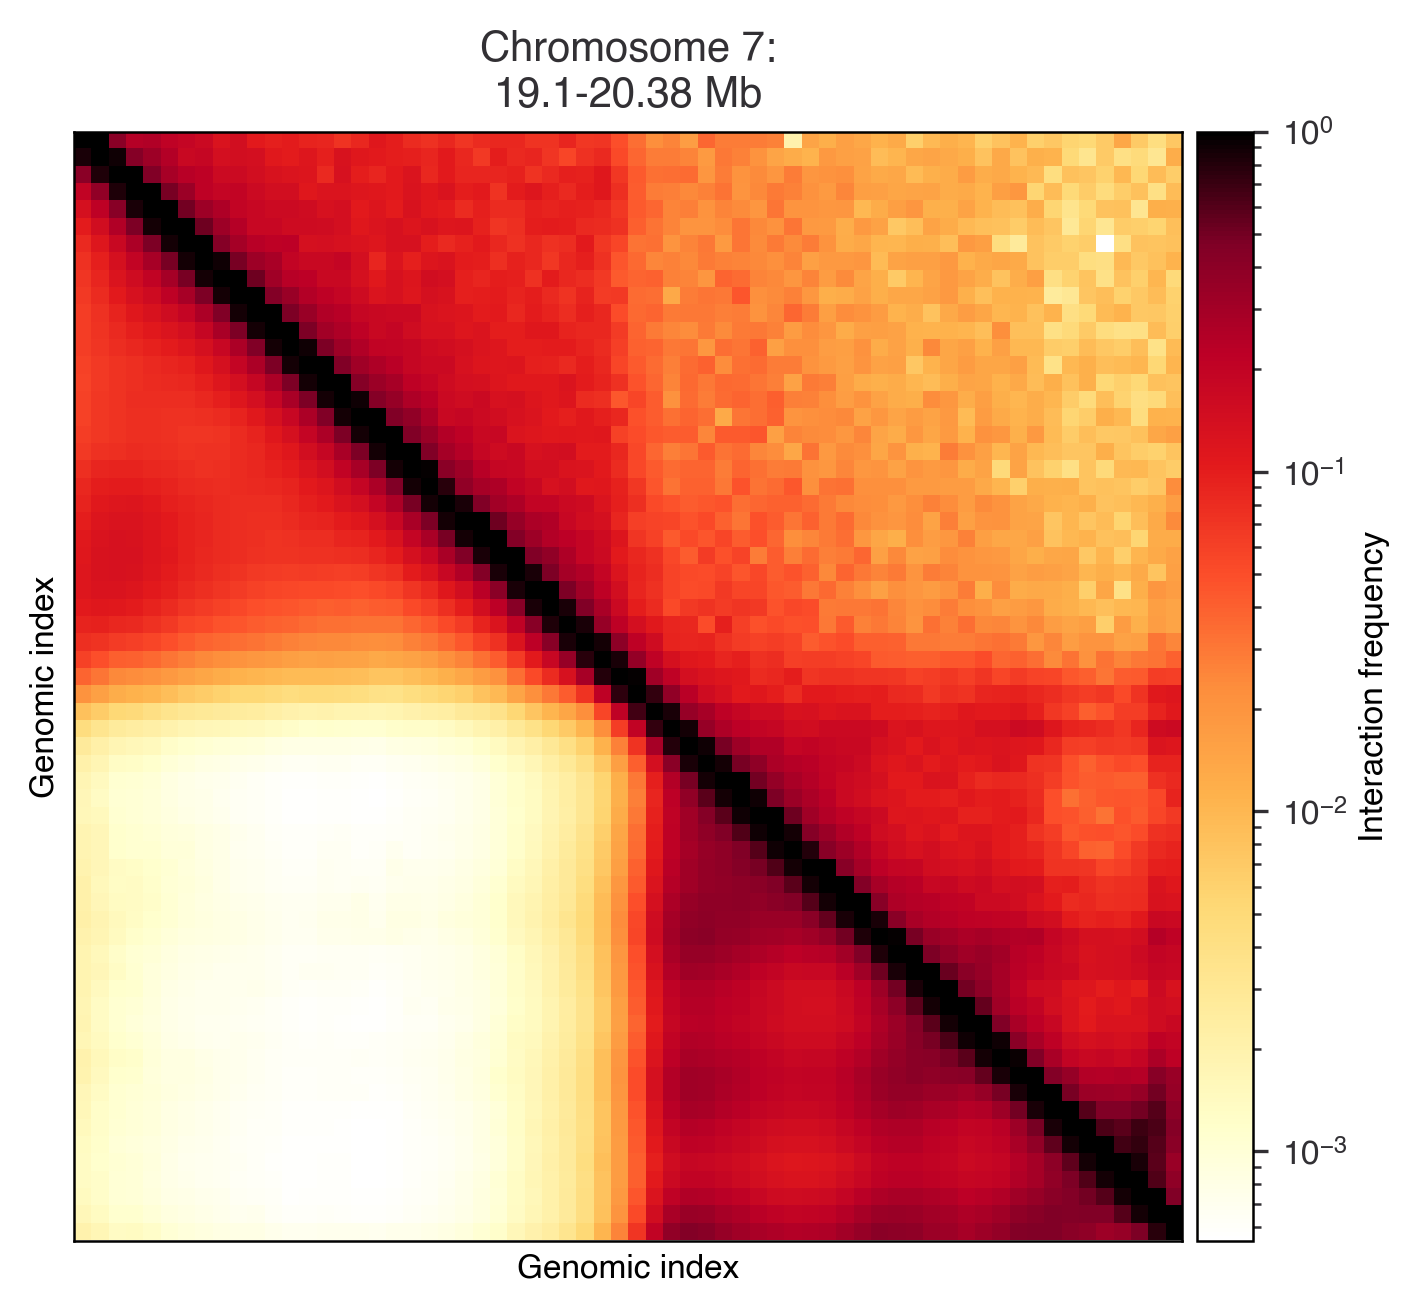

In [83]:
plot_region(all_gm_coord_files[90],gm_hic)

#### Scatter plot + R-squared values

In [10]:
gm_directories = [
    '../data/samples/origami_64_no_embed_reduction/eval_mode/',
    '../data/samples/origami_64_no_embed_reduction/cross_validation/GM/',
]
imr_directories = [
    '../data/samples/origami_64_no_embed_reduction/cross_validation/IMR/',
]

In [12]:
def parse_filename(f):
    f = f.split('_')
    if f[0] == 'sample':
        chrom = f[-1].split('.')[0]
        region_idx = int(f[1])
    elif f[0] == 'chr':
        chrom = f[1]
        region_idx = int(f[2])
    else:
        raise Exception(f"File {'_'.join(f)} cannot be interpreted")
    genomic_index = get_genomic_index(chrom,region_idx)
    return chrom, region_idx, genomic_index

In [108]:
def get_gen_hic(fp,r_c=1.5,sigma=3.72):

    if type(fp) == torch.Tensor:
        p = fp.clone()
    elif type(fp) == str:
        p = Coordinates(fp).distances.values
    else:
        p=fp.distances.values
        
    mask = p < r_c
    p[mask] = ( (sigma*(r_c-p[mask])).tanh() + 1 )/2
    mask^= True
    p[mask] = (r_c/p[mask])**4 / 2
    p = p.mean(0)

    return p
    return HiCMap(p)

In [ ]:
from tqdm.auto import tqdm

i,j = torch.triu_indices(64,64,1)
nearest_neighbors = torch.where(j-i==1)[0]
r2_vals = []
r_c_vals = []
sigma_vals = []
hic_corrcoefs = []

r_c_unique = torch.tensor([2.])#torch.arange(1.9,2.1,.02)
sigma_unique = torch.tensor([2.]) #torch.arange(1.,6.1,.25)

files = {}
n = 0
for d in gm_directories:
    files[d] = [ f for f in os.listdir(d) if 'sample_' in f or 'chr_' in f ]
    n+= len(files[d])

with tqdm(initial=0,total=len(r_c_unique)*len(sigma_unique)*n) as pbar:
    for d,fs in files.items():
        for f in fs:
            chrom,region_idx,start = parse_filename(f)
            
            exp_map = exp_hic.fetch(chrom,start,start+1_280_000)
            exp_probs = exp_map.prob_map[i,j]
            exp_probs/= torch.nanmean(exp_probs[nearest_neighbors])
            idx = torch.where(exp_probs.isfinite())[0]
            
            exp_probs = exp_probs[idx]
            
            coords = Coordinates(d+f).distances.values[...,i,j]
    
            for r_c in r_c_unique:
                for sigma in sigma_unique:
            
                    gen_map = get_gen_hic(coords,r_c=r_c,sigma=sigma)
                    #gen_probs = gen_map.prob_map[i,j]
                    gen_probs = gen_map 
                    
                    #idx = torch.where(exp_probs.isfinite())[0]
                    r2_vals.append(r2_score(gen_probs[idx],exp_probs))

                    hic_corrcoefs.append(
                        torch.corrcoef(
                            torch.stack([gen_probs[idx],exp_probs],dim=0)
                        )[0,1]
                    )
                    
                    r_c_vals.append(r_c)
                    sigma_vals.append(sigma)
                    pbar.update(1)
'''
for r_c in torch.arange(1,2.1,.1):
    for sigma in torch.arange(3.,4.1,.1):
        for d in gm_directories:
            files = [ f for f in os.listdir(d) if 'sample_' in f or 'chr_' in f ]
            for f in files:
                chrom,region_idx,start = parse_filename(f)
                
                exp_map = exp_hic.fetch(chrom,start,start+1_280_000)
                exp_probs = exp_map.prob_map[i,j]
                exp_probs/= torch.nanmean(exp_probs[nearest_neighbors])
                
                gen_map = get_gen_hic(d+f,r_c=r_c,sigma=sigma)
                gen_probs = gen_map.prob_map[i,j]
                
                idx = torch.where(exp_probs.isfinite())[0]
                r2_vals.append(r2_score(gen_probs[idx],exp_probs[idx]))
                
                r_c_vals.append(r_c)
                sigma_vals.append(sigma)
'''
r_c_vals = torch.tensor(r_c_vals)
sigma_vals = torch.tensor(sigma_vals)
r2_vals = torch.tensor(r2_vals)
hic_corrcoefs = torch.tensor(hic_corrcoefs)

Text(0, 0.5, 'Analyzing match between experimental and inferred Hi-C')

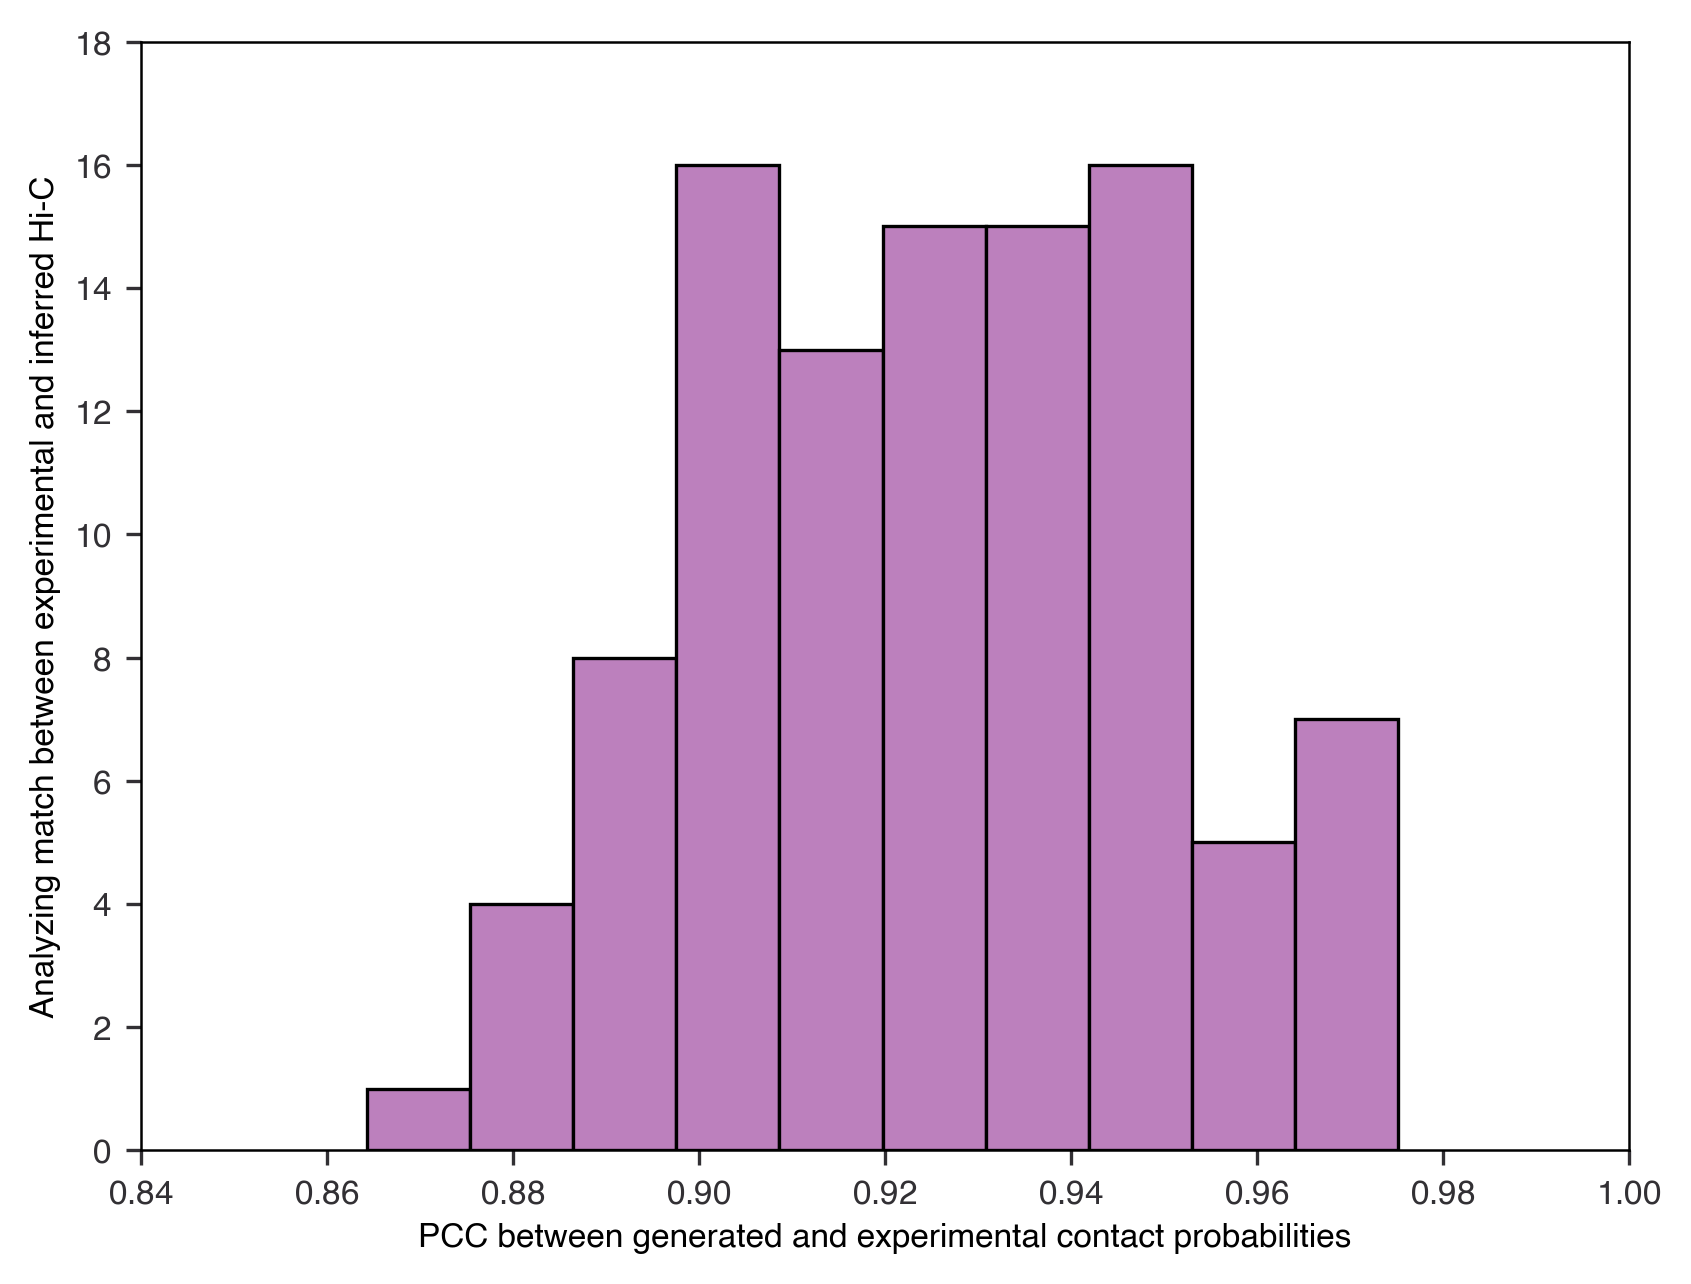

In [191]:
plt.hist(hic_corrcoefs.numpy())#,density=True)
plt.xlabel('PCC between generated and experimental contact probabilities')
plt.ylabel('Number of regions')
plt.title('Analyzing match between experimental and inferred Hi-C')

Text(0, 0.5, 'Analyzing match between experimental and inferred Hi-C')

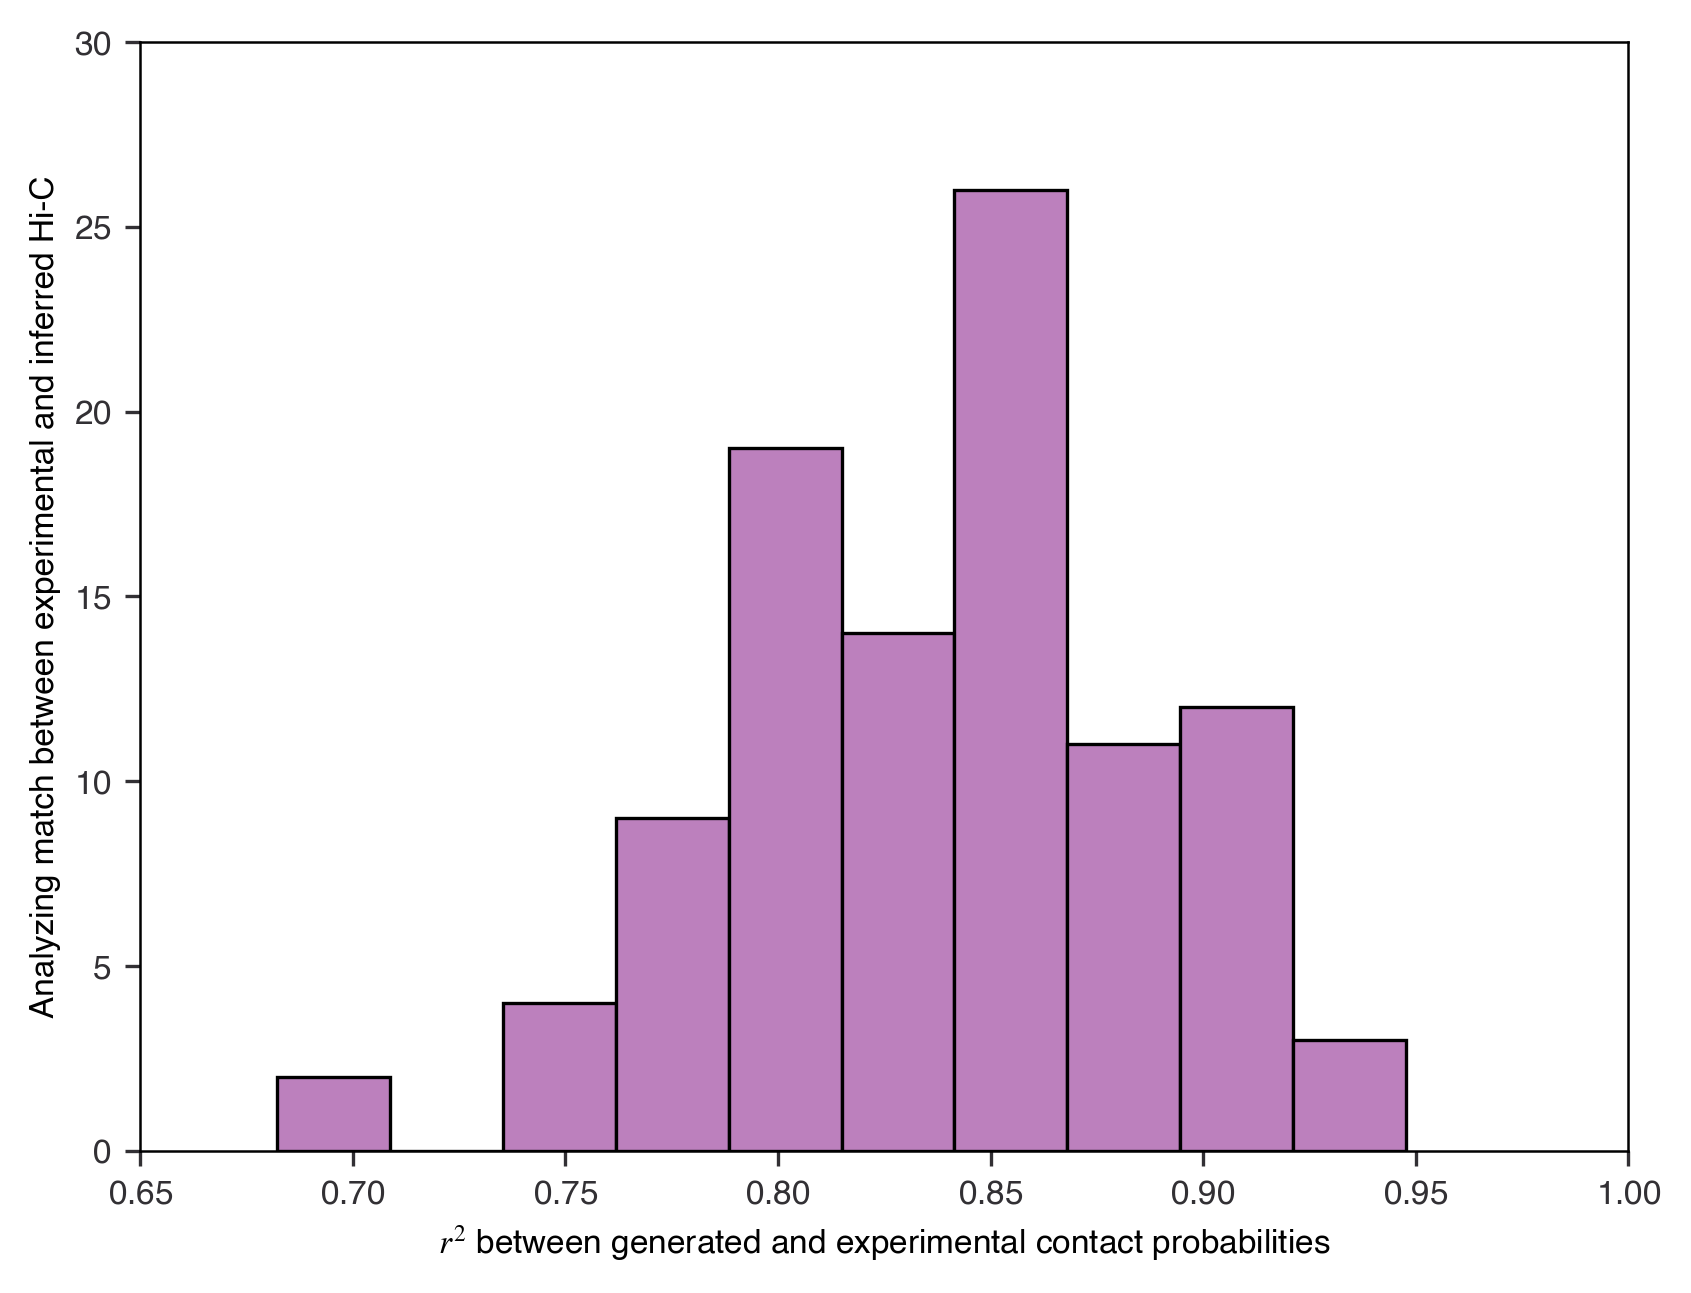

In [158]:
plt.hist(r2_vals.numpy())#,density=True)
plt.xlabel('$r^2$ between generated and experimental contact probabilities')
plt.ylabel('Number of regions')
plt.ylabel('Analyzing match between experimental and inferred Hi-C')

(array([ 2.,  0.,  4.,  6., 13., 18., 18., 19., 14.,  6.]),
 array([0.62276475, 0.65529924, 0.68783374, 0.72036823, 0.75290273,
        0.78543722, 0.81797172, 0.85050621, 0.88304071, 0.9155752 ,
        0.9481097 ]),
 <BarContainer object of 10 artists>)

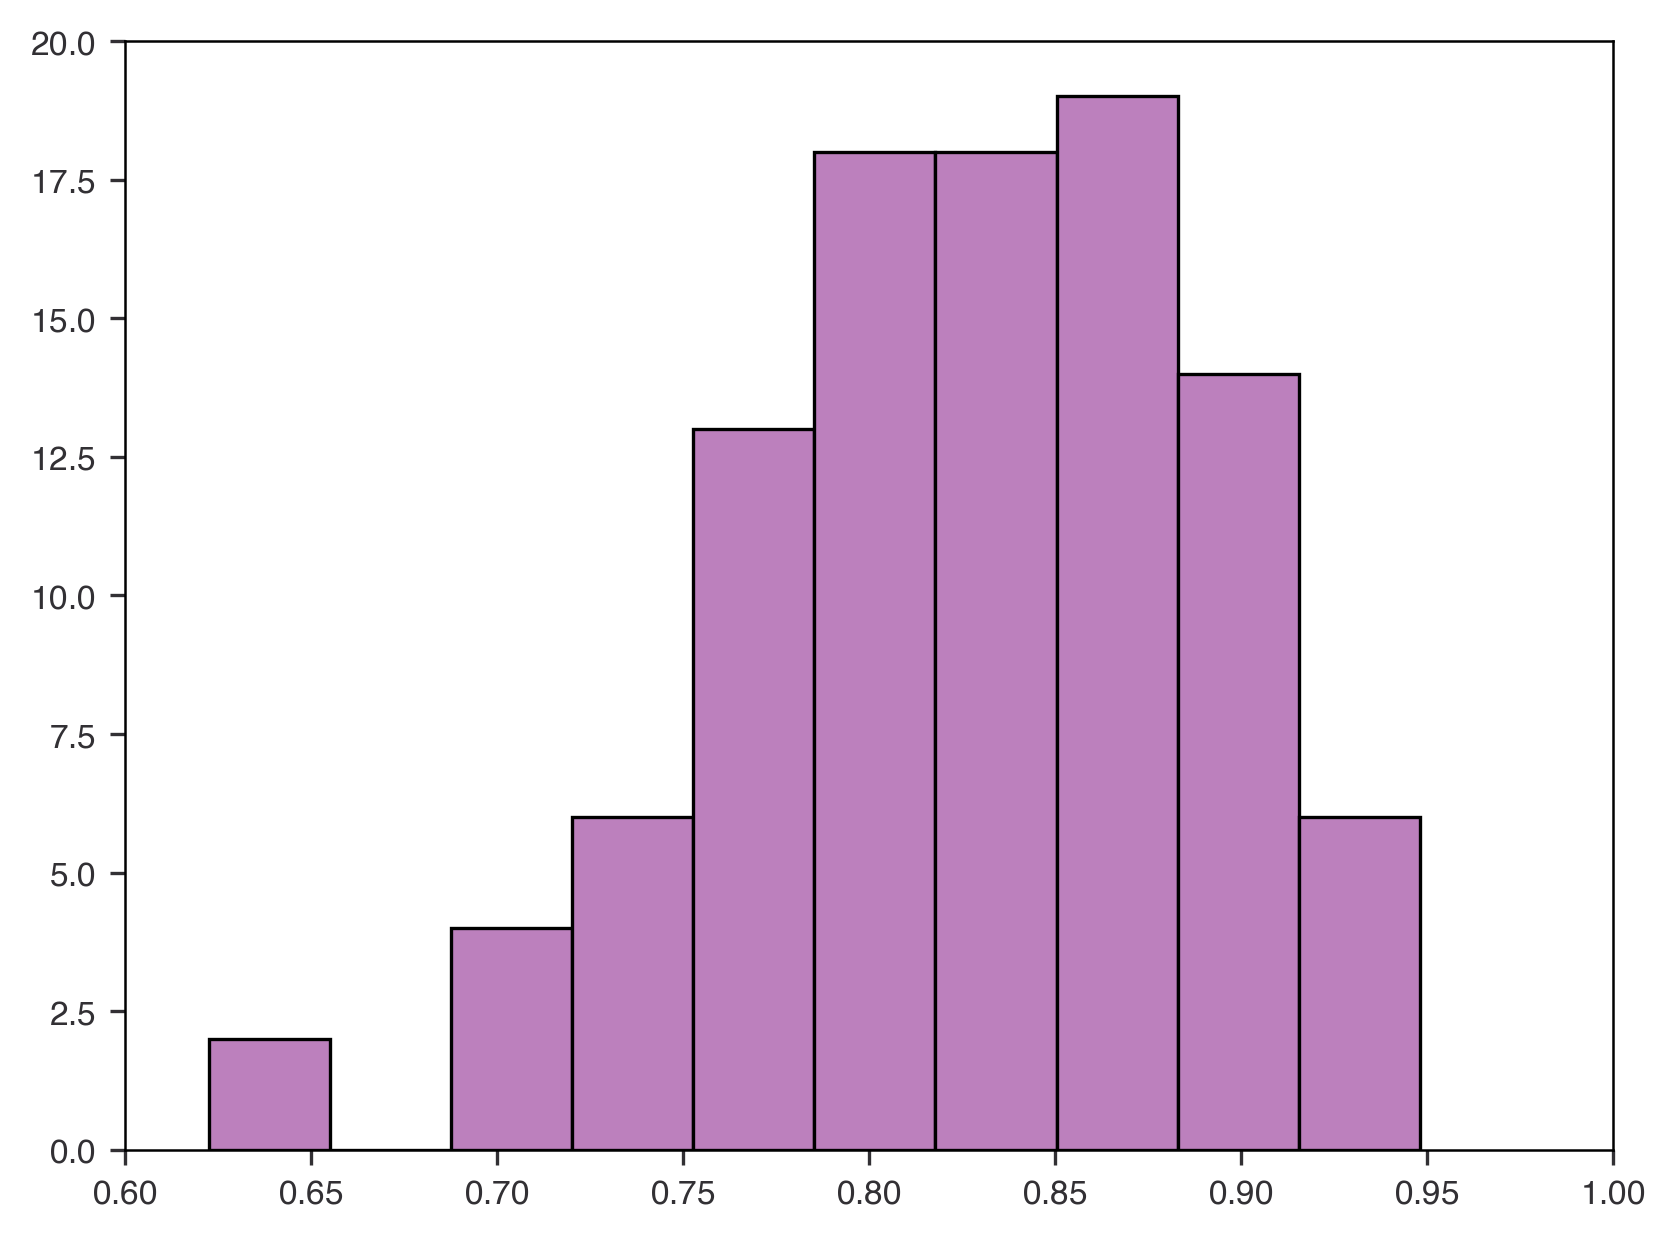

In [49]:
plt.hist(torch.tensor(r2_vals).numpy())

In [173]:
from tqdm.auto import tqdm

i,j = torch.triu_indices(64,64,1)
nearest_neighbors = torch.where(j-i==1)[0]
r2_vals_spatial = []
corrcoefs = []

files = {}
n = 0
for d in gm_directories:
    files[d] = [ f for f in os.listdir(d) if 'sample_' in f or 'chr_' in f ]
    n+= len(files[d])

all_dists = []
all_probs = []
with tqdm(initial=0,total=n) as pbar:
    for d,fs in files.items():
        for f in fs:
            chrom,region_idx,start = parse_filename(f)
            
            exp_map = exp_hic.fetch(chrom,start,start+1_280_000)
            exp_probs = exp_map.prob_map[i,j].log10()
            #exp_probs/= torch.nanmean(exp_probs[nearest_neighbors]).log10()
            idx = torch.where(exp_probs.isfinite())[0]
            
            exp_probs = exp_probs[idx]
            
            mean_dists = Coordinates(d+f).distances.mean.values[0,i,j] * 100

            #gen_map = get_gen_hic(coords,r_c=r_c,sigma=sigma)
            #gen_probs = gen_map.prob_map[i,j]
            #gen_probs = gen_map 
            
            #idx = torch.where(exp_probs.isfinite())[0]
            r2_vals_spatial.append(r2_score(mean_dists[idx],exp_probs))
            corrcoefs.append( torch.corrcoef(torch.stack([mean_dists[idx],exp_probs],dim=0))[0,1] )

            all_dists.append(mean_dists[idx])
            all_probs.append(exp_probs)

            pbar.update(1)
r2_vals_spatial = torch.tensor(r2_vals_spatial)
corrcoefs = torch.tensor(corrcoefs)
all_dists = torch.cat(all_dists)
all_probs = torch.cat(all_probs)

  0%|          | 0/100 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Correlation between mean distance and experimental contact probability')

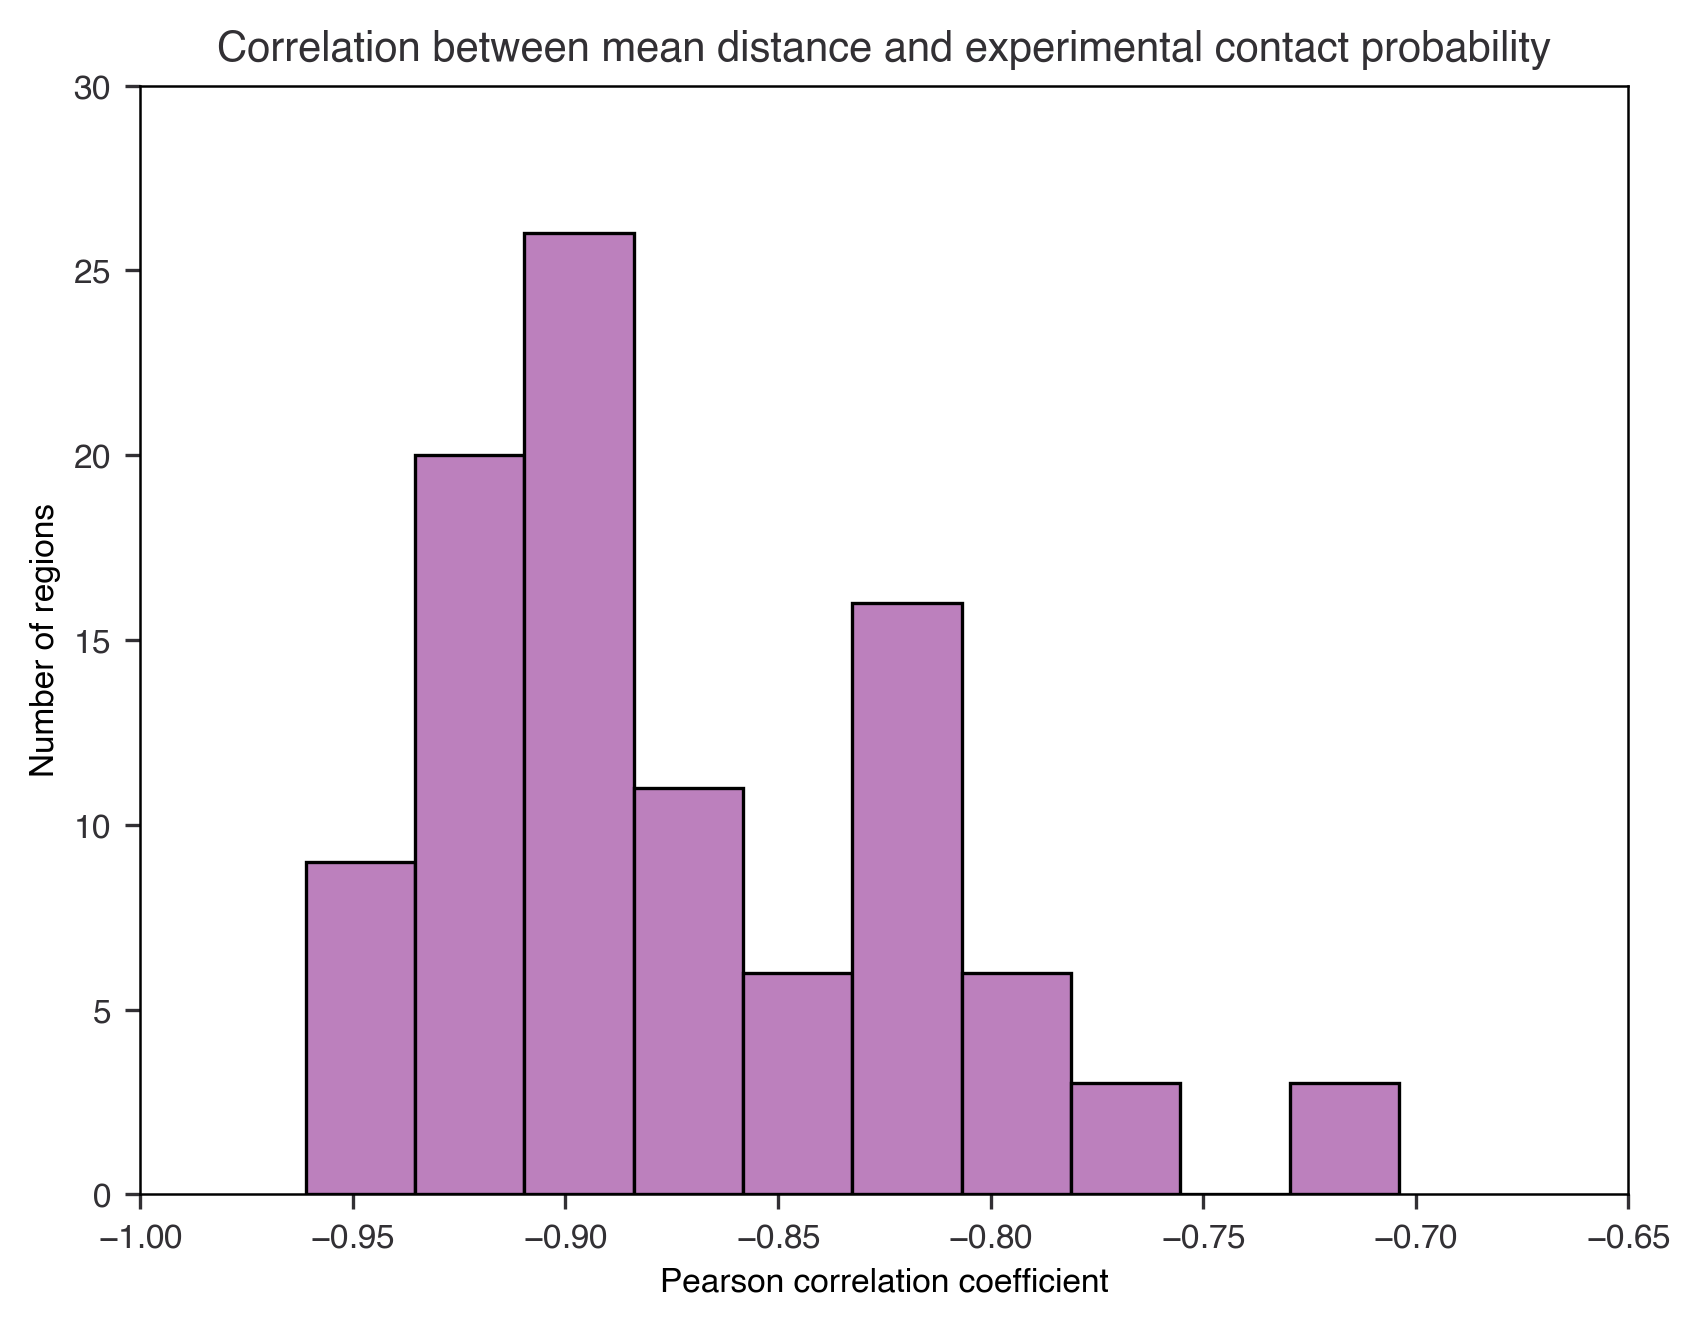

In [176]:
plt.hist(corrcoefs)
plt.xlabel('Pearson correlation coefficient')
plt.ylabel('Number of regions')
plt.title('Correlation between mean distance and experimental contact probability')

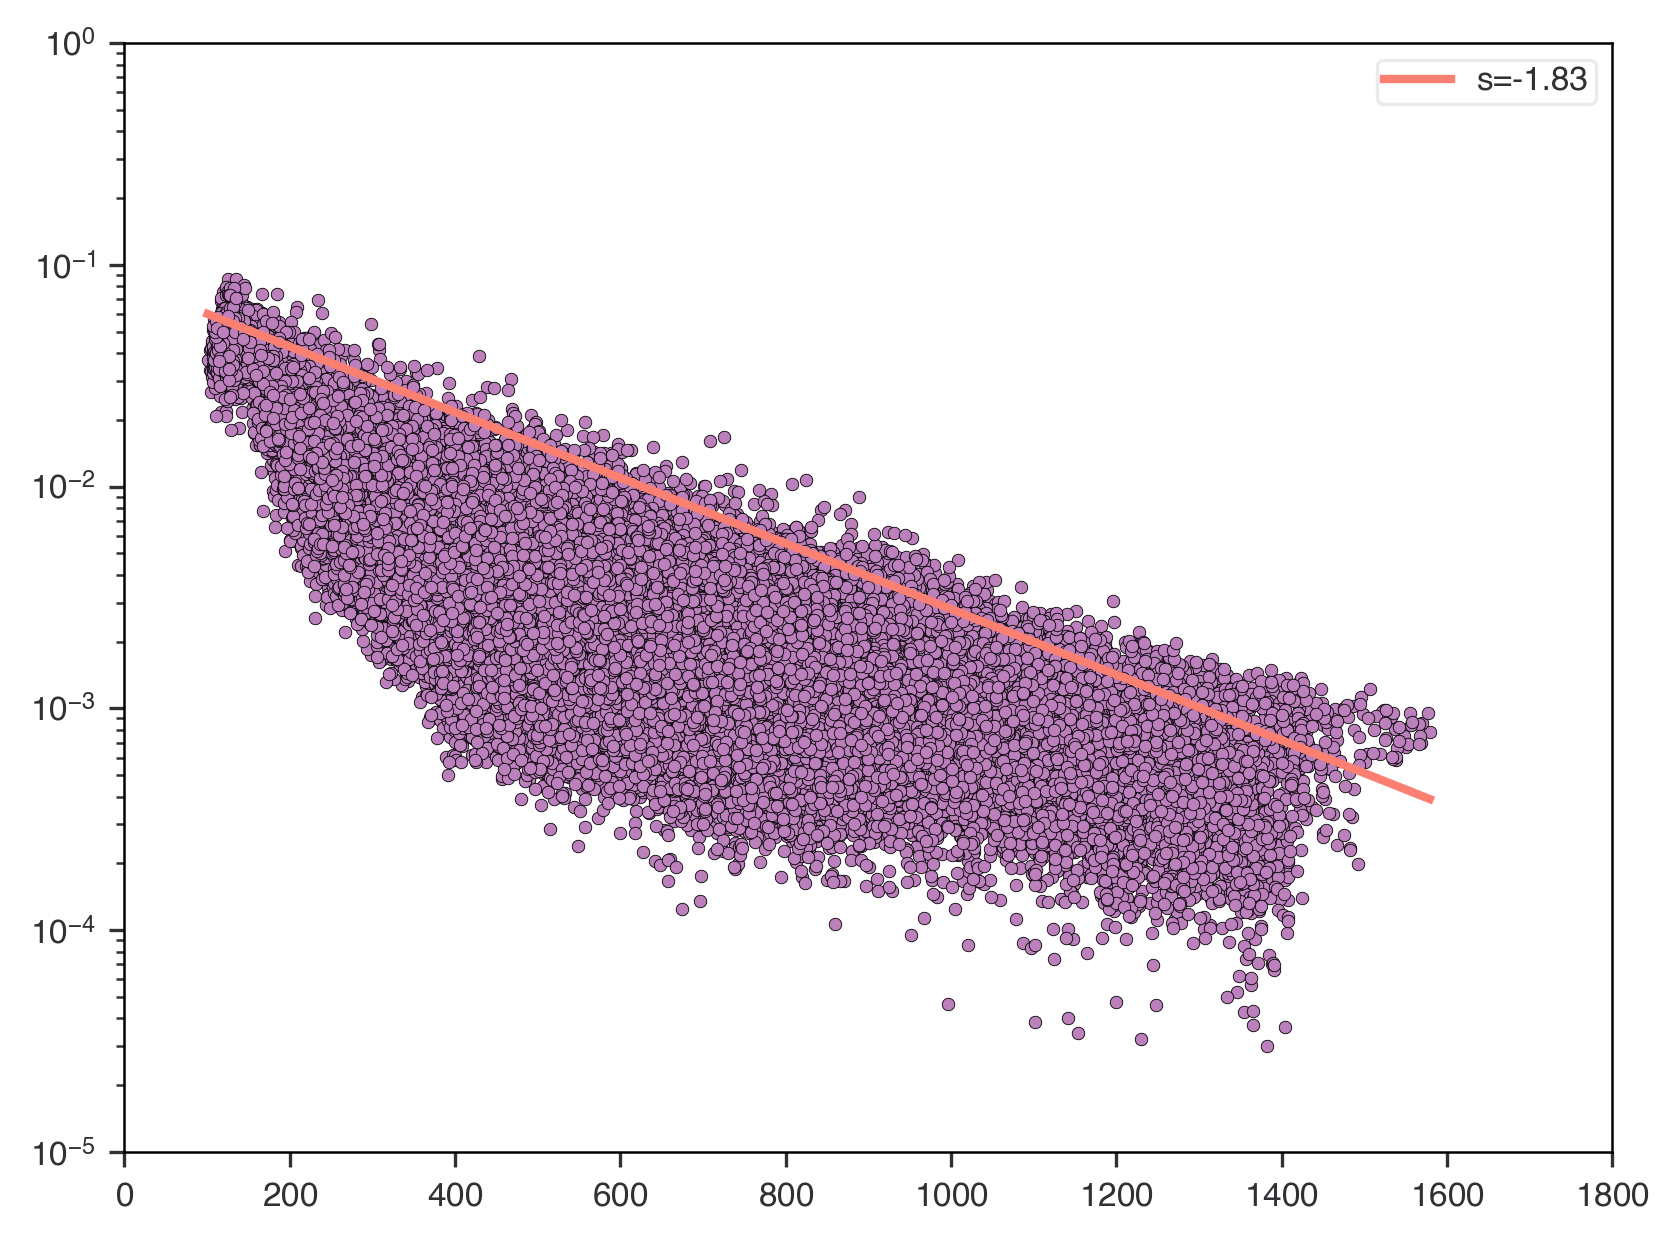

In [175]:
import numpy as np

#m,b = np.polyfit(mean_dists[idx].log10().cpu().numpy(),exp_probs.cpu().numpy(),1)
m,b = np.polyfit(all_dists.log10().cpu().numpy(),all_probs.cpu().numpy(),1)

#x = [mean_dists[idx].min(),mean_dists[idx].max()]
x = [all_dists.min(),all_dists.max()]
y = [ 10**(m*(xx.log10())+b) for xx in x ]

#plt.plot(mean_dists[idx].cpu().numpy(),(10**exp_probs).cpu().numpy(),'.') 
plt.plot(all_dists.cpu().numpy(),(10**all_probs).cpu().numpy(),'.') 
plt.plot(x,y,label=f's={round(m,3)}')
plt.yscale('log')
plt.legend()

In [183]:
torch.where( corrcoefs==corrcoefs.min() )

(tensor([72]),)

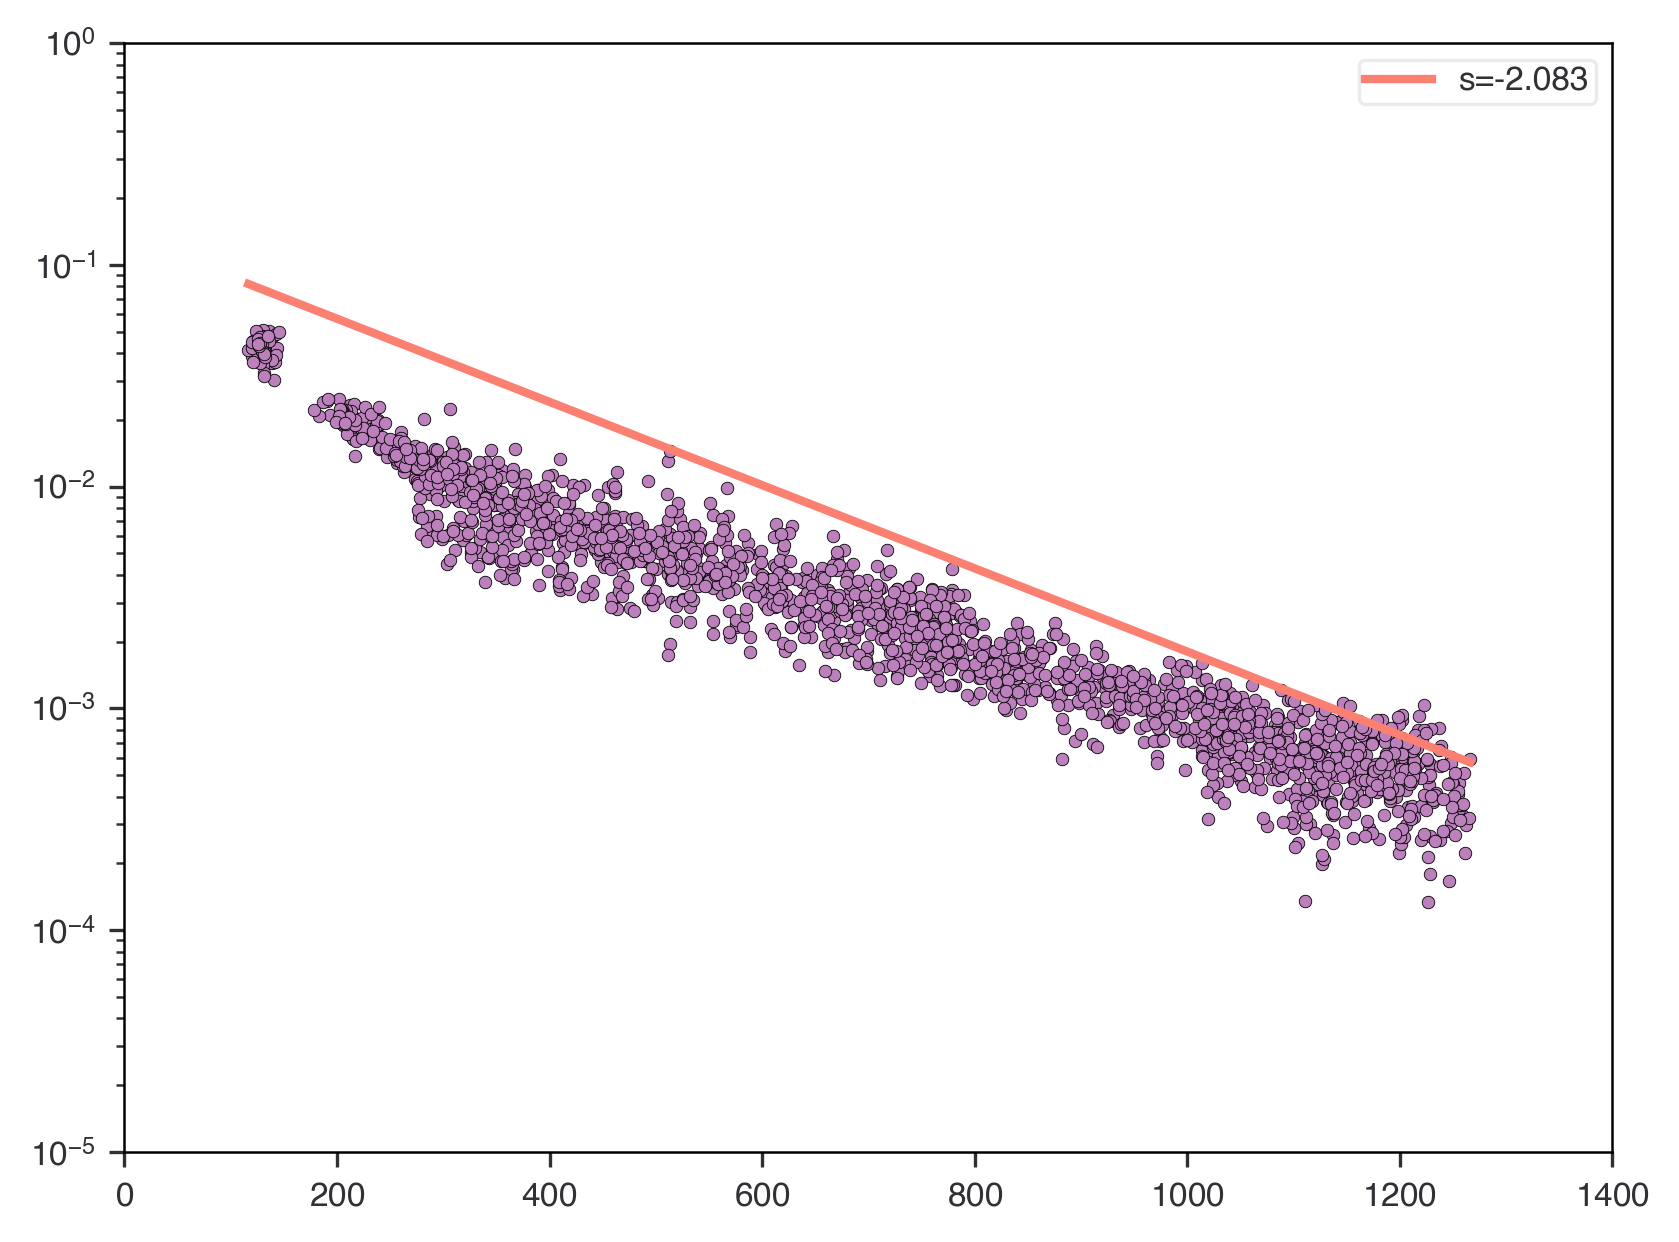

In [185]:
i,j = torch.triu_indices(64,64,1)
nearest_neighbors = torch.where(j-i==1)[0]

n=0
ii=72
for d in files:
    for f in files[d]:
        if n == ii:
            chrom,region_idx,start = parse_filename(f)
            
            exp_map = exp_hic.fetch(chrom,start,start+1_280_000)
            exp_probs = exp_map.prob_map[i,j].log10()
            #exp_probs/= torch.nanmean(exp_probs[nearest_neighbors]).log10()
            idx = torch.where(exp_probs.isfinite())[0]
            exp_probs = exp_probs[idx]
            
            mean_dists = (Coordinates(d+f).distances.mean.values[0,i,j] * 100)
        n+=1
        if n > ii:
            break
    if n > ii:
        break
            
import numpy as np

m,b = np.polyfit(mean_dists[idx].log10().cpu().numpy(),exp_probs.cpu().numpy(),1)

x = [mean_dists[idx].min(),mean_dists[idx].max()]
y = [ 10**(m*(xx.log10())+b) for xx in x ]

plt.plot(mean_dists[idx].cpu().numpy(),(10**exp_probs).cpu().numpy(),'.') 
plt.plot(x,y,label=f's={round(m,3)}')
plt.yscale('log')
plt.legend()

Compare many milestones!

(<Figure size 1920x1440 with 2 Axes>,
 <Axes: xlabel='Genomic index', ylabel='Genomic index'>,
 <matplotlib.colorbar.Colorbar at 0x7f32ae1f2830>)

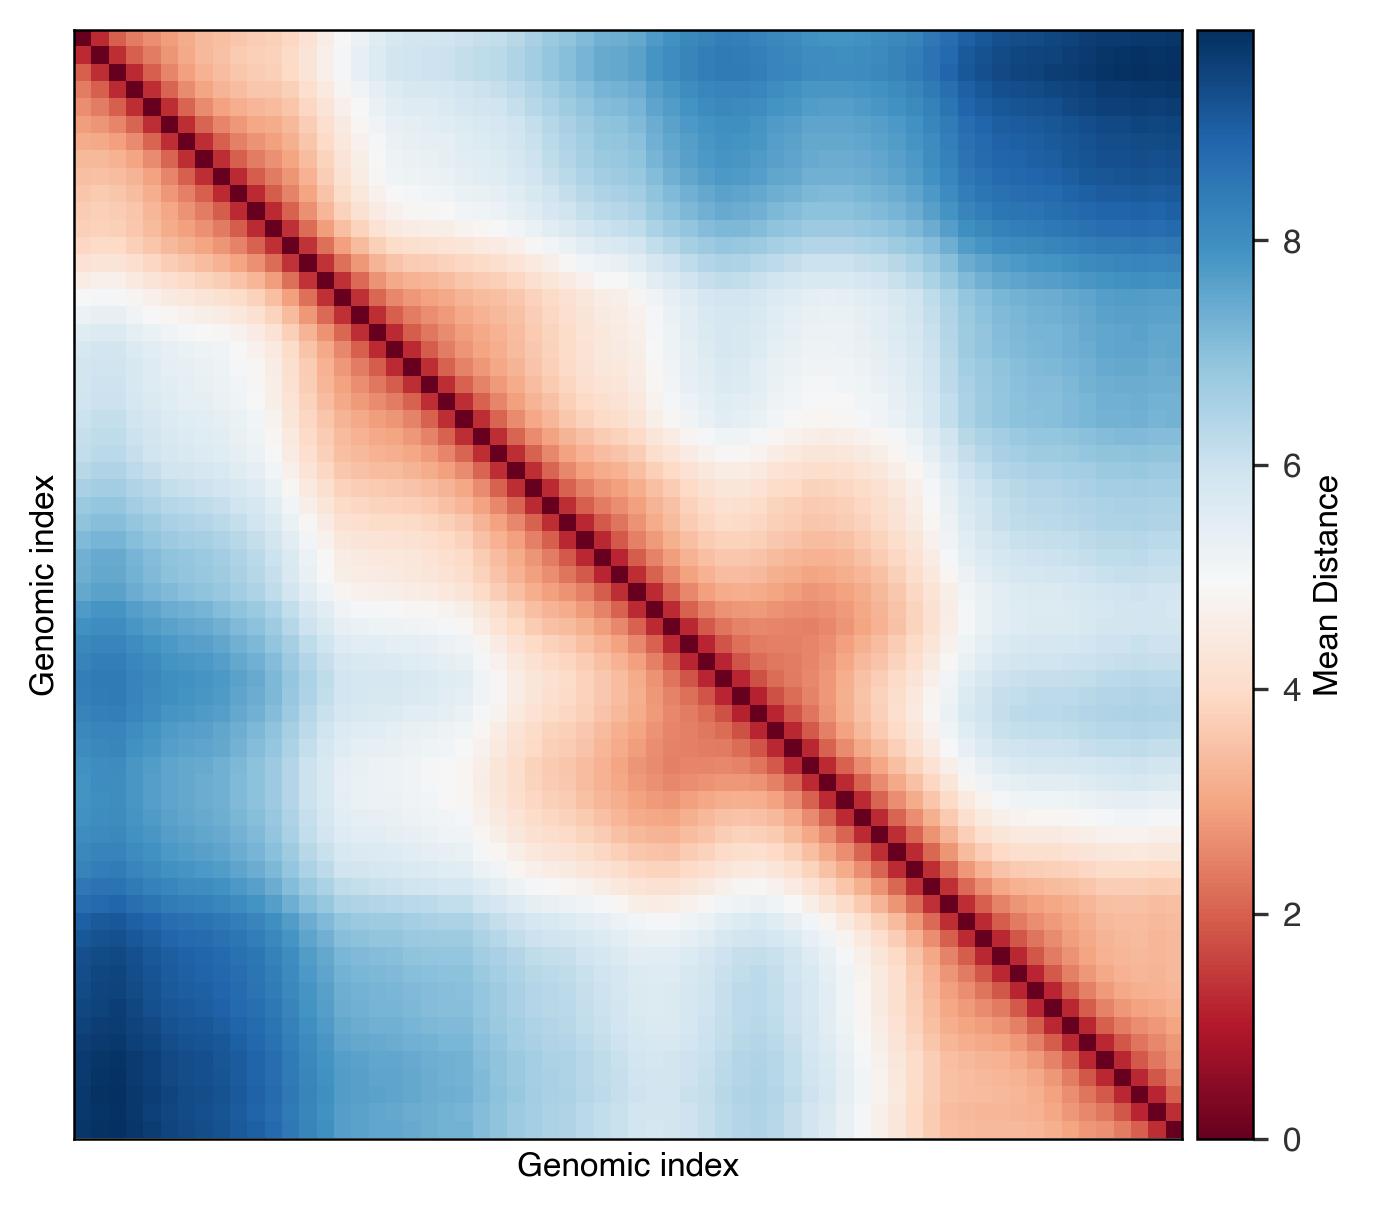

In [26]:
a = Coordinates('../data/samples/origami_64_no_embed_reduction/eval_mode/unused/sample_395_1.5_0.1_120_1.pt')
a.distances.mean.plot()

In [ ]:
folder = '../data/samples/origami_64_no_embed_reduction/eval_mode/unused/'
fp = lambda w,phi: folder + f'sample_395_{float(w)}_{float(phi)}_120_1.pt'

all_coor
for guidance in [k/2 for k in range(3,11)]:
    for phi in [k/10 for k in range(100)]:
        f = fp(guidance,phi)
        if os.path.exists(f):
            

conformations_to_probs(a).plot()

(<Figure size 1920x1440 with 2 Axes>,
 <Axes: xlabel='Genomic index', ylabel='Genomic index'>,
 <matplotlib.colorbar.Colorbar at 0x7f32ae2a1bd0>)

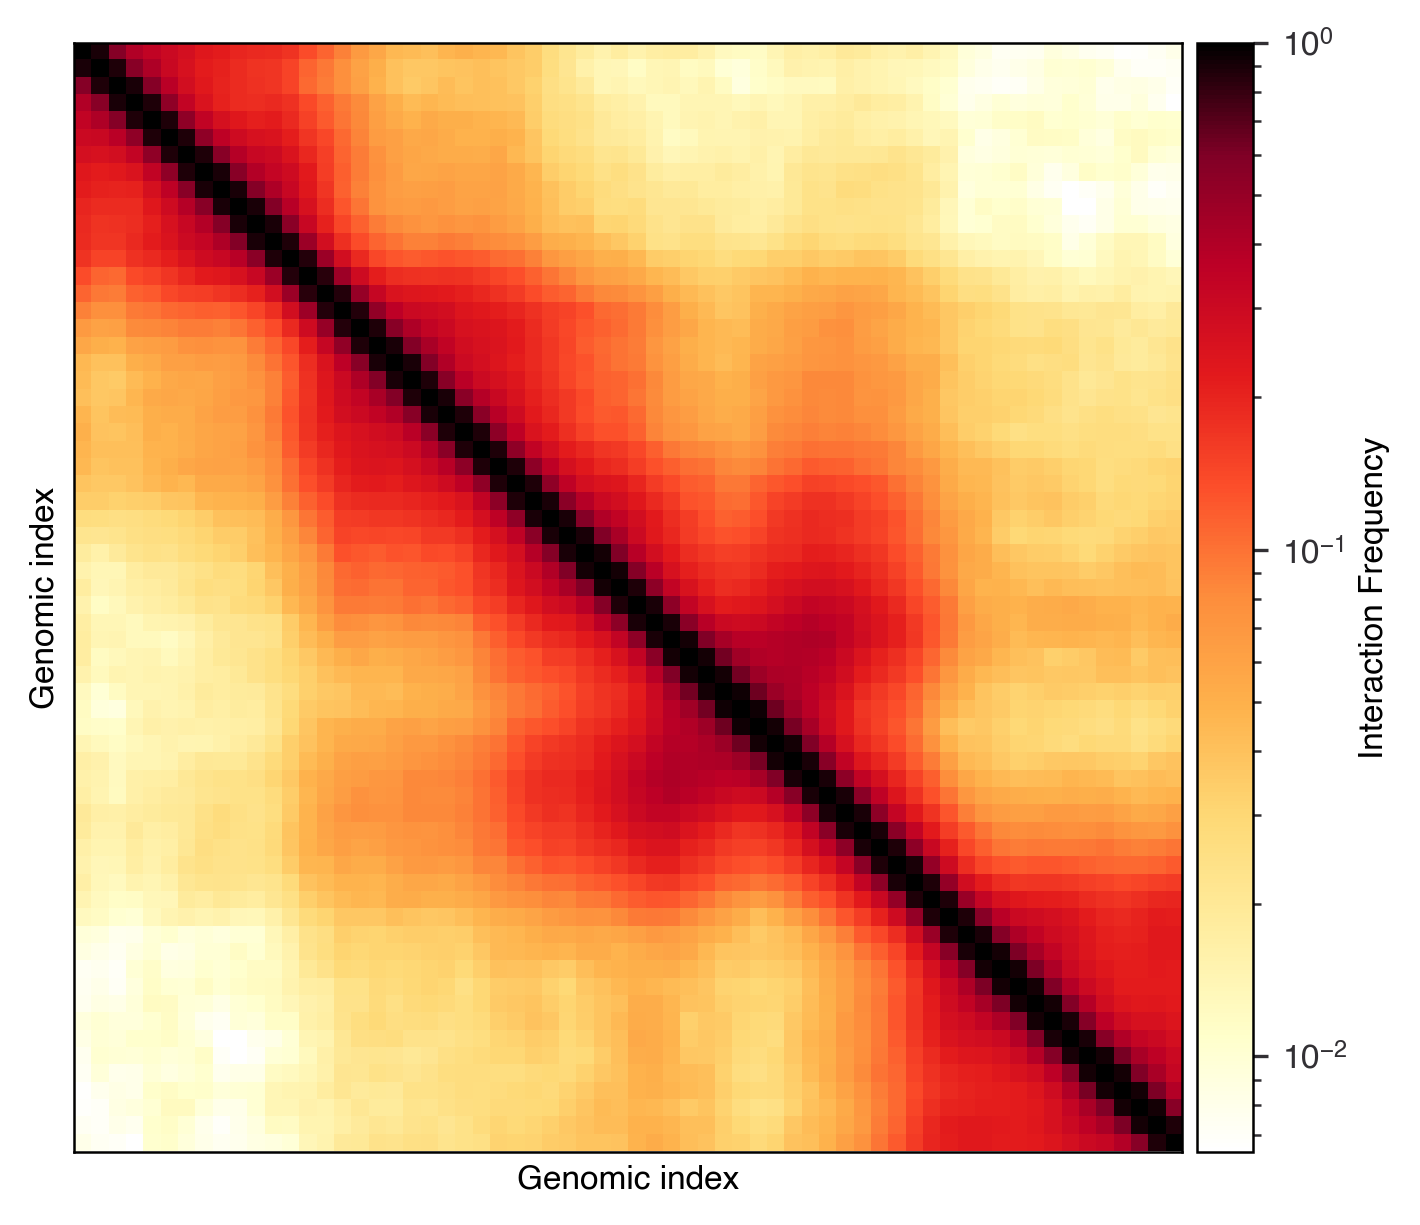

In [29]:
conformations_to_probs(a).plot()

In [47]:
coords = Coordinates('../data/samples/origami_64_no_embed_reduction/eval_mode/unused/sample_395_1.5_0.1_120_1.pt')
coords = coords.append(
    [
        Coordinates('../data/samples/origami_64_no_embed_reduction/eval_mode/sample_395_5.0_8.0_120_1.pt')[:1000],
        Coordinates('../data/samples/origami_64_no_embed_reduction/eval_mode/unused/sample_395_2.0_0.1_120_1.pt'),
        Coordinates('../data/samples/origami_64_no_embed_reduction/eval_mode/unused/sample_395_2.5_0.1_120_1.pt'),
        Coordinates('../data/samples/origami_64_no_embed_reduction/eval_mode/unused/sample_395_3.0_0.3_120_1.pt'),
        Coordinates('../data/samples/origami_64_no_embed_reduction/eval_mode/unused/sample_395_3.5_0.1_120_1.pt'),
        Coordinates('../data/samples/origami_64_no_embed_reduction/eval_mode/unused/sample_395_4.0_0.5_120_1.pt'),
        Coordinates('../data/samples/origami_64_no_embed_reduction/eval_mode/unused/sample_395_4.5_0.1_120_1.pt'),
    ]
)

(<Figure size 1920x1440 with 2 Axes>,
 <Axes: xlabel='Genomic index', ylabel='Genomic index'>,
 <matplotlib.colorbar.Colorbar at 0x7f3268193be0>)

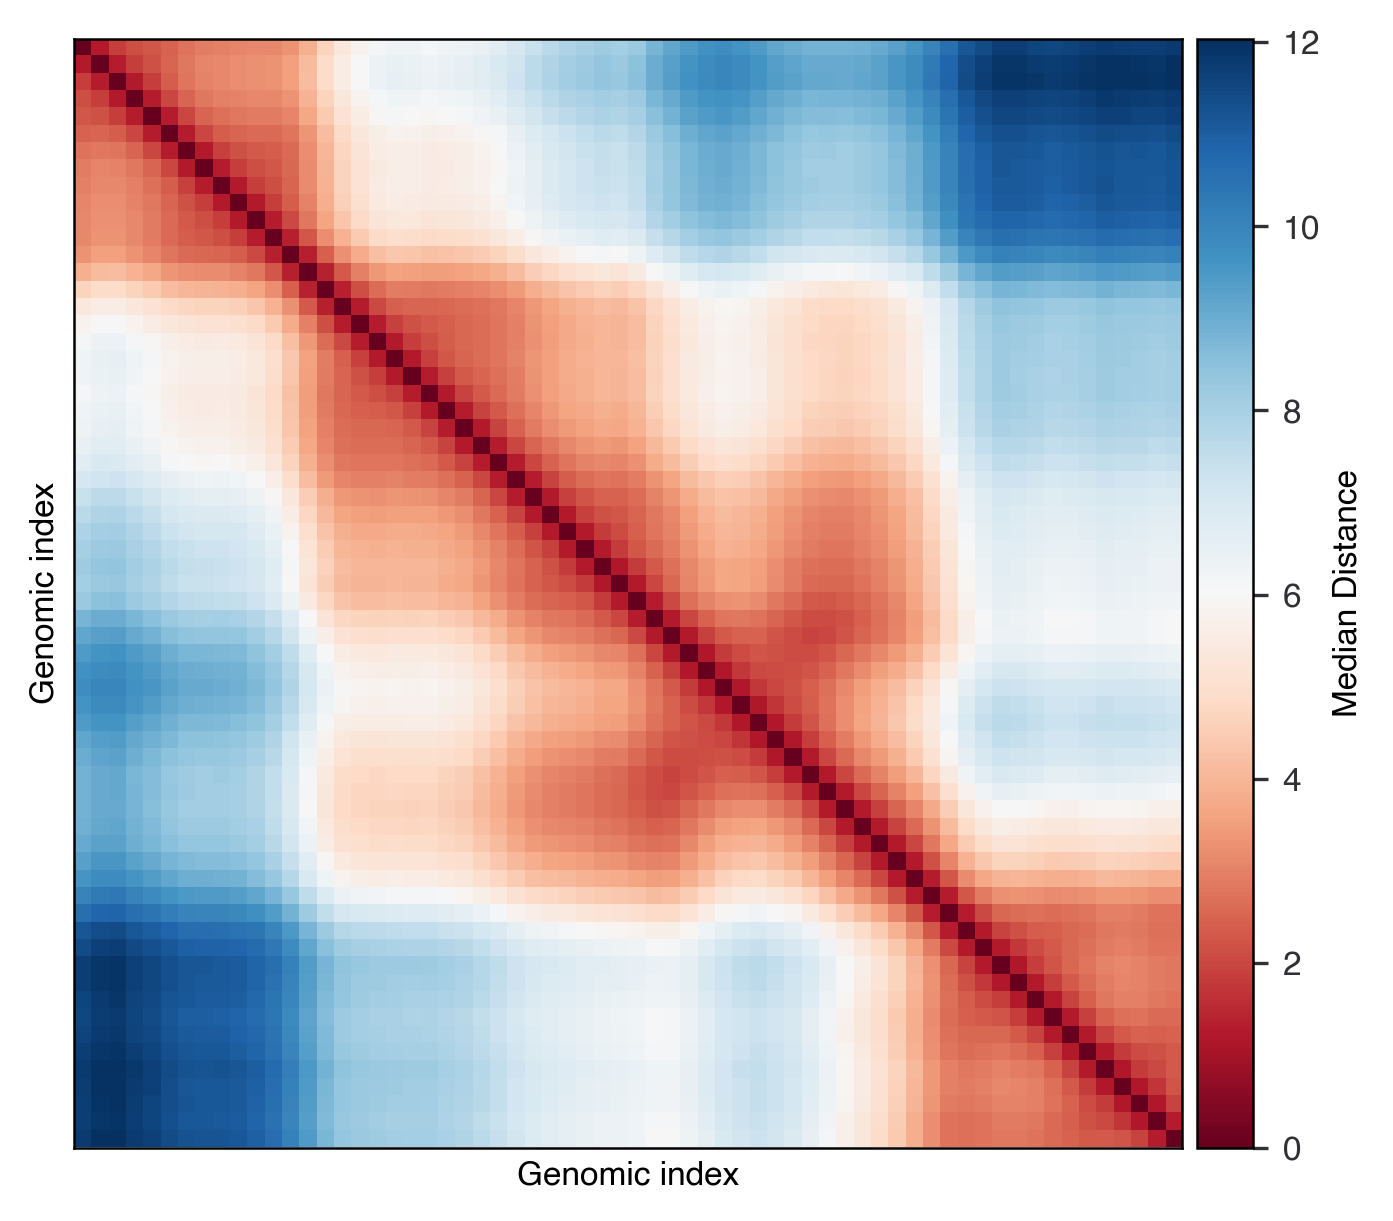

In [50]:
coords.distances.median.plot()

Text(0, 0.5, 'Median distance')

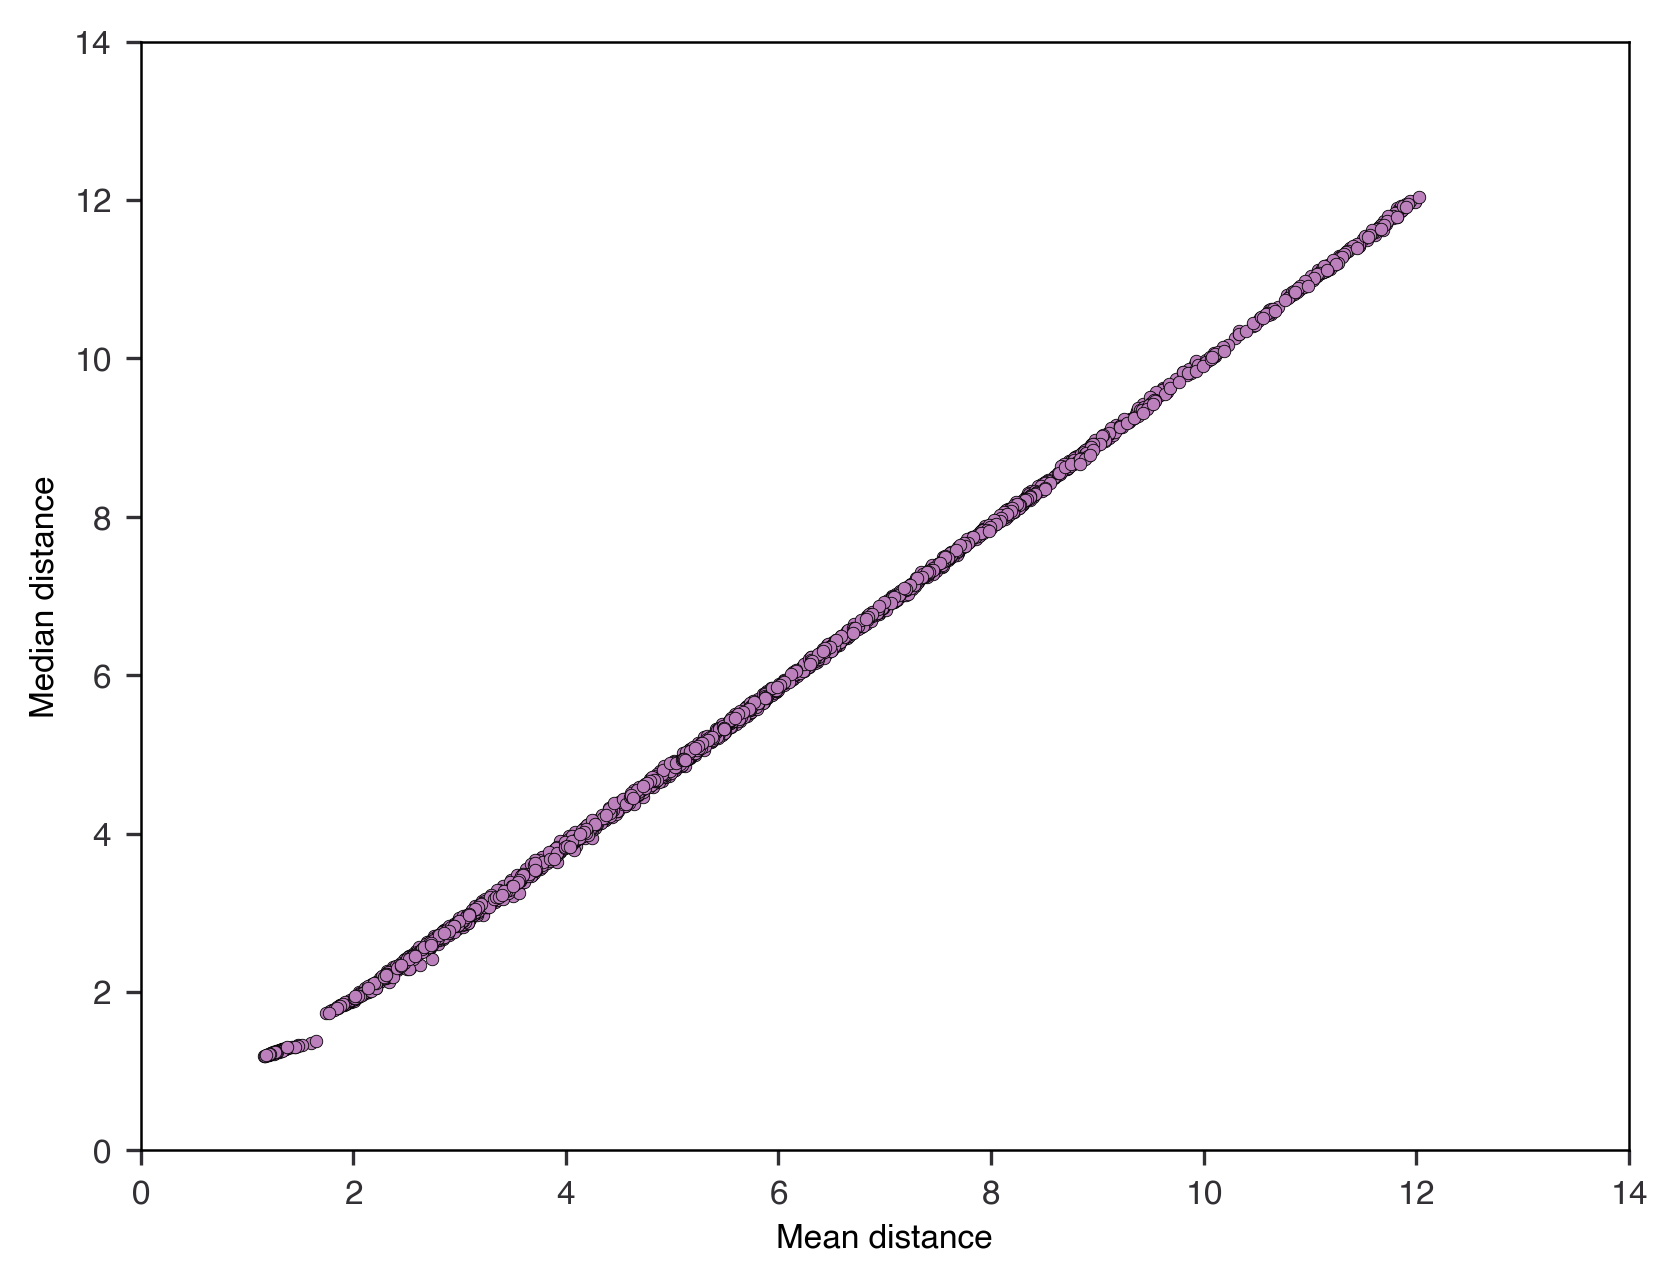

In [52]:
i,j = torch.triu_indices(64,64,1)

a = coords.distances
b = a.median.values[0,i,j]
a = a.mean.values[0,i,j]

plt.plot(a,b,'.')
plt.xlabel('Mean distance')
plt.ylabel('Median distance')


(<Figure size 1920x1440 with 2 Axes>,
 <Axes: xlabel='Genomic index', ylabel='Genomic index'>,
 <matplotlib.colorbar.Colorbar at 0x7f3244749840>)

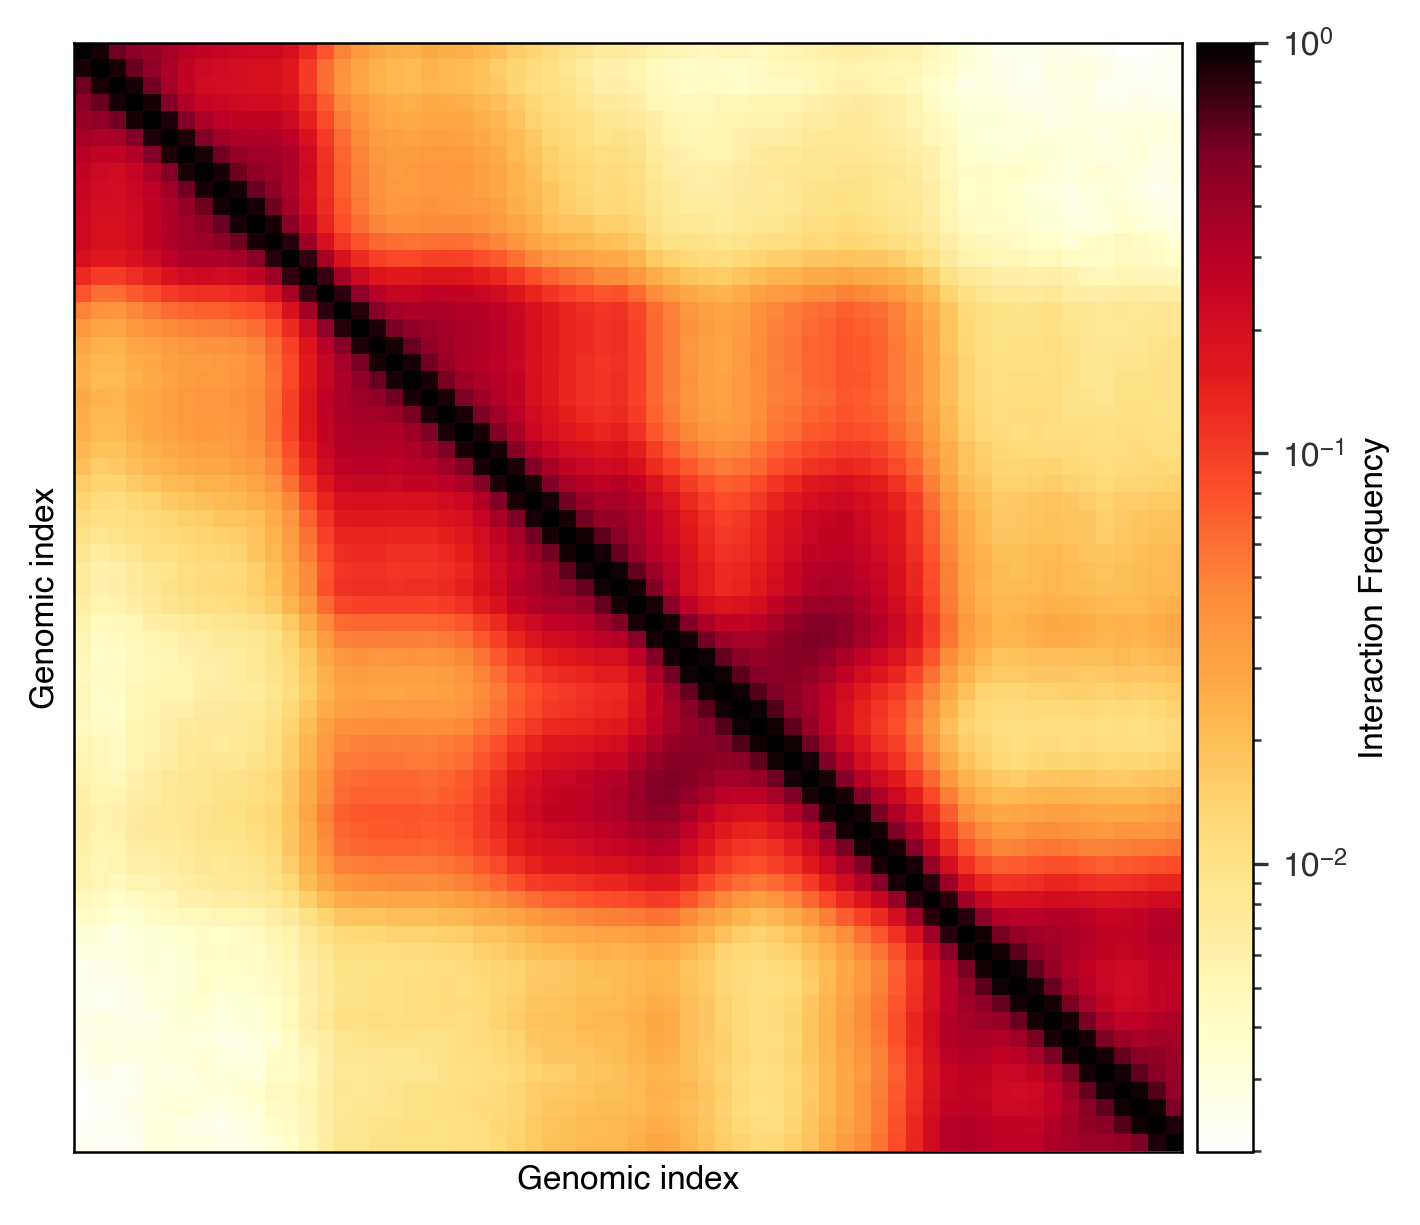

In [51]:
conformations_to_probs(coords).plot()

(<Figure size 1920x1440 with 2 Axes>,
 <Axes: xlabel='Genomic index', ylabel='Genomic index'>,
 <matplotlib.colorbar.Colorbar at 0x7f324459c700>)

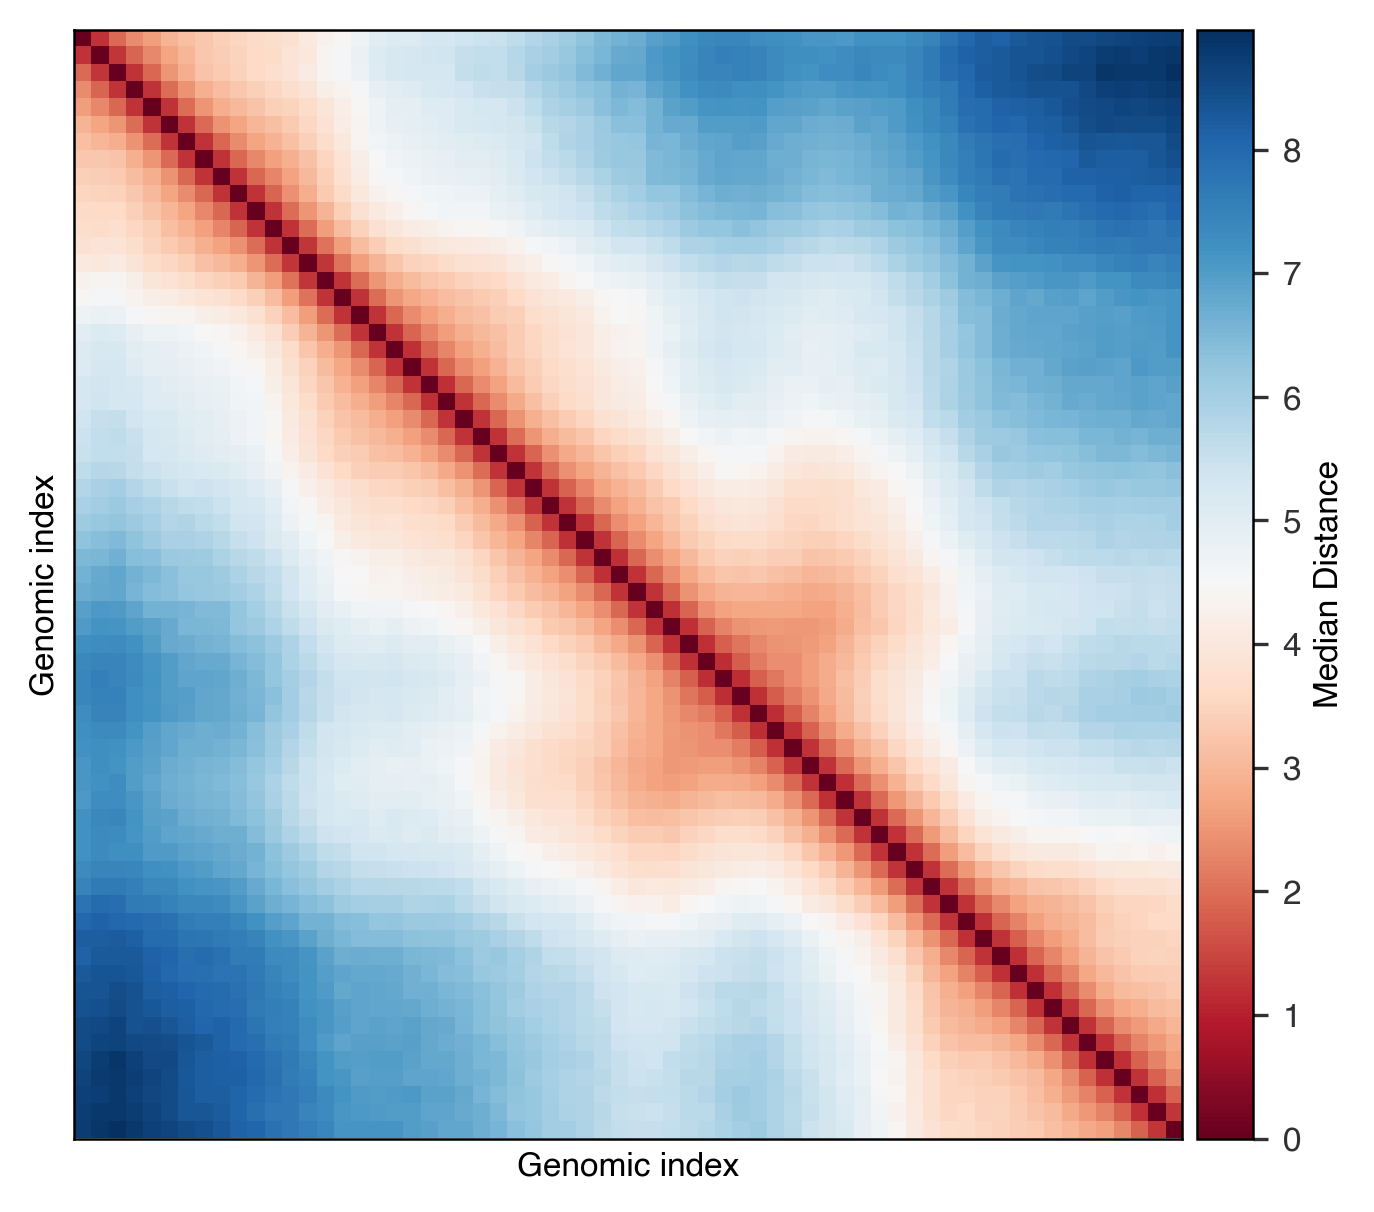

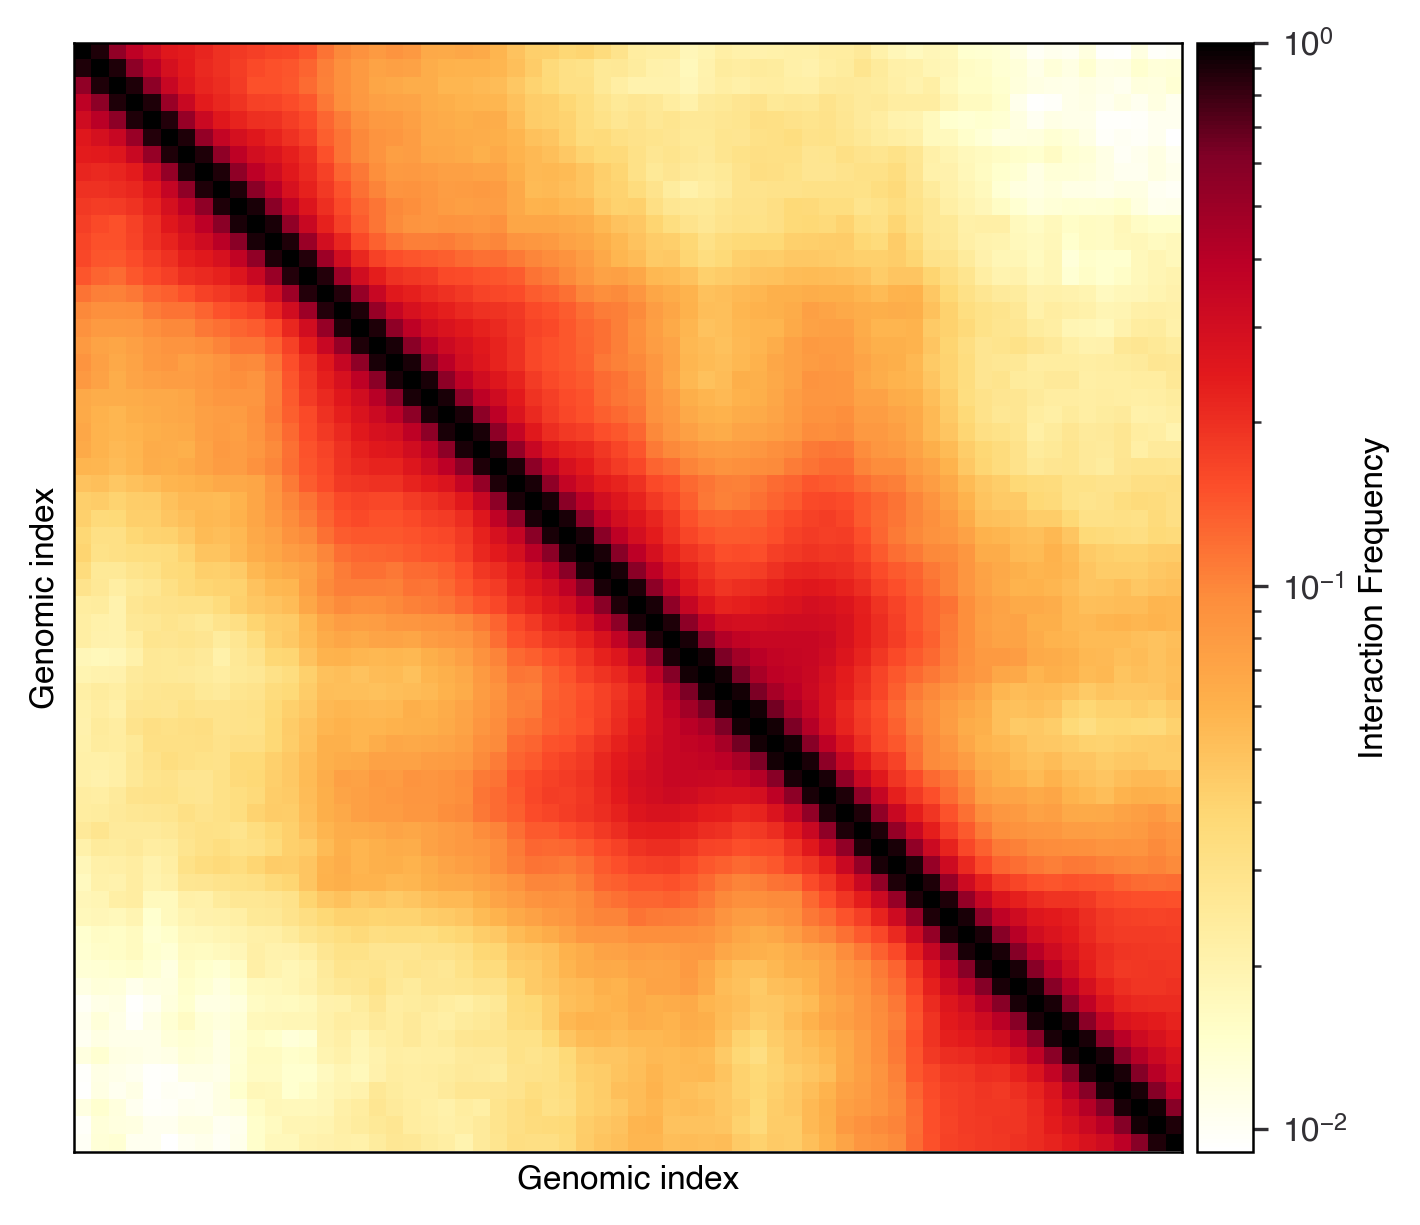

In [53]:
coords = Coordinates('../data/samples/origami_64_no_embed_reduction/eval_mode/unused/sample_395_1.0_0.0_120_1.pt')
coords.distances.median.plot()
conformations_to_probs(coords).plot()

(<Figure size 1920x1440 with 2 Axes>,
 <Axes: xlabel='Genomic index', ylabel='Genomic index'>,
 <matplotlib.colorbar.Colorbar at 0x7f324429d930>)

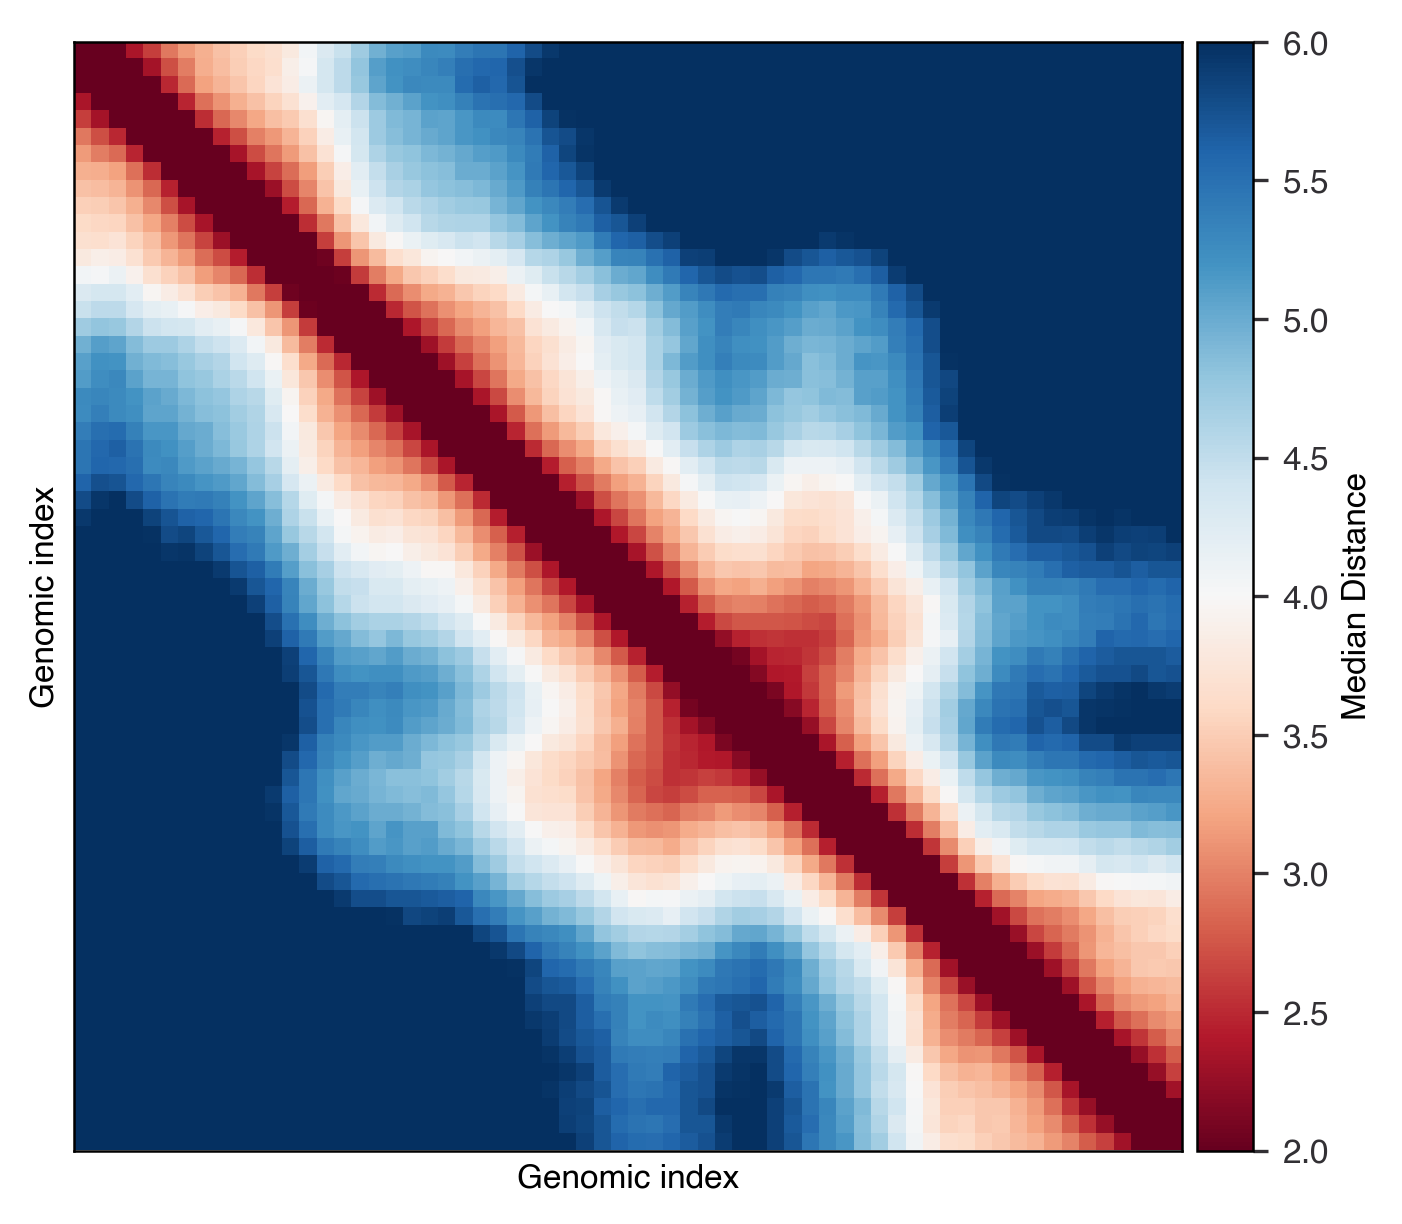

In [56]:
coords.distances.median.plot(vmin=2,vmax=6)

In [ ]:
rosetta = pd.read_pickle('../data/embeddings_64_after_transformer/rosetta_stone.pkl')

In [98]:
def conformations_to_probs(conformations,sigma=sigma,r_c=r_c):
    p = conformations.distances.values.clone()
    mask = p < r_c
    p[mask] = ( (sigma*(r_c-p[mask])).tanh() + 1 )/2
    mask^= True
    p[mask] = (r_c/p[mask])**4 / 2
    p = p.mean(0)
    return HiCMap(p)

In [120]:
def conformations_to_probs(conformations,sigma=6,r_c=.5):
    p = conformations.distances.values.clone()
    
    mask = p < r_c
    p[mask] = ( (sigma*(r_c-p[mask])).tanh() + 1 )/2
    mask^= True
    p[mask] = (r_c/p[mask])**3.45 / 2
    p = p.mean(0)
    '''
    mask = p < (2 ** (1/3) * r_c)
    p[mask] = 1
    mask^= True
    p[mask] = (r_c/p[mask])**3.45
    p = p.mean(0)
    '''
    return HiCMap(p)

(<Figure size 1920x1440 with 2 Axes>,
 <Axes: xlabel='Genomic index', ylabel='Genomic index'>,
 <matplotlib.colorbar.Colorbar at 0x7f31caa14eb0>)

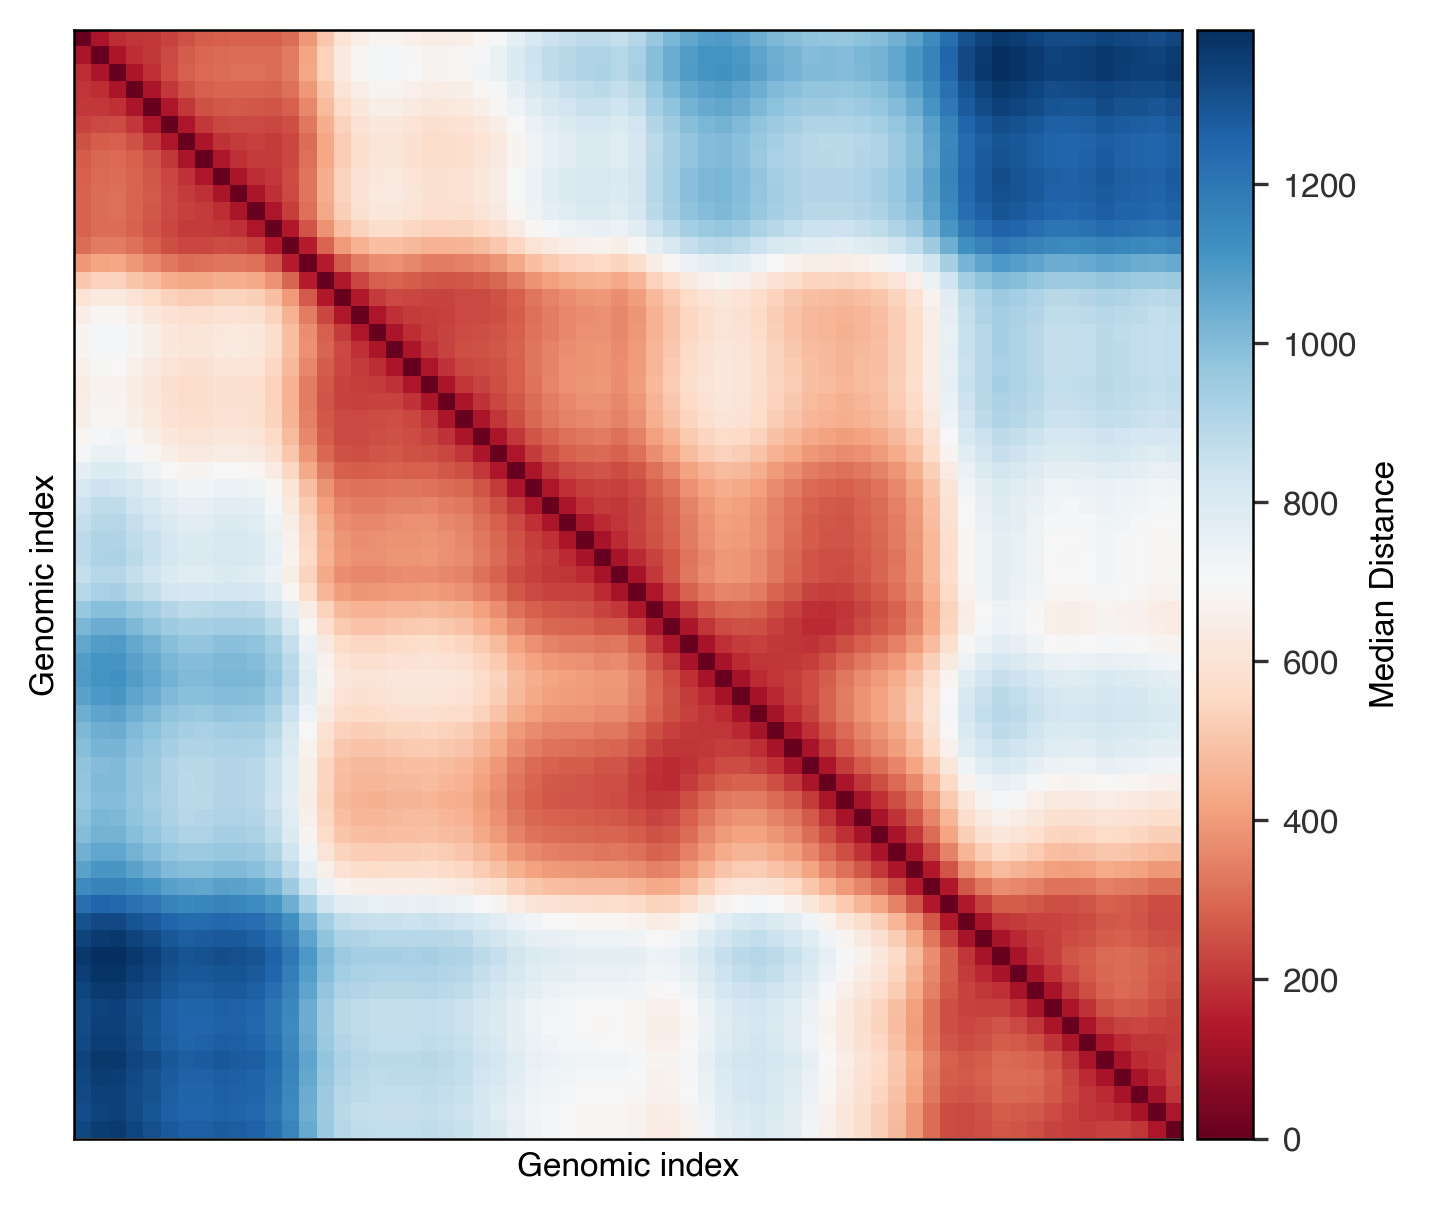

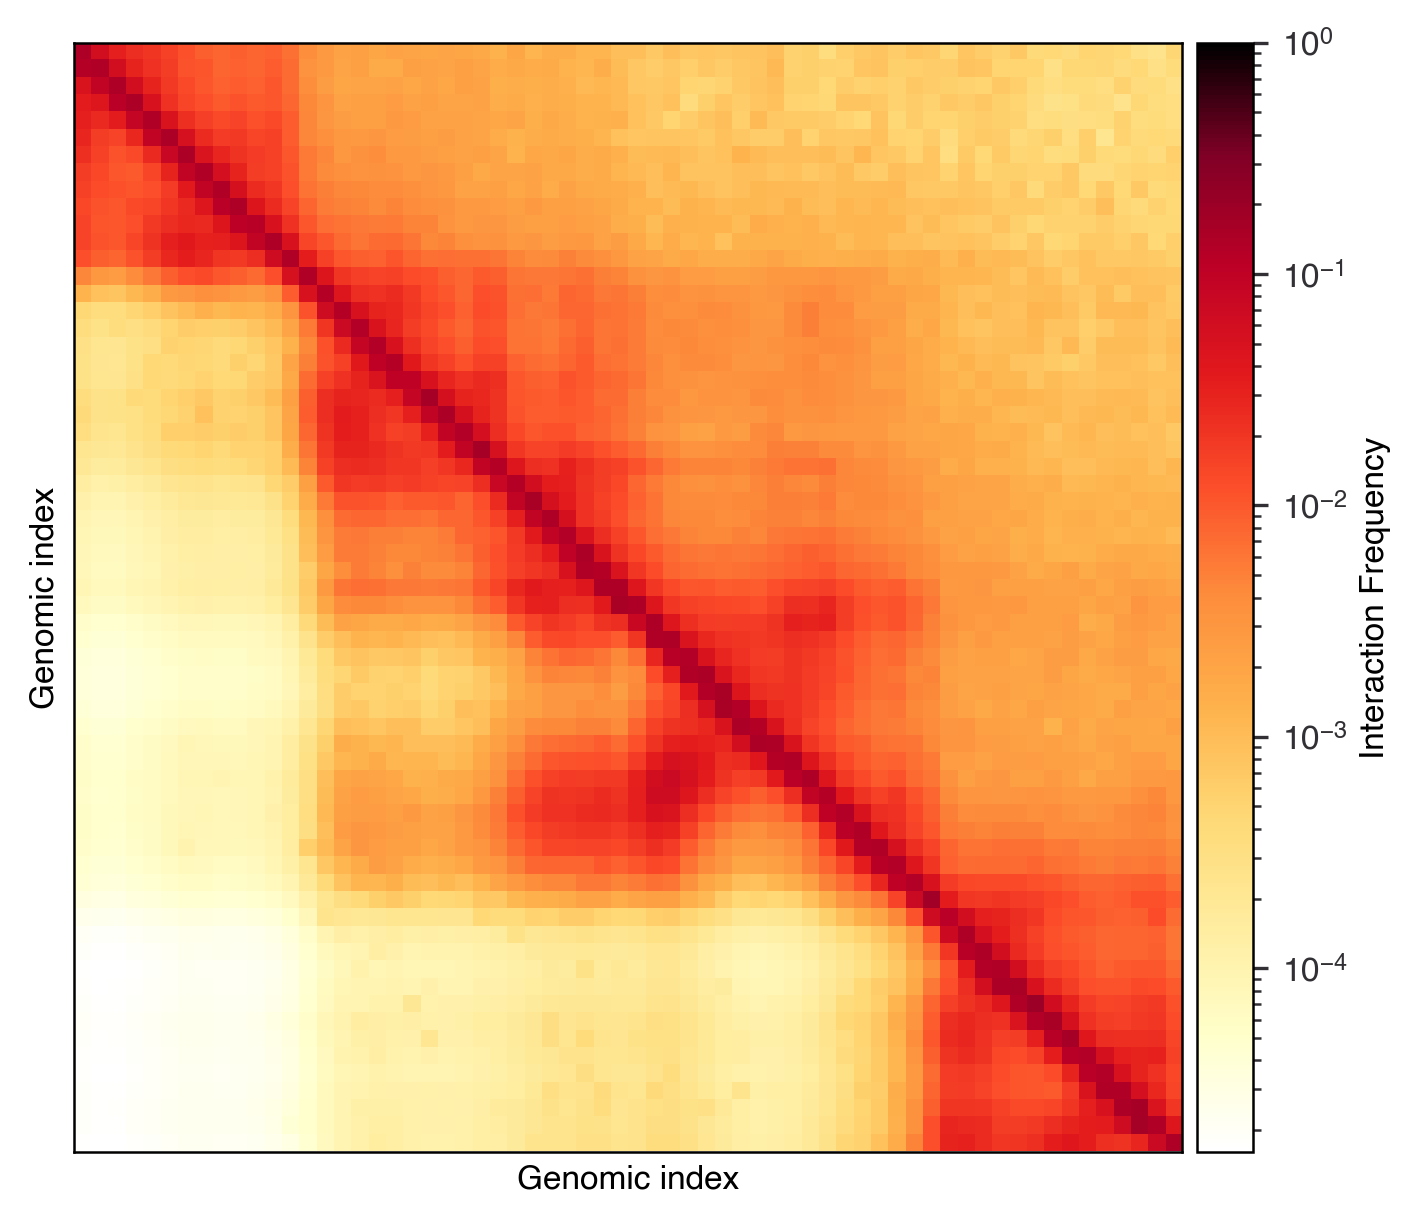

In [80]:
chrom = '1'
region_idx = 395
'''
cond_scale = 2.0
rescaled_phi = 0.1
folder = '../data/samples/origami_64_no_embed_reduction/eval_mode/unused/'
'''
cond_scale = 5.0
rescaled_phi = 8.0
folder = '../data/samples/origami_64_no_embed_reduction/eval_mode/'

coords = Coordinates(
    folder + f'sample_{region_idx}_{float(cond_scale)}_{float(rescaled_phi)}_120_{chrom}.pt'
)

#####
# Median distance map
d = coords.distances.median
d._values*= 100 # to nm
d.plot()

#####
# Hi-C 

# Experimental Hi-C, normalized to nearest neighbor value
start = rosetta[chrom][region_idx][-1]
stop = start + 1_280_000
exp_map = gm_hic.fetch('1',start,stop)
#exp_map.prob_map/= exp_map.prob_map[range(63),range(1,64)].mean()

# Plot against generated Hi-C 
exp_map.plot_with(conformations_to_probs(coords))

Text(0.5, 1.0, '$\\rho=0.9492049902936326$\n$\\sigma=3.72$; $r_c=1.5$')

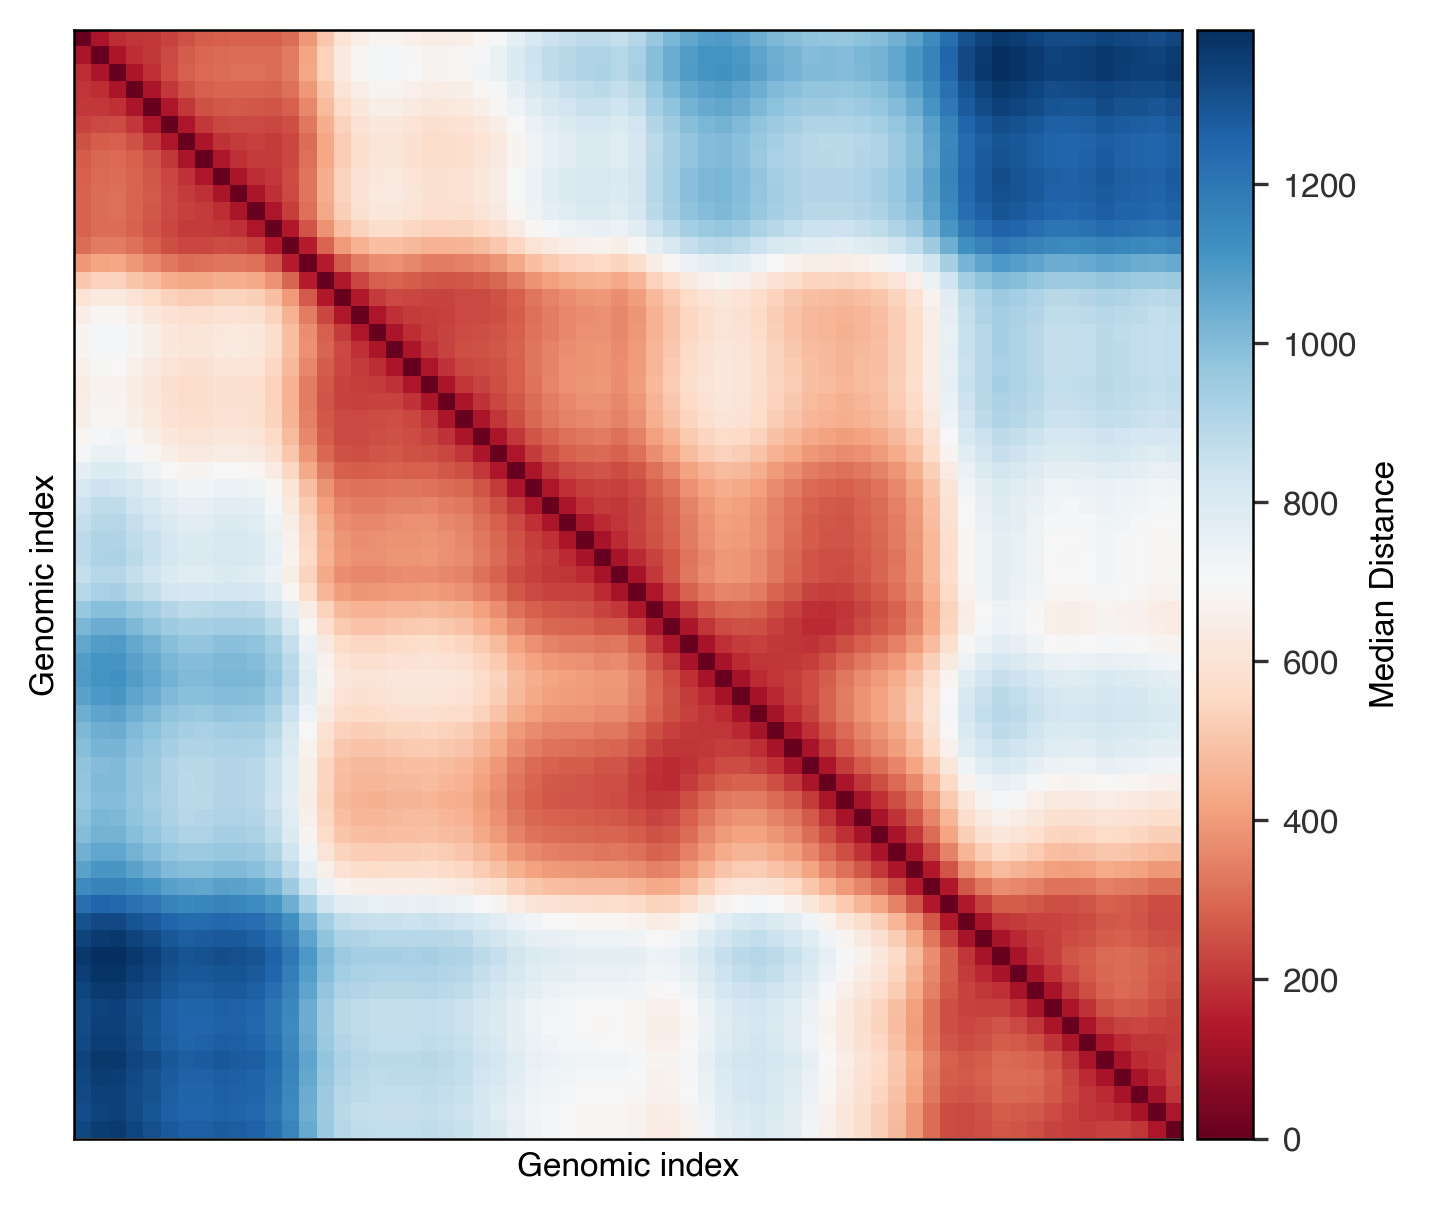

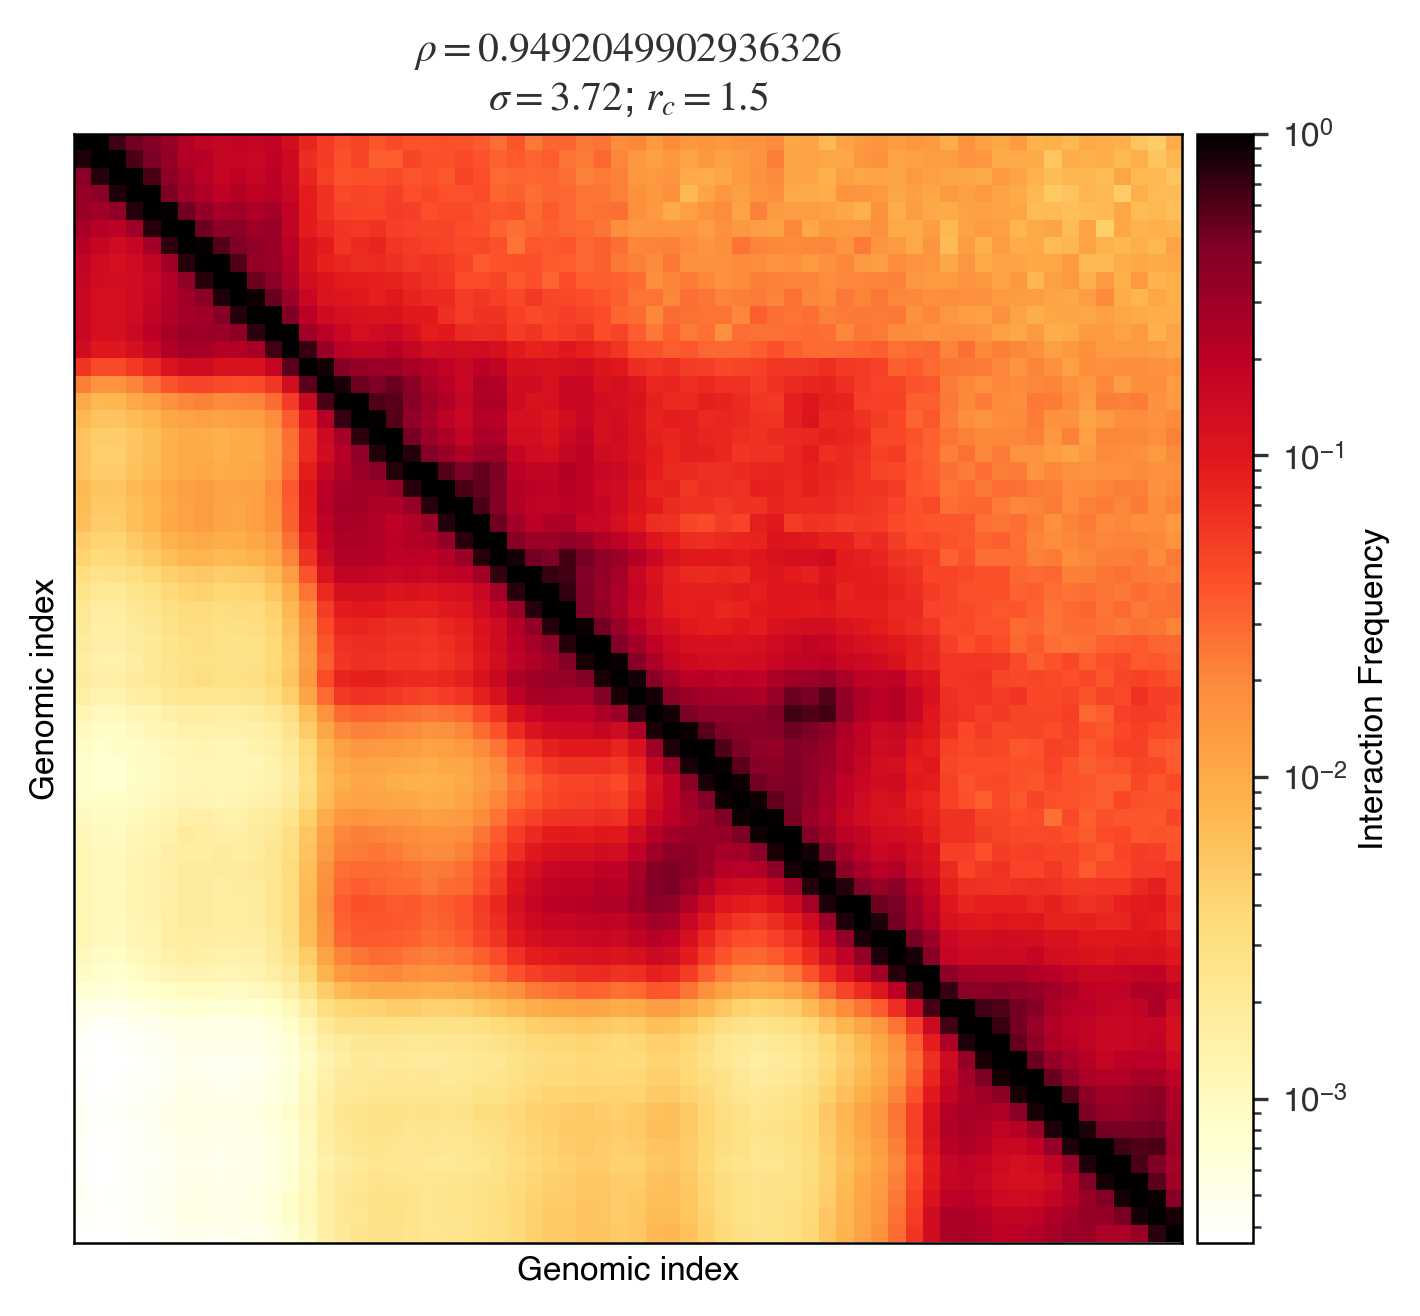

In [153]:
chrom = '1'
region_idx = 395
'''
cond_scale = 1#2.0
rescaled_phi = 0#0.1
folder = '../data/samples/origami_64_no_embed_reduction/eval_mode/unused/'
'''
cond_scale = 5.0
rescaled_phi = 8.0
folder = '../data/samples/origami_64_no_embed_reduction/eval_mode/'

r_c = 1.5
sigma = 3.72

coords = Coordinates(
    folder + f'sample_{region_idx}_{float(cond_scale)}_{float(rescaled_phi)}_120_{chrom}.pt'
)

#####
# Median distance map
d = coords.distances.median
d._values*= 100 # to nm
d.plot()

#####
# Hi-C 

# Experimental Hi-C, normalized to nearest neighbor value
start = rosetta[chrom][region_idx][-1]
stop = start + 1_280_000
exp_map = gm_hic.fetch('1',start,stop)
exp_map.prob_map/= exp_map.prob_map[range(63),range(1,64)].mean()

# Plot against generated Hi-C 
_,ax,*_=exp_map.plot_with(conformations_to_probs(coords,sigma=10,r_c=1.5))

i,j = torch.triu_indices(64,64,1)

x = exp_map.prob_map[i,j]
y = conformations_to_probs(coords,sigma=sigma,r_c=r_c).prob_map[i,j]
ax.set_title(
    '$\\rho='+f'{torch.corrcoef(torch.stack([x,y],dim=0))[0,1]}$'+'\n'+\
    '$\\sigma='+ f'{sigma}'+'$; $r_c=' + f'{r_c}' + '$'
)
#ax.set_title(
#    '$\\rho='+f'{torch.corrcoef(torch.stack([x,y],dim=0))[0,1]}$'+'\n'+\
#    'Power law only: $r_c=' + f'{r_c}' + '$'
#)


#### Combine probabilities!

In [ ]:
from Distances import Distances

Text(0.5, 1.0, '$\\rho=0.9632724362165432$\n$\\sigma=3.72$; $r_c=1.5$, $w=1$ influence: 0.632')

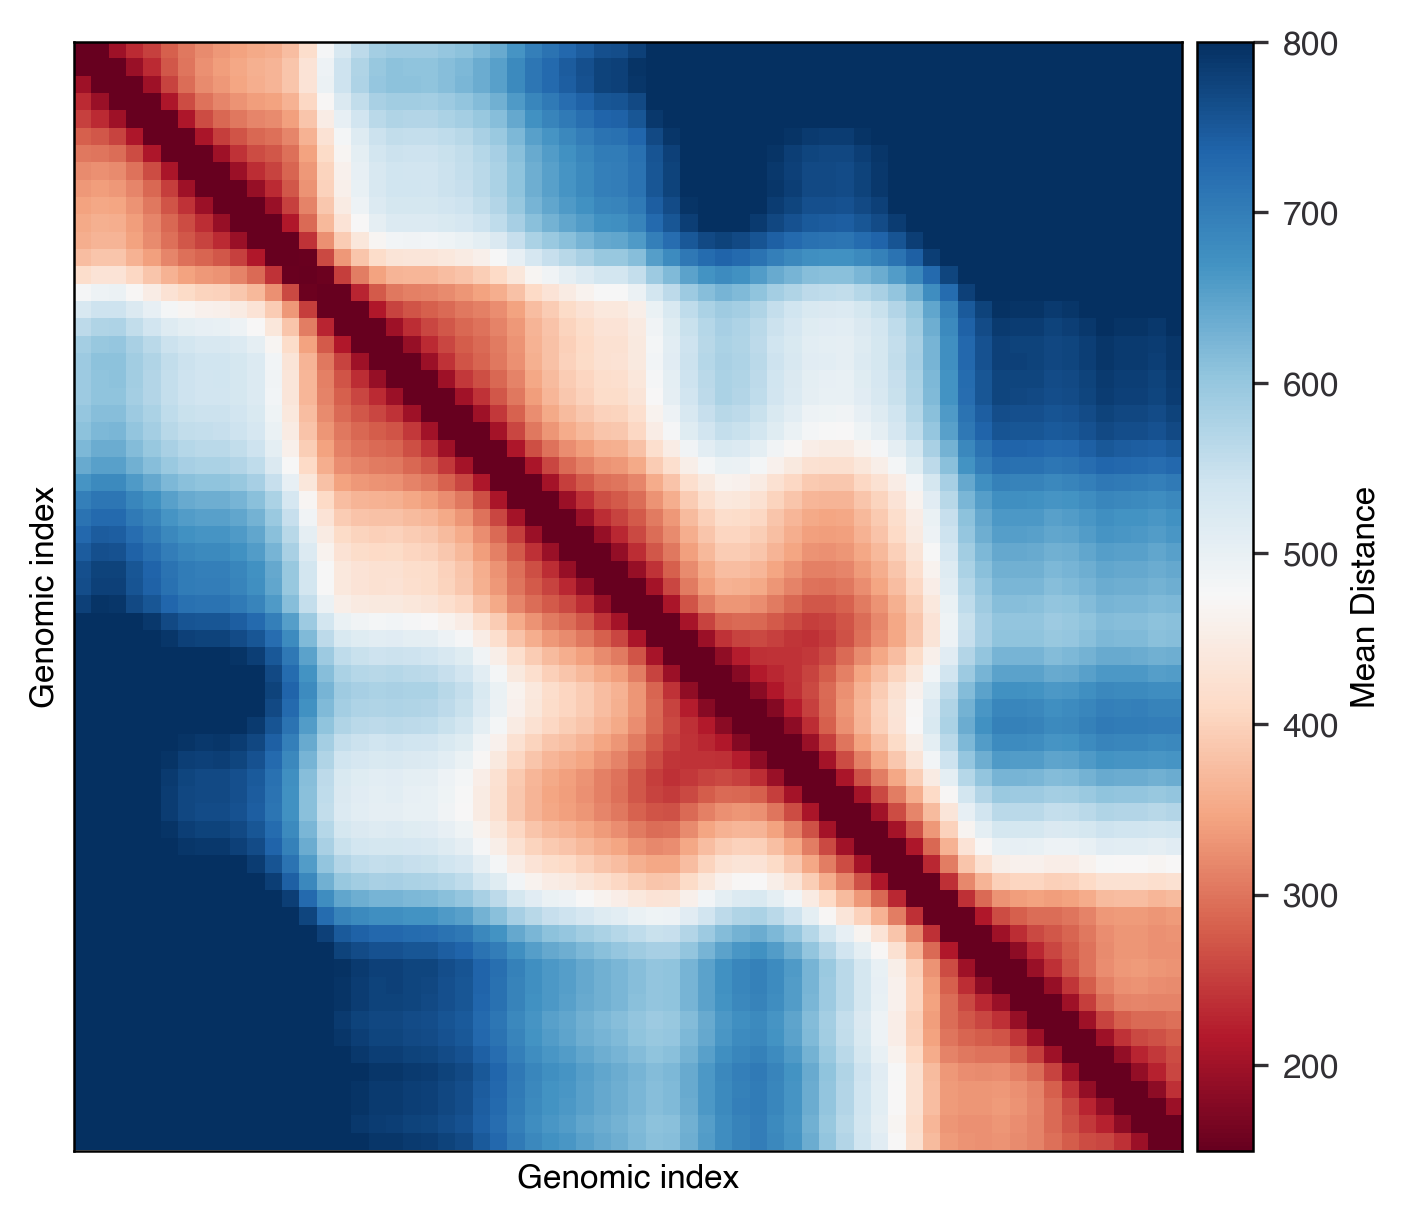

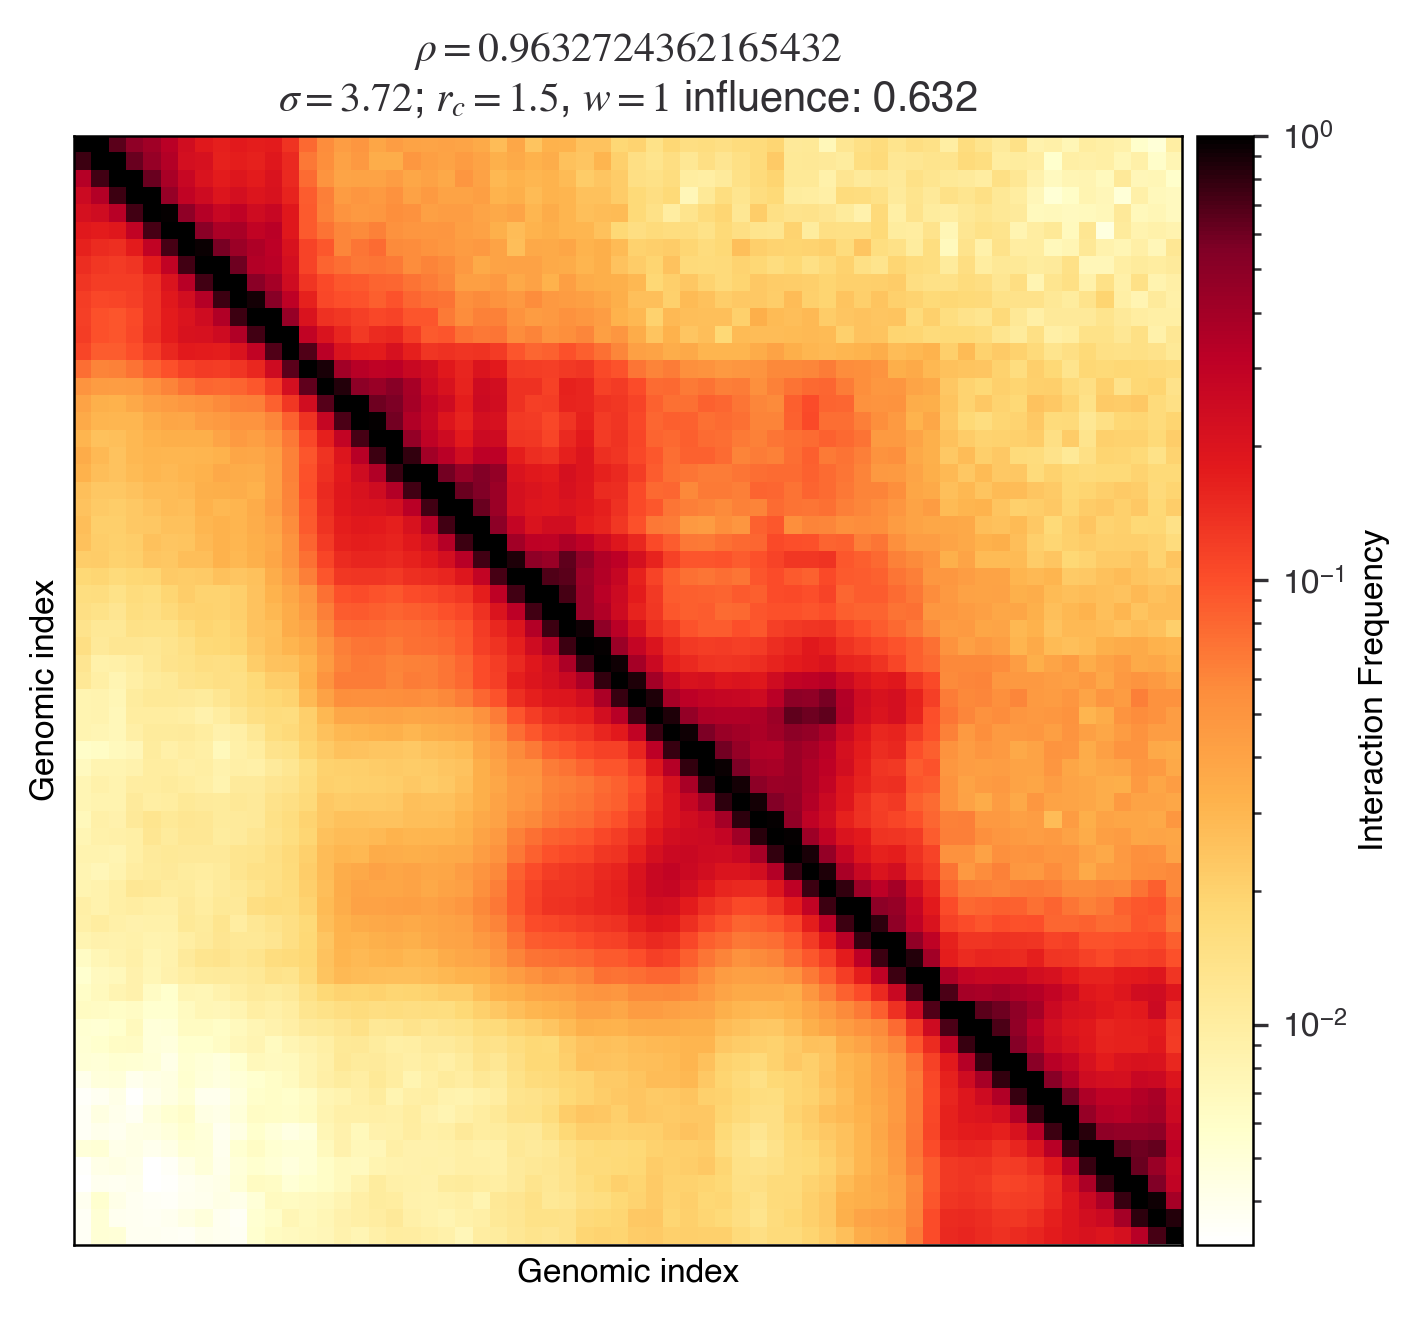

In [191]:
chrom = '1'
region_idx = 395

combos = [
    (1,0,'../data/samples/origami_64_no_embed_reduction/eval_mode/unused/'),
    #(.5,0,'../data/samples/origami_64_no_embed_reduction/pt_files/'),
    (5,8,'../data/samples/origami_64_no_embed_reduction/eval_mode/')
]

# To index upper triangle
i,j = torch.triu_indices(64,64,1)

# Target probabilities
start = rosetta[chrom][region_idx][-1]
stop = start + 1_280_000
exp_map = gm_hic.fetch('1',start,stop)
exp_map.prob_map/= exp_map.prob_map[range(63),range(1,64)].mean()
target = exp_map.prob_map[i,j]

# Experimental probabilities, to combine
all_probs = []
all_coords = []
for cond_scale,rescaled_phi,folder in combos:

    f = folder + f'sample_{region_idx}_{float(cond_scale)}_{float(rescaled_phi)}_120_{chrom}.pt'
    if cond_scale >= 1:
        coords = Coordinates(f)
    else:
        coords = Distances(torch.load(f)).unfold().unnormalize().coordinates

    all_coords.append(coords)
    
    all_probs.append(
        conformations_to_probs(
            coords,
            sigma=sigma,
            r_c=r_c
        ).prob_map[i,j]
    )

scores = []
lin_scales = torch.arange(0,1.001,.001)
for c in lin_scales:
    temp_probs = all_probs[0] * c + all_probs[1] * (1-c)
    scores.append(
        torch.corrcoef(torch.stack([temp_probs,target],dim=0))[0,1]
        #r2_score(temp_probs,target)
    )

scores = torch.tensor(scores)
idx = torch.where(scores==scores.max())

best_lin_scale = lin_scales[idx]

######
# Plot

# Experimental Hi-C, normalized to nearest neighbor value
start = rosetta[chrom][region_idx][-1]
stop = start + 1_280_000
exp_map = gm_hic.fetch('1',start,stop)
exp_map.prob_map/= exp_map.prob_map[range(63),range(1,64)].mean()

# Combine data

all_probs = []
for k,(cond_scale,rescaled_phi,folder) in enumerate(combos):
    temp_map = conformations_to_probs(
        all_coords[k],
        #Coordinates(
        #    folder + f'sample_{region_idx}_{float(cond_scale)}_{float(rescaled_phi)}_120_{chrom}.pt'
        #),
        sigma=sigma,
        r_c=r_c
    )
    all_probs.append(temp_map)
    if k == 0:
        gen_map = temp_map
        median_dists = all_coords[k].distances.mean
    else:
        gen_map.prob_map*= best_lin_scale
        gen_map.prob_map+= temp_map.prob_map * (1-best_lin_scale)
        median_dists._values*= best_lin_scale
        median_dists._values+= all_coords[k].distances.mean.values*(1-best_lin_scale)
        median_dists._values*= 100

median_dists.plot(vmin=150,vmax=800)

# Plot against generated Hi-C 
_,ax,*_=exp_map.plot_with(gen_map)

#i,j = torch.triu_indices(64,64,1)

#x = exp_map.prob_map[i,j]
#y = conformations_to_probs(coords,sigma=sigma,r_c=r_c).prob_map[i,j]
ax.set_title(
    '$\\rho='+f'{scores.max()}$'+'\n'+\
    '$\\sigma='+ f'{sigma}'+'$; $r_c=' + f'{r_c}$, $w=1$ influence: {float(best_lin_scale):.3}'
)

(<Figure size 1920x1440 with 2 Axes>,
 <Axes: xlabel='Genomic index', ylabel='Genomic index'>,
 <matplotlib.colorbar.Colorbar at 0x7f31c94a37c0>)

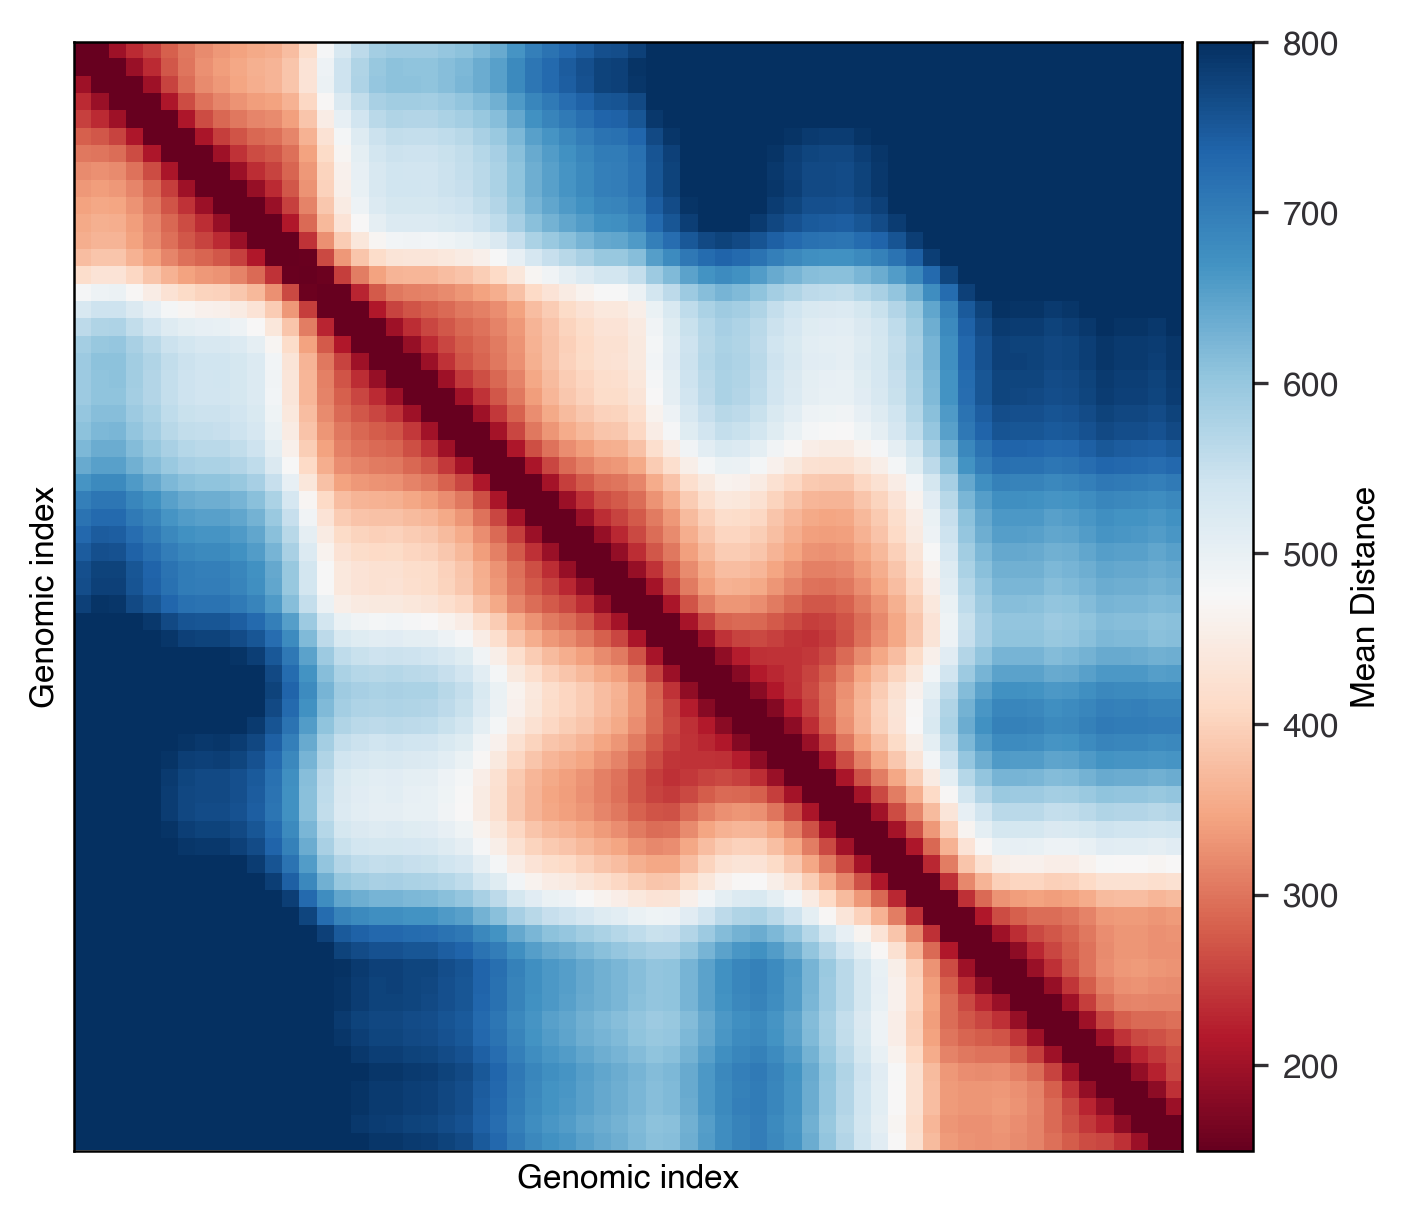

In [184]:
median_dists.plot(vmin=150,vmax=800)

(<Figure size 1920x1440 with 2 Axes>,
 <Axes: xlabel='Genomic index', ylabel='Genomic index'>,
 <matplotlib.colorbar.Colorbar at 0x7f31c958e800>)

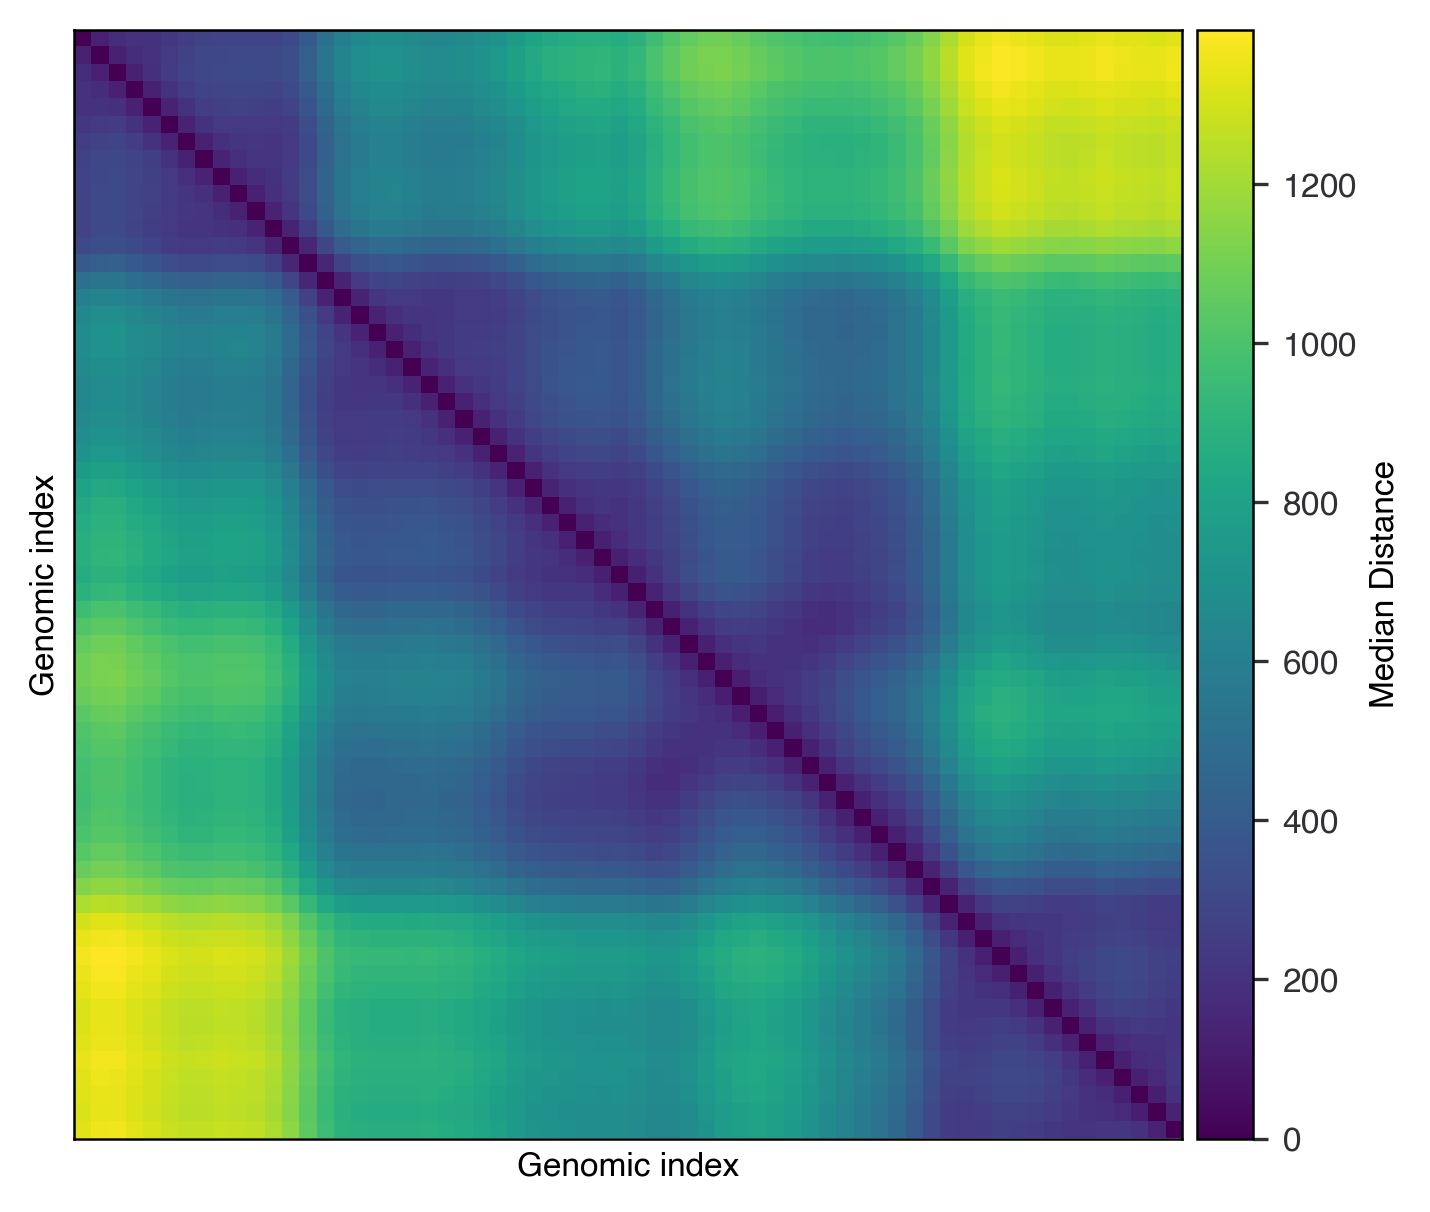

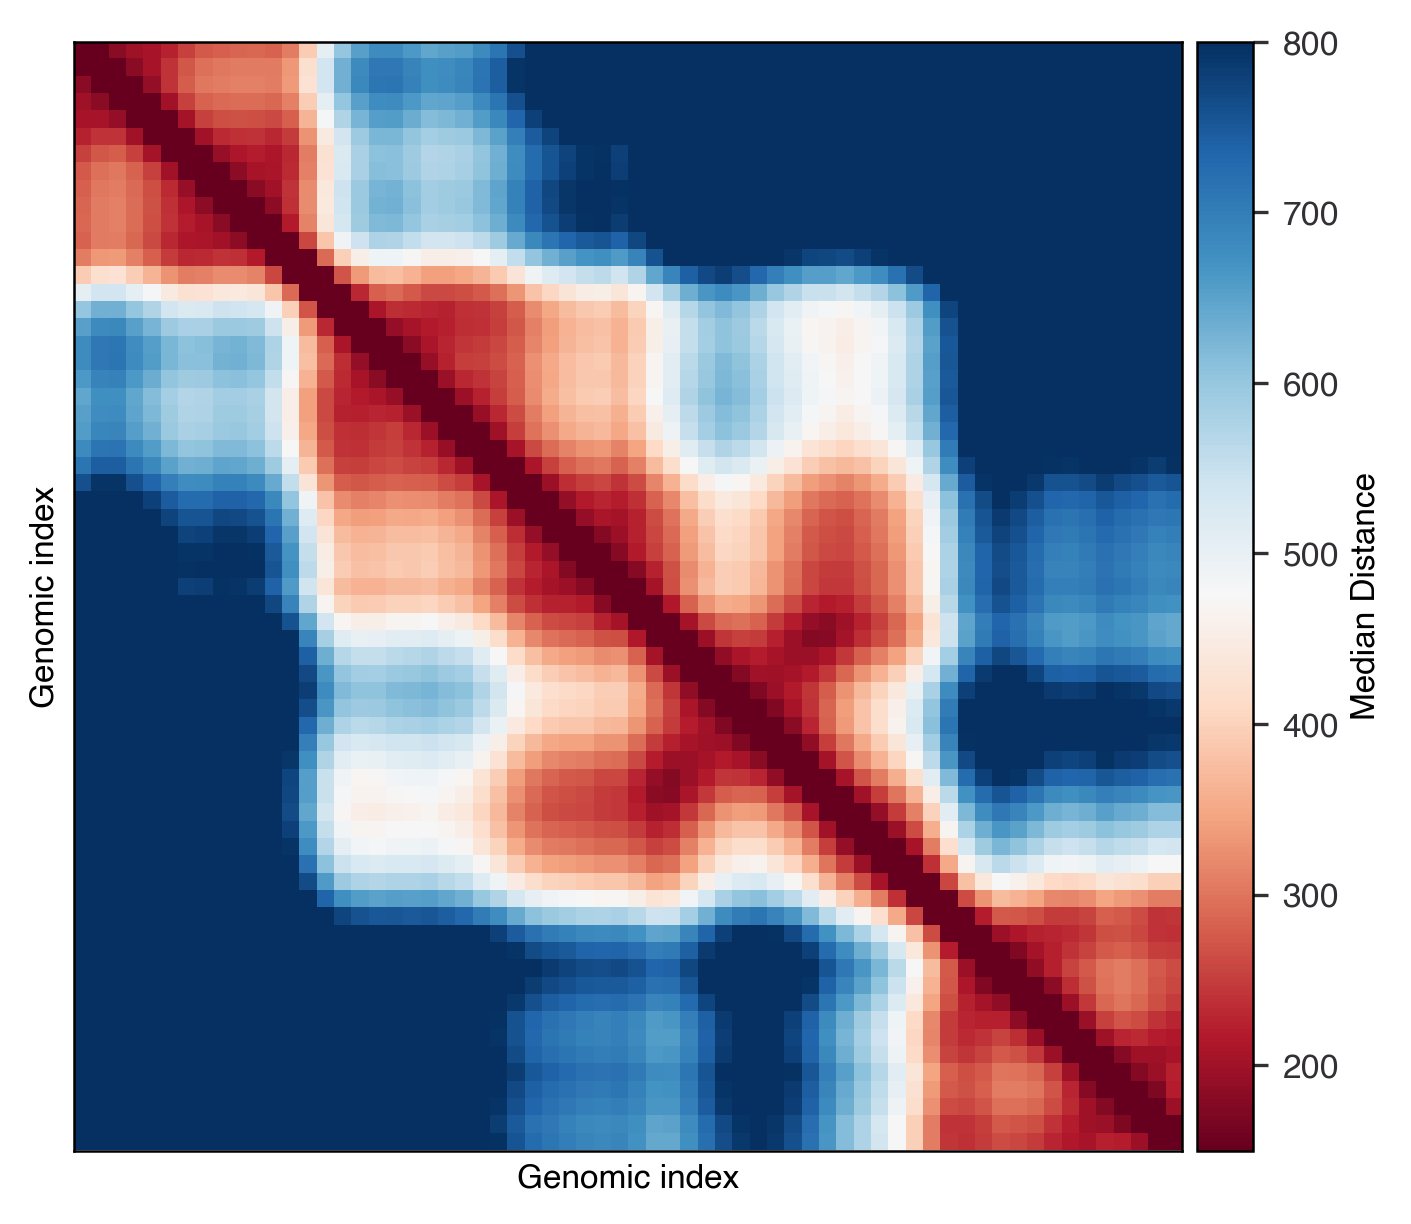

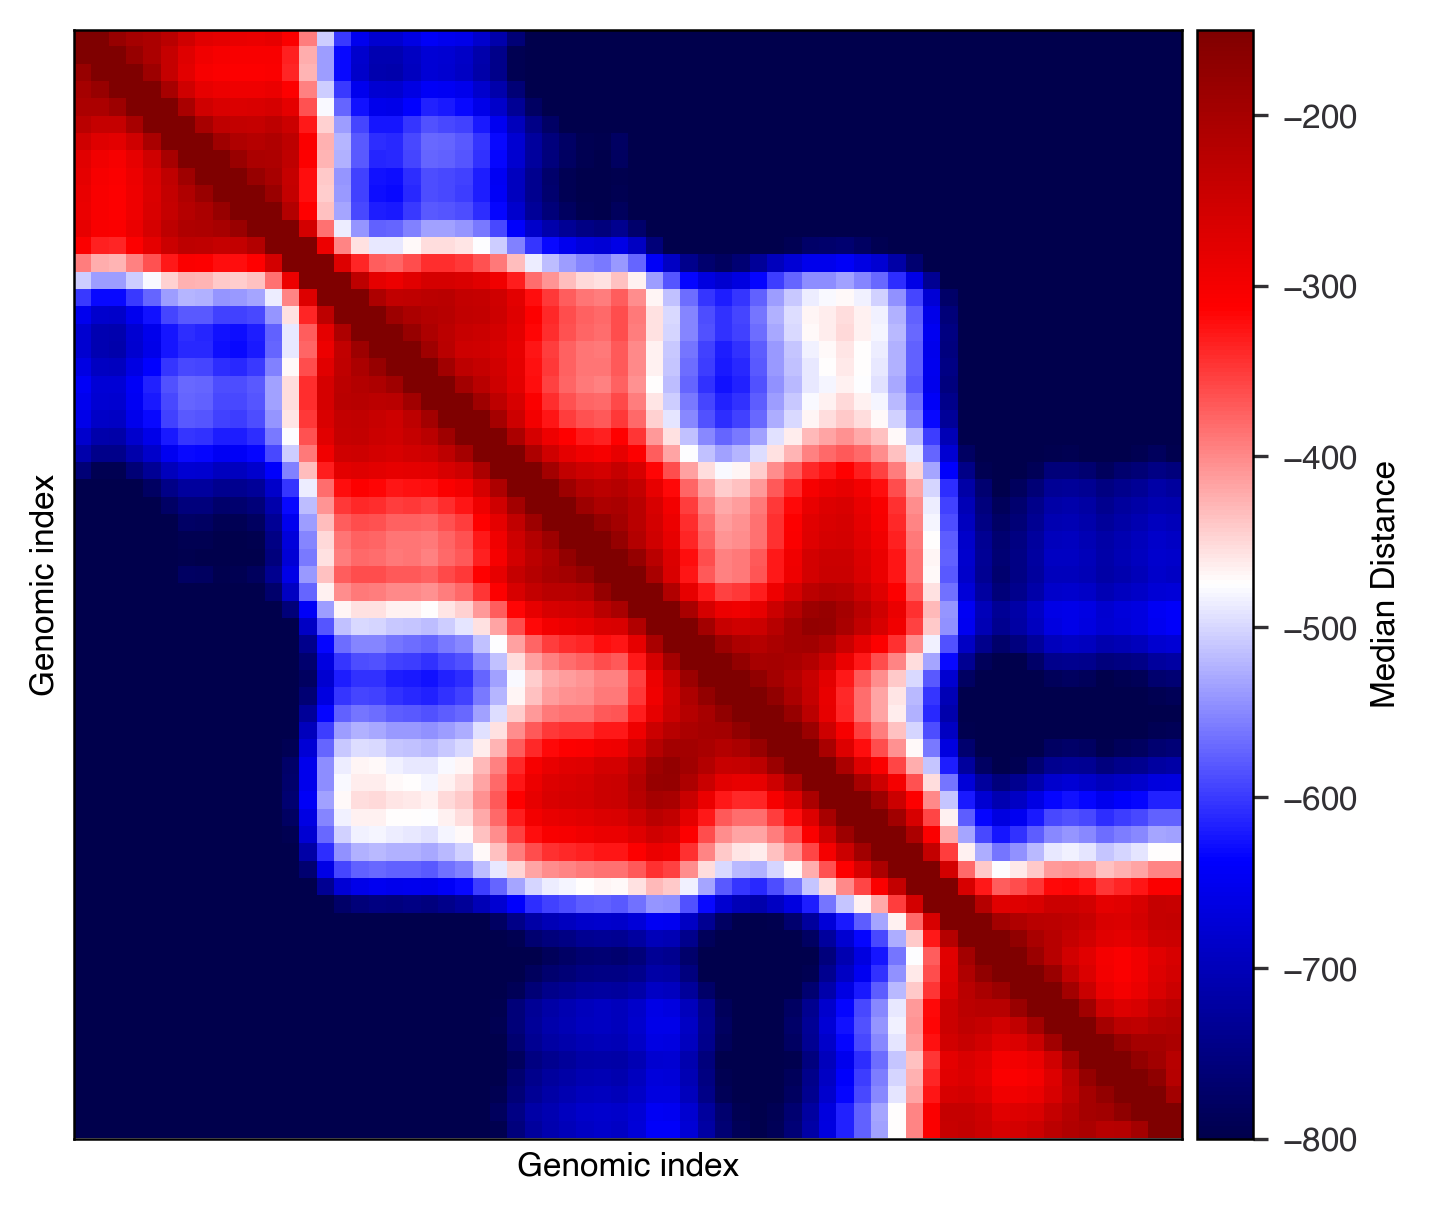

In [183]:
a=Coordinates(
    '../data/samples/origami_64_no_embed_reduction/eval_mode/sample_395_5.0_8.0_120_1.pt'
).distances.median
a._values*= 100
a.plot(vmin=None,vmax=None,cmap='viridis')
a.plot(vmin=150,vmax=800)

a._values*=-1
a.plot(vmin=-800,vmax=-150,cmap='seismic')

tensor([[1.0000, 0.9492],
        [0.9492, 1.0000]], dtype=torch.float64)

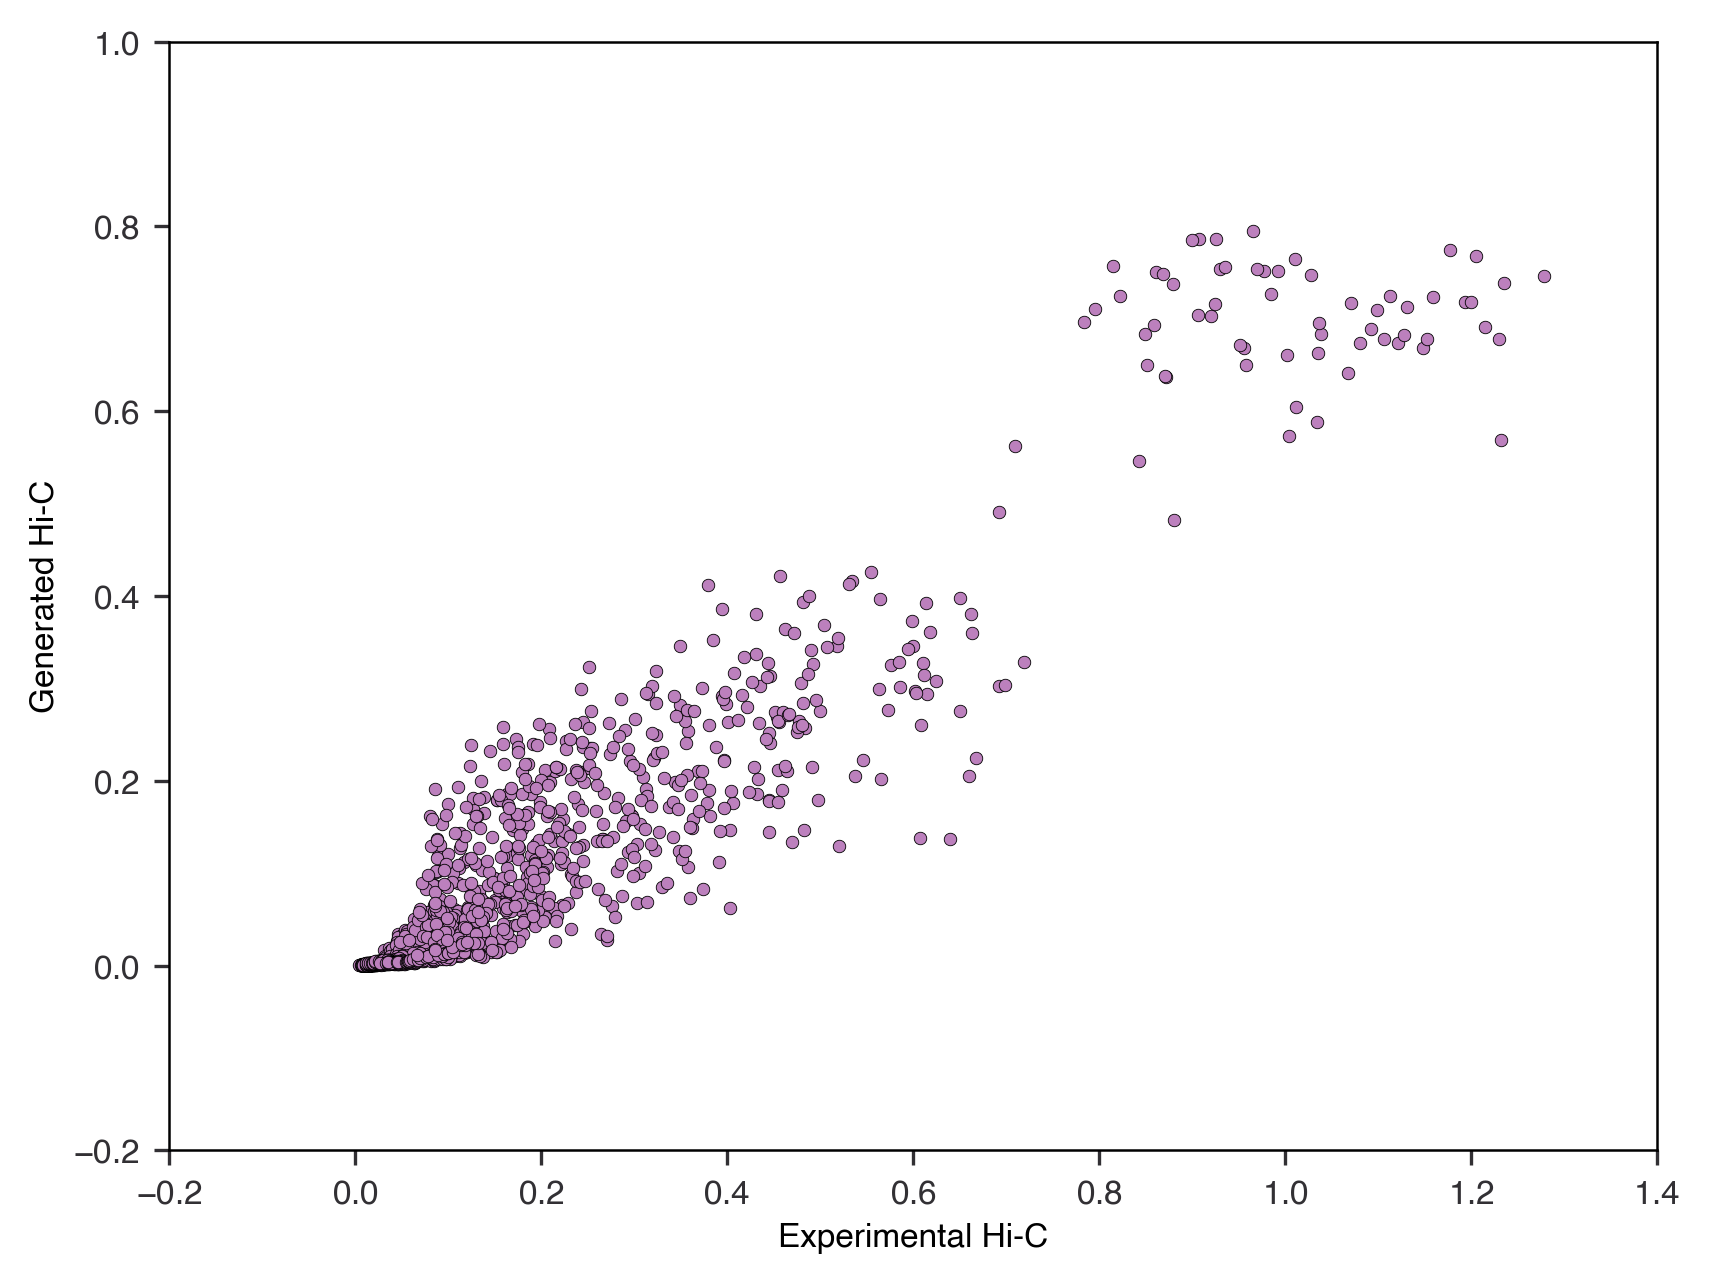

In [107]:
i,j = torch.triu_indices(64,64,1)
x = exp_map.prob_map[i,j]
y = conformations_to_probs(coords,sigma=3,r_c=1.5).prob_map[i,j]

plt.plot(x,y,'.')
plt.xlabel('Experimental Hi-C')
plt.ylabel('Generated Hi-C')
torch.corrcoef(torch.stack([x,y],dim=0))